In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import optuna

/Users/rderi/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('FReD-2024-11-29_cleaned.csv')

data = data[data.result != 'OS not significant']
data.loc[data.result == 'Failure (reversal)', 'result'] = 'Failure'

data = data.drop(columns=data.columns[data.columns.str.startswith('tag_')])
data = data.drop(columns=data.columns[data.columns.str.startswith('disc_')])

X = data.drop(columns=['result'])
y = data['result']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [34]:
le.classes_

array(['Failure', 'Success'], dtype=object)

In [4]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
        'lambda_l2': trial.suggest_float('reg_lambda', 0.01, 1.0, log=True),
        'feature_pre_filter': False,
        'verbose': -1
    }
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)],
    )
    
    preds = model.predict(X_test)
    pred_labels = np.round(preds)
    accuracy = np.mean(pred_labels == y_test)
    return accuracy

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Best trial:")
print("\tValue:", study.best_trial.value)
print(" \tParams:")
for key, value in study.best_trial.params.items():
    print("\t\t{}: {}".format(key, value))

[I 2024-12-07 18:34:16,130] A new study created in memory with name: no-name-774df654-d79f-4bf1-b08a-1c1a74025e3d
[I 2024-12-07 18:34:16,214] Trial 0 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 127, 'learning_rate': 0.010972193419052994, 'feature_fraction': 0.8239143808709212, 'bagging_fraction': 0.7737371008268179, 'bagging_freq': 6, 'min_child_samples': 87, 'reg_alpha': 0.13533061038367072, 'reg_lambda': 0.3502255158224028}. Best is trial 0 with value: 0.5643564356435643.
[I 2024-12-07 18:34:16,286] Trial 1 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 144, 'learning_rate': 0.039767764222187585, 'feature_fraction': 0.6152246450351186, 'bagging_fraction': 0.856073145192824, 'bagging_freq': 1, 'min_child_samples': 47, 'reg_alpha': 0.09071417551507352, 'reg_lambda': 0.013590360050925464}. Best is trial 1 with value: 0.6336633663366337.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.677458
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.676362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.654942
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:16,542] Trial 2 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 79, 'learning_rate': 0.023423491619774958, 'feature_fraction': 0.49550304030497694, 'bagging_fraction': 0.9192923532924214, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.014620977954236284, 'reg_lambda': 0.014651288104677623}. Best is trial 2 with value: 0.6435643564356436.
[I 2024-12-07 18:34:16,595] Trial 3 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 258, 'learning_rate': 0.48939644809574323, 'feature_fraction': 0.9418510901482803, 'bagging_fraction': 0.2584695708982554, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.08956616269753312, 'reg_lambda': 0.2544508048555893}. Best is trial 2 with value: 0.6435643564356436.


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.630265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.667375
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.688618
[200]	valid_0's binary_logloss: 0.68455
[300]	valid_0's binary_logloss: 0.681091
[400]	valid_0's binary_logloss: 0.678083
[500]	valid_0's binary_logloss: 0.676047
[600]	valid_0's binary_logloss: 0.674511
[700]	valid_0's binary_logloss: 0.673108
[800]	valid_0's binary_logloss: 0.671748


[I 2024-12-07 18:34:17,031] Trial 4 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 299, 'learning_rate': 0.0014422965719799827, 'feature_fraction': 0.22086157914117216, 'bagging_fraction': 0.44518221768331456, 'bagging_freq': 6, 'min_child_samples': 55, 'reg_alpha': 0.049130294925808296, 'reg_lambda': 0.01020088179662374}. Best is trial 2 with value: 0.6435643564356436.
[I 2024-12-07 18:34:17,072] Trial 5 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 161, 'learning_rate': 0.17930327598199658, 'feature_fraction': 0.6411562539148083, 'bagging_fraction': 0.5748056044869378, 'bagging_freq': 7, 'min_child_samples': 46, 'reg_alpha': 0.026688896931299978, 'reg_lambda': 0.36703006725648857}. Best is trial 2 with value: 0.6435643564356436.
[I 2024-12-07 18:34:17,170] Trial 6 finished with value: 0.5544554455445545 and parameters: {'num_leaves': 227, 'learning_rate': 0.014118903579052338, 'feature_fraction': 0.1462087658075934, 'bagging_fraction':

[900]	valid_0's binary_logloss: 0.670967
[1000]	valid_0's binary_logloss: 0.670032
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.670032
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.668212
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.669312
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.667248
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:17,446] Trial 7 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 17, 'learning_rate': 0.021541378232544373, 'feature_fraction': 0.1608767813446828, 'bagging_fraction': 0.8699153394925132, 'bagging_freq': 6, 'min_child_samples': 12, 'reg_alpha': 0.1045619976007814, 'reg_lambda': 0.5324457169475642}. Best is trial 7 with value: 0.6534653465346535.
[I 2024-12-07 18:34:17,545] Trial 8 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 278, 'learning_rate': 0.20165382611130434, 'feature_fraction': 0.5167797186085732, 'bagging_fraction': 0.24624003991044788, 'bagging_freq': 3, 'min_child_samples': 5, 'reg_alpha': 0.11003426064955946, 'reg_lambda': 0.010020494137012103}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.650463
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.649125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.612471
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:17,579] Trial 9 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 265, 'learning_rate': 0.09689989488384639, 'feature_fraction': 0.19225482906066918, 'bagging_fraction': 0.8882168879720047, 'bagging_freq': 2, 'min_child_samples': 91, 'reg_alpha': 0.036970070471989934, 'reg_lambda': 0.4411572645573757}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:17,610] Trial 10 finished with value: 0.504950495049505 and parameters: {'num_leaves': 212, 'learning_rate': 0.7784351574610889, 'feature_fraction': 0.40523265168404443, 'bagging_fraction': 0.1396979492424337, 'bagging_freq': 3, 'min_child_samples': 30, 'reg_alpha': 0.6819208754970859, 'reg_lambda': 0.04766426542158148}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.664288
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.649019


[I 2024-12-07 18:34:18,148] Trial 11 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 14, 'learning_rate': 0.005556620757697104, 'feature_fraction': 0.35538218362927865, 'bagging_fraction': 0.3744059924903993, 'bagging_freq': 4, 'min_child_samples': 5, 'reg_alpha': 0.28281374764095174, 'reg_lambda': 0.07463782706816309}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:18,238] Trial 12 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 36, 'learning_rate': 0.10184024002226738, 'feature_fraction': 0.7520823966269671, 'bagging_fraction': 0.735525400795586, 'bagging_freq': 4, 'min_child_samples': 25, 'reg_alpha': 0.19532890458272006, 'reg_lambda': 0.03437534406355478}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:18,271] Trial 13 finished with value: 0.504950495049505 and parameters: {'num_leaves': 88, 'learning_rate': 0.0035999473105331895, 'feature_fraction': 0.29832221110742146, 'bagging_fraction': 0.10

[200]	valid_0's binary_logloss: 0.640813
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.639939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.652591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:18,346] Trial 14 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 188, 'learning_rate': 0.23274819543212033, 'feature_fraction': 0.49226981579134865, 'bagging_fraction': 0.4281267993337364, 'bagging_freq': 4, 'min_child_samples': 20, 'reg_alpha': 0.06695058780688351, 'reg_lambda': 0.14308204146556253}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:18,380] Trial 15 finished with value: 0.504950495049505 and parameters: {'num_leaves': 93, 'learning_rate': 0.049643050180572586, 'feature_fraction': 0.7162928092056947, 'bagging_fraction': 0.29169517477453655, 'bagging_freq': 5, 'min_child_samples': 74, 'reg_alpha': 0.9807046551436137, 'reg_lambda': 0.9628603986751934}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:18,496] Trial 16 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 60, 'learning_rate': 0.30842519826559606, 'feature_fraction': 0.12108209811674064, 'bagging_fraction': 0.98

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.637103
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.640692
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:18,642] Trial 17 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 114, 'learning_rate': 0.08677075604323085, 'feature_fraction': 0.9885932507407011, 'bagging_fraction': 0.6586412625013227, 'bagging_freq': 3, 'min_child_samples': 16, 'reg_alpha': 0.31577733792912244, 'reg_lambda': 0.07402786762042851}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:18,781] Trial 18 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 180, 'learning_rate': 0.982283225052936, 'feature_fraction': 0.3018678279023992, 'bagging_fraction': 0.5368129790920801, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.05331917962772484, 'reg_lambda': 0.20746970490802882}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.642919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.719403
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.676154


[I 2024-12-07 18:34:18,845] Trial 19 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 279, 'learning_rate': 0.017542703609001446, 'feature_fraction': 0.4475146001465381, 'bagging_fraction': 0.23849944816170823, 'bagging_freq': 5, 'min_child_samples': 31, 'reg_alpha': 0.02662060467838896, 'reg_lambda': 0.587218250408661}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.674319
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.660723
[200]	valid_0's binary_logloss: 0.652162


[I 2024-12-07 18:34:19,116] Trial 20 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 235, 'learning_rate': 0.005038953234700845, 'feature_fraction': 0.5836491627611299, 'bagging_fraction': 0.757050073704015, 'bagging_freq': 3, 'min_child_samples': 38, 'reg_alpha': 0.01026040066053881, 'reg_lambda': 0.026983177636110366}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:19,288] Trial 21 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 58, 'learning_rate': 0.03015980695390176, 'feature_fraction': 0.5075469685451297, 'bagging_fraction': 0.9652898732800993, 'bagging_freq': 7, 'min_child_samples': 17, 'reg_alpha': 0.11411411960390354, 'reg_lambda': 0.015054575037884205}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.650616
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.648533
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:19,577] Trial 22 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 17, 'learning_rate': 0.02942963772459351, 'feature_fraction': 0.36999275017849864, 'bagging_fraction': 0.8452497393840408, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.18418918793324154, 'reg_lambda': 0.02177614786132402}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:19,706] Trial 23 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 12, 'learning_rate': 0.06117283985561862, 'feature_fraction': 0.23963680980129326, 'bagging_fraction': 0.8181039738051542, 'bagging_freq': 9, 'min_child_samples': 21, 'reg_alpha': 0.2326609330245571, 'reg_lambda': 0.020072429940480134}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.637043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.65237
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.633355


[I 2024-12-07 18:34:20,232] Trial 24 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 48, 'learning_rate': 0.010770771178964697, 'feature_fraction': 0.3477250719552053, 'bagging_fraction': 0.6513908067733482, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.46867498770741056, 'reg_lambda': 0.044875711085890786}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.629144
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.636641


[I 2024-12-07 18:34:20,867] Trial 25 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 50, 'learning_rate': 0.00964036132088921, 'feature_fraction': 0.35473192623206384, 'bagging_fraction': 0.6706184364031521, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.47242628750860644, 'reg_lambda': 0.04830285785365953}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.630351
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.677129
[200]	valid_0's binary_logloss: 0.665921
[300]	valid_0's binary_logloss: 0.658811
[400]	valid_0's binary_logloss: 0.65302
[500]	valid_0's binary_logloss: 0.650939


[I 2024-12-07 18:34:21,530] Trial 26 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 38, 'learning_rate': 0.0018980447756983103, 'feature_fraction': 0.4143541560062659, 'bagging_fraction': 0.5045871284620075, 'bagging_freq': 8, 'min_child_samples': 22, 'reg_alpha': 0.5528303435169435, 'reg_lambda': 0.010481399018301198}. Best is trial 8 with value: 0.6831683168316832.


[600]	valid_0's binary_logloss: 0.64787
[700]	valid_0's binary_logloss: 0.646773
Early stopping, best iteration is:
[703]	valid_0's binary_logloss: 0.646638
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.676781


[I 2024-12-07 18:34:21,618] Trial 27 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 109, 'learning_rate': 0.007882436234467728, 'feature_fraction': 0.2871146666997176, 'bagging_fraction': 0.6720366666510731, 'bagging_freq': 9, 'min_child_samples': 78, 'reg_alpha': 0.17655176322884422, 'reg_lambda': 0.04170494332485655}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:21,652] Trial 28 finished with value: 0.504950495049505 and parameters: {'num_leaves': 72, 'learning_rate': 0.002730528269657394, 'feature_fraction': 0.535343781915377, 'bagging_fraction': 0.3227790465214711, 'bagging_freq': 8, 'min_child_samples': 98, 'reg_alpha': 0.8220568334663746, 'reg_lambda': 0.02045132760701991}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:21,718] Trial 29 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 127, 'learning_rate': 0.14280648806090143, 'feature_fraction': 0.6751325472353329, 'bagging_fraction': 0.176

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.676033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.650973
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.652922


[I 2024-12-07 18:34:21,966] Trial 30 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 30, 'learning_rate': 0.012122432074305798, 'feature_fraction': 0.3773679864370338, 'bagging_fraction': 0.8053004990160892, 'bagging_freq': 8, 'min_child_samples': 38, 'reg_alpha': 0.3448890673140724, 'reg_lambda': 0.06642750318201206}. Best is trial 8 with value: 0.6831683168316832.


[200]	valid_0's binary_logloss: 0.651206
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.650216
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:22,196] Trial 31 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 23, 'learning_rate': 0.023107722919263902, 'feature_fraction': 0.17931601502788136, 'bagging_fraction': 0.7308447626503859, 'bagging_freq': 6, 'min_child_samples': 15, 'reg_alpha': 0.07317877542053296, 'reg_lambda': 0.018622796409218552}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.659253
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.653156
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:22,422] Trial 32 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 43, 'learning_rate': 0.03448453958030146, 'feature_fraction': 0.10461730163505097, 'bagging_fraction': 0.8502779398233102, 'bagging_freq': 6, 'min_child_samples': 11, 'reg_alpha': 0.12497016820031562, 'reg_lambda': 0.01284950543900786}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.644639
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:22,841] Trial 33 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 142, 'learning_rate': 0.020050394575319597, 'feature_fraction': 0.45862948374492973, 'bagging_fraction': 0.9222709859017004, 'bagging_freq': 2, 'min_child_samples': 5, 'reg_alpha': 0.22776231592350843, 'reg_lambda': 0.03845384639299595}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:22,993] Trial 34 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 71, 'learning_rate': 0.048351419648187476, 'feature_fraction': 0.558196426878784, 'bagging_fraction': 0.794303920430065, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.10097409106048051, 'reg_lambda': 0.10010655330325455}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.648339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.64414
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:23,329] Trial 35 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 25, 'learning_rate': 0.007405344426868935, 'feature_fraction': 0.24968139272341733, 'bagging_fraction': 0.9331353377531016, 'bagging_freq': 9, 'min_child_samples': 26, 'reg_alpha': 0.09142663842507416, 'reg_lambda': 0.0155718017673143}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.658425
[200]	valid_0's binary_logloss: 0.652222
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.651022
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:23,554] Trial 36 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 11, 'learning_rate': 0.029783366540303814, 'feature_fraction': 0.3299764594561795, 'bagging_fraction': 0.8649530312846172, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.07073575091441416, 'reg_lambda': 0.05798437159404942}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:23,656] Trial 37 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 300, 'learning_rate': 0.40715810555870574, 'feature_fraction': 0.6226391832620236, 'bagging_fraction': 0.5994344256625839, 'bagging_freq': 6, 'min_child_samples': 17, 'reg_alpha': 0.2530068759092111, 'reg_lambda': 0.19892991267881474}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:23,715] Trial 38 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 292, 'learning_rate': 0.43926060994712685, 'feature_fraction': 0.855684963888933, 'bagging_fraction': 0.603

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.635374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.652897
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.641351
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:23,809] Trial 39 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 248, 'learning_rate': 0.5181176694218288, 'feature_fraction': 0.6115196449304967, 'bagging_fraction': 0.4712835604613942, 'bagging_freq': 8, 'min_child_samples': 18, 'reg_alpha': 0.4355010149729238, 'reg_lambda': 0.2463062720079784}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:23,852] Trial 40 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 259, 'learning_rate': 0.19526296714390184, 'feature_fraction': 0.8034815281655978, 'bagging_fraction': 0.41294033770746136, 'bagging_freq': 8, 'min_child_samples': 62, 'reg_alpha': 0.5111647986269559, 'reg_lambda': 0.2876507750337255}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:23,926] Trial 41 finished with value: 0.5247524752475248 and parameters: {'num_leaves': 240, 'learning_rate': 0.5847802505127278, 'feature_fraction': 0.6385668741926336, 'bagging_fraction': 0.499072

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.658479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.677337
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.692667
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:24,031] Trial 42 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 274, 'learning_rate': 0.3669939159944697, 'feature_fraction': 0.6167524993705994, 'bagging_fraction': 0.47642811521530015, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.6606894371478871, 'reg_lambda': 0.31204351814072867}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,103] Trial 43 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 300, 'learning_rate': 0.6052851927866442, 'feature_fraction': 0.6987226993257891, 'bagging_fraction': 0.5789890558785697, 'bagging_freq': 9, 'min_child_samples': 23, 'reg_alpha': 0.20515258083378538, 'reg_lambda': 0.18033476109876959}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,165] Trial 44 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 249, 'learning_rate': 0.28017733193300054, 'feature_fraction': 0.5877770509848851, 'bagging_fraction': 0.207

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.652491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.667093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.649615
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:24,287] Trial 45 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 216, 'learning_rate': 0.14352843264137286, 'feature_fraction': 0.4581482022488253, 'bagging_fraction': 0.36853843587669716, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.6301335479969375, 'reg_lambda': 0.41986690979844954}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,384] Trial 46 finished with value: 0.5148514851485149 and parameters: {'num_leaves': 279, 'learning_rate': 0.8223258291358475, 'feature_fraction': 0.506690862931396, 'bagging_fraction': 0.6320237192936823, 'bagging_freq': 1, 'min_child_samples': 18, 'reg_alpha': 0.29474537653884414, 'reg_lambda': 0.010353853136032258}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,441] Trial 47 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 287, 'learning_rate': 0.3742142458686, 'feature_fraction': 0.406040441825007, 'bagging_fraction': 0.53155024

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.633801
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.734611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.651896
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:24,527] Trial 48 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 192, 'learning_rate': 0.08569417589432052, 'feature_fraction': 0.7621444035781182, 'bagging_fraction': 0.7136036198914235, 'bagging_freq': 5, 'min_child_samples': 27, 'reg_alpha': 0.34312362362768456, 'reg_lambda': 0.16802979252268932}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,644] Trial 49 finished with value: 0.594059405940594 and parameters: {'num_leaves': 268, 'learning_rate': 0.48891047344848726, 'feature_fraction': 0.6755452411971191, 'bagging_fraction': 0.6996380264016527, 'bagging_freq': 10, 'min_child_samples': 13, 'reg_alpha': 0.24871248096509016, 'reg_lambda': 0.03295481054577751}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:24,717] Trial 50 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 248, 'learning_rate': 0.01527220975221414, 'feature_fraction': 0.5450775503122206, 'bagging_fraction': 0.3

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.652998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.666684
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.674837
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.674308
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:25,002] Trial 51 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 161, 'learning_rate': 0.04211019316386332, 'feature_fraction': 0.1665175177871475, 'bagging_fraction': 0.5702710906633721, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.11010883672067, 'reg_lambda': 0.5256187610446752}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.644182
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:25,242] Trial 52 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 286, 'learning_rate': 0.06308149304144106, 'feature_fraction': 0.21090832582755073, 'bagging_fraction': 0.8871055532440552, 'bagging_freq': 5, 'min_child_samples': 9, 'reg_alpha': 0.13594758380907368, 'reg_lambda': 0.34840878512037127}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:25,318] Trial 53 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 23, 'learning_rate': 0.2666547156088119, 'feature_fraction': 0.283166792140945, 'bagging_fraction': 0.29039165629174185, 'bagging_freq': 7, 'min_child_samples': 19, 'reg_alpha': 0.08245507631412786, 'reg_lambda': 0.63937957873918}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.649789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.623441
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:25,637] Trial 54 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 217, 'learning_rate': 0.011576995203280226, 'feature_fraction': 0.5902954350756418, 'bagging_fraction': 0.7630765753841409, 'bagging_freq': 3, 'min_child_samples': 13, 'reg_alpha': 0.06228462937235362, 'reg_lambda': 0.409490380490511}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:25,707] Trial 55 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 56, 'learning_rate': 0.6664437928794743, 'feature_fraction': 0.6441992652674663, 'bagging_fraction': 0.4627462688182075, 'bagging_freq': 8, 'min_child_samples': 23, 'reg_alpha': 0.14059194725286986, 'reg_lambda': 0.8140004545542691}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.645603
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.644214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.666732
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:26,039] Trial 56 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 92, 'learning_rate': 0.027749498061485484, 'feature_fraction': 0.1415728398098378, 'bagging_fraction': 0.8329311432892864, 'bagging_freq': 4, 'min_child_samples': 8, 'reg_alpha': 0.047187201214602036, 'reg_lambda': 0.012534322467556144}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.648044
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:26,259] Trial 57 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 89, 'learning_rate': 0.16229806843063727, 'feature_fraction': 0.4275695885226463, 'bagging_fraction': 0.6195067429232406, 'bagging_freq': 2, 'min_child_samples': 7, 'reg_alpha': 0.044831945980691235, 'reg_lambda': 0.012239399726900777}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:26,414] Trial 58 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 46, 'learning_rate': 0.11976026596888495, 'feature_fraction': 0.4892885956626414, 'bagging_fraction': 0.8484426295948926, 'bagging_freq': 4, 'min_child_samples': 15, 'reg_alpha': 0.030879053913205123, 'reg_lambda': 0.024270122971069487}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.648154
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:26,537] Trial 59 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 108, 'learning_rate': 0.02600784000027573, 'feature_fraction': 0.3804390526908818, 'bagging_fraction': 0.10014674250605465, 'bagging_freq': 3, 'min_child_samples': 8, 'reg_alpha': 0.8567216852846422, 'reg_lambda': 0.016983321067345212}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:26,590] Trial 60 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 68, 'learning_rate': 0.21027859901726226, 'feature_fraction': 0.740700632238013, 'bagging_fraction': 0.6441325456078586, 'bagging_freq': 4, 'min_child_samples': 59, 'reg_alpha': 0.02128738197662055, 'reg_lambda': 0.013407989490587533}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.648711
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.64646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.664559
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:27,202] Trial 61 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 37, 'learning_rate': 0.019689635894813592, 'feature_fraction': 0.26180619670067756, 'bagging_fraction': 0.9639779401109074, 'bagging_freq': 5, 'min_child_samples': 5, 'reg_alpha': 0.04462730035934099, 'reg_lambda': 0.0225293931346087}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.625242
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:27,531] Trial 62 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 18, 'learning_rate': 0.014657864419232879, 'feature_fraction': 0.14488918969617884, 'bagging_fraction': 0.8363885015925532, 'bagging_freq': 2, 'min_child_samples': 17, 'reg_alpha': 0.466240985813982, 'reg_lambda': 0.011665396670178413}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.650583
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.649511
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:27,933] Trial 63 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 34, 'learning_rate': 0.00922829773937905, 'feature_fraction': 0.3343991083947496, 'bagging_fraction': 0.7873470790120461, 'bagging_freq': 6, 'min_child_samples': 12, 'reg_alpha': 0.08457066998804762, 'reg_lambda': 0.01727196318565679}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.641013
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.638944
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:28,086] Trial 64 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 147, 'learning_rate': 0.0625901090181588, 'feature_fraction': 0.19944525553064624, 'bagging_fraction': 0.8872147359055023, 'bagging_freq': 3, 'min_child_samples': 20, 'reg_alpha': 0.21180590947662098, 'reg_lambda': 0.08027574945000829}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:28,152] Trial 65 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 96, 'learning_rate': 0.03435563908603957, 'feature_fraction': 0.11884764431963564, 'bagging_fraction': 0.6819762343378434, 'bagging_freq': 4, 'min_child_samples': 72, 'reg_alpha': 0.16116644241487327, 'reg_lambda': 0.2633426921992781}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.644177
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.673799
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.669229
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.66609
[200]	valid_0's binary_logloss: 0.654485


[I 2024-12-07 18:34:29,074] Trial 66 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 294, 'learning_rate': 0.0046489067162390095, 'feature_fraction': 0.1708104643459782, 'bagging_fraction': 0.757215235381348, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.054572673285987874, 'reg_lambda': 0.47945384215843045}. Best is trial 8 with value: 0.6831683168316832.


[300]	valid_0's binary_logloss: 0.652274
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.651692
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.67331


[I 2024-12-07 18:34:29,272] Trial 67 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 80, 'learning_rate': 0.0066123549191701445, 'feature_fraction': 0.21974118575690033, 'bagging_fraction': 0.1566966348133495, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.34853414049826403, 'reg_lambda': 0.014427482062643517}. Best is trial 8 with value: 0.6831683168316832.


[200]	valid_0's binary_logloss: 0.664731
[300]	valid_0's binary_logloss: 0.661142
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.65921
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.650333


[I 2024-12-07 18:34:29,422] Trial 68 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 262, 'learning_rate': 0.016993290740843645, 'feature_fraction': 0.15026880562698558, 'bagging_fraction': 0.8201365485611453, 'bagging_freq': 7, 'min_child_samples': 43, 'reg_alpha': 0.11970588596693758, 'reg_lambda': 0.056570248054790835}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:29,575] Trial 69 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 199, 'learning_rate': 0.025009426695175595, 'feature_fraction': 0.5332133621458122, 'bagging_fraction': 0.9307921527307137, 'bagging_freq': 9, 'min_child_samples': 32, 'reg_alpha': 0.5845086389257775, 'reg_lambda': 0.010236497529112949}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.649638
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.648278
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.638277
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:29,696] Trial 70 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 128, 'learning_rate': 0.9788610700396032, 'feature_fraction': 0.3123484228994921, 'bagging_fraction': 0.5502192024138717, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10048756519682348, 'reg_lambda': 0.7068625307380152}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.700487
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:29,949] Trial 71 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 49, 'learning_rate': 0.02259644429154628, 'feature_fraction': 0.4786040644904579, 'bagging_fraction': 0.5997405439425395, 'bagging_freq': 10, 'min_child_samples': 6, 'reg_alpha': 0.4453344365402417, 'reg_lambda': 0.04981986175118634}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.637918
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.638649


[I 2024-12-07 18:34:30,594] Trial 72 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 53, 'learning_rate': 0.01013006221574631, 'feature_fraction': 0.35655640047517057, 'bagging_fraction': 0.6832873586485464, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.29472004619691333, 'reg_lambda': 0.07990908904876348}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.634918
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.645141
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.64117


[I 2024-12-07 18:34:31,059] Trial 73 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 65, 'learning_rate': 0.00994027189579509, 'feature_fraction': 0.3550927847041815, 'bagging_fraction': 0.7308788774949437, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.28988641298258594, 'reg_lambda': 0.07902652142326214}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.681867
[200]	valid_0's binary_logloss: 0.672323
[300]	valid_0's binary_logloss: 0.664451
[400]	valid_0's binary_logloss: 0.658576
[500]	valid_0's binary_logloss: 0.65374
[600]	valid_0's binary_logloss: 0.64952
[700]	valid_0's binary_logloss: 0.64727
[800]	valid_0's binary_logloss: 0.645667


[I 2024-12-07 18:34:32,688] Trial 74 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 29, 'learning_rate': 0.0010700263572329446, 'feature_fraction': 0.3874724144011698, 'bagging_fraction': 0.6537043624620279, 'bagging_freq': 7, 'min_child_samples': 16, 'reg_alpha': 0.3576269987511528, 'reg_lambda': 0.02862105083837336}. Best is trial 8 with value: 0.6831683168316832.


[900]	valid_0's binary_logloss: 0.644255
[1000]	valid_0's binary_logloss: 0.643938
Did not meet early stopping. Best iteration is:
[971]	valid_0's binary_logloss: 0.64376
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:32,972] Trial 75 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 10, 'learning_rate': 0.013428360528727106, 'feature_fraction': 0.6118198756220797, 'bagging_fraction': 0.42043389122533825, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.24942592797600657, 'reg_lambda': 0.03721304005867262}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.64829
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.639709
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:33,194] Trial 76 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 80, 'learning_rate': 0.041734610639700485, 'feature_fraction': 0.4381667008296071, 'bagging_fraction': 0.9070237965763437, 'bagging_freq': 10, 'min_child_samples': 12, 'reg_alpha': 0.17606129915772234, 'reg_lambda': 0.11764778516461885}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:33,294] Trial 77 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 41, 'learning_rate': 0.4170295589100743, 'feature_fraction': 0.24365366584208825, 'bagging_fraction': 0.696802977991496, 'bagging_freq': 5, 'min_child_samples': 24, 'reg_alpha': 0.547819134662625, 'reg_lambda': 0.13951588925984038}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.632794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.636153
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.653026
[200]	valid_0's binary_logloss: 0.637426


[I 2024-12-07 18:34:34,605] Trial 78 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 54, 'learning_rate': 0.0035068651369602067, 'feature_fraction': 0.2832783697878867, 'bagging_fraction': 0.987276627175689, 'bagging_freq': 2, 'min_child_samples': 8, 'reg_alpha': 0.3143728552651257, 'reg_lambda': 0.0931813967337502}. Best is trial 8 with value: 0.6831683168316832.


[300]	valid_0's binary_logloss: 0.633157
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.632996
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:34,755] Trial 79 finished with value: 0.594059405940594 and parameters: {'num_leaves': 19, 'learning_rate': 0.311052191223612, 'feature_fraction': 0.5173469520972551, 'bagging_fraction': 0.7782305050506048, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.3876070248166224, 'reg_lambda': 0.9228028733890198}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:34,835] Trial 80 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 102, 'learning_rate': 0.018333056964765074, 'feature_fraction': 0.6334190620956087, 'bagging_fraction': 0.22068218897345893, 'bagging_freq': 8, 'min_child_samples': 20, 'reg_alpha': 0.7812555241995779, 'reg_lambda': 0.04394215217425595}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.658487
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.663171
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.65864
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.637545


[I 2024-12-07 18:34:35,502] Trial 81 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 53, 'learning_rate': 0.008801230687605487, 'feature_fraction': 0.3488383951474513, 'bagging_fraction': 0.6686418823063225, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.4829099926368935, 'reg_lambda': 0.06311424146900024}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.630459
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.638473
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.631972


[I 2024-12-07 18:34:35,966] Trial 82 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 174, 'learning_rate': 0.00805433068578577, 'feature_fraction': 0.5706004793080934, 'bagging_fraction': 0.5970131805582097, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.4918372841873415, 'reg_lambda': 0.06525349829664594}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.65337
[200]	valid_0's binary_logloss: 0.639772


[I 2024-12-07 18:34:36,580] Trial 83 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 64, 'learning_rate': 0.005131150454079523, 'feature_fraction': 0.34686182929828346, 'bagging_fraction': 0.8696733553764774, 'bagging_freq': 10, 'min_child_samples': 13, 'reg_alpha': 0.724694459580007, 'reg_lambda': 0.06761456597612206}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.638378
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.644473


[I 2024-12-07 18:34:36,907] Trial 84 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 33, 'learning_rate': 0.011407119204609729, 'feature_fraction': 0.3196973688086478, 'bagging_fraction': 0.8176860826685218, 'bagging_freq': 10, 'min_child_samples': 28, 'reg_alpha': 0.23065105962271817, 'reg_lambda': 0.08694199745076268}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.641314
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.648529


[I 2024-12-07 18:34:37,559] Trial 85 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 272, 'learning_rate': 0.006610977000192775, 'feature_fraction': 0.6668860592315681, 'bagging_fraction': 0.5276224173360504, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.37999535547578134, 'reg_lambda': 0.057475470568023795}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:37,733] Trial 86 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 76, 'learning_rate': 0.02957885441636622, 'feature_fraction': 0.3705584213653784, 'bagging_fraction': 0.6262214433944581, 'bagging_freq': 4, 'min_child_samples': 17, 'reg_alpha': 0.260826288579491, 'reg_lambda': 0.020952680866082336}. Best is trial 8 with value: 0.6831683168316832.


[200]	valid_0's binary_logloss: 0.642061
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.638285
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.649016
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.639284
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:37,957] Trial 87 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 45, 'learning_rate': 0.07928346247035119, 'feature_fraction': 0.4097961940516335, 'bagging_fraction': 0.7150457058079932, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.012247379017153878, 'reg_lambda': 0.011908233310841867}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:38,124] Trial 88 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 59, 'learning_rate': 0.23176806633977995, 'feature_fraction': 0.40119080516994604, 'bagging_fraction': 0.6734143354504267, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.013360936870726038, 'reg_lambda': 0.011382100623722661}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.628297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.642755


[I 2024-12-07 18:34:38,300] Trial 89 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 253, 'learning_rate': 0.07417598516497419, 'feature_fraction': 0.4746458126122295, 'bagging_fraction': 0.7147688452040947, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.021761676478116124, 'reg_lambda': 0.016967785540063163}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:38,356] Trial 90 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 280, 'learning_rate': 0.10996772848734897, 'feature_fraction': 0.45109398143138213, 'bagging_fraction': 0.7417199992213318, 'bagging_freq': 3, 'min_child_samples': 84, 'reg_alpha': 0.5979566770549898, 'reg_lambda': 0.17714010734469654}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.633447
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.671597


[I 2024-12-07 18:34:38,510] Trial 91 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 45, 'learning_rate': 0.05194878548512585, 'feature_fraction': 0.2736903394904897, 'bagging_fraction': 0.5723116812440785, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.3079056883351717, 'reg_lambda': 0.014106385166253904}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.635907
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:38,687] Trial 92 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 52, 'learning_rate': 0.5365235689940856, 'feature_fraction': 0.4240271291946073, 'bagging_fraction': 0.6487776921227796, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.0328351289116982, 'reg_lambda': 0.10832320646135066}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:38,769] Trial 93 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 28, 'learning_rate': 0.7501559512921189, 'feature_fraction': 0.3025904769217831, 'bagging_fraction': 0.26861385023179574, 'bagging_freq': 5, 'min_child_samples': 9, 'reg_alpha': 0.152195393542318, 'reg_lambda': 0.015787206832992087}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.671002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.712661
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:39,090] Trial 94 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 231, 'learning_rate': 0.01270191283655493, 'feature_fraction': 0.6091147125762499, 'bagging_fraction': 0.6951638261175963, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.062366008866384874, 'reg_lambda': 0.011308018013082236}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.637456
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.636763
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:39,308] Trial 95 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 18, 'learning_rate': 0.03641400154677043, 'feature_fraction': 0.39688702267723514, 'bagging_fraction': 0.6161387308212831, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.016879857375632384, 'reg_lambda': 0.3275609205482796}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.632103
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.646661


[I 2024-12-07 18:34:39,548] Trial 96 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 39, 'learning_rate': 0.015456147909110835, 'feature_fraction': 0.3652831778995372, 'bagging_fraction': 0.7141234167079944, 'bagging_freq': 9, 'min_child_samples': 15, 'reg_alpha': 0.010184896968769324, 'reg_lambda': 0.018925787970345814}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:39,739] Trial 97 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 118, 'learning_rate': 0.02100016907311515, 'feature_fraction': 0.3361670013797116, 'bagging_fraction': 0.6612160462806533, 'bagging_freq': 6, 'min_child_samples': 18, 'reg_alpha': 0.07939707008785092, 'reg_lambda': 0.012946008670670925}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.642973
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.650959
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.644318
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.655378


[I 2024-12-07 18:34:40,609] Trial 98 finished with value: 0.594059405940594 and parameters: {'num_leaves': 287, 'learning_rate': 0.009304489006447762, 'feature_fraction': 0.10339510504258534, 'bagging_fraction': 0.8355147376867571, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.09332475614805602, 'reg_lambda': 0.20253982663178696}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:40,692] Trial 99 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 86, 'learning_rate': 0.051743565455261674, 'feature_fraction': 0.5556799675531684, 'bagging_fraction': 0.332454409516022, 'bagging_freq': 7, 'min_child_samples': 21, 'reg_alpha': 0.41972646385642864, 'reg_lambda': 0.05089940995939497}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.652576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.646556
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:40,893] Trial 100 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 297, 'learning_rate': 0.3166730331906214, 'feature_fraction': 0.7061433746209609, 'bagging_fraction': 0.9538589665923843, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.21153681132258062, 'reg_lambda': 0.032869069471682354}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.6482
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.646735


[I 2024-12-07 18:34:41,669] Trial 101 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 23, 'learning_rate': 0.006205203697787772, 'feature_fraction': 0.356872770214094, 'bagging_fraction': 0.7427657257571825, 'bagging_freq': 10, 'min_child_samples': 7, 'reg_alpha': 0.5143603105320576, 'reg_lambda': 0.0417171970082183}. Best is trial 8 with value: 0.6831683168316832.


[200]	valid_0's binary_logloss: 0.636491
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.635596
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.65543
[200]	valid_0's binary_logloss: 0.643581


[I 2024-12-07 18:34:42,925] Trial 102 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 61, 'learning_rate': 0.0040984211074215305, 'feature_fraction': 0.419540380862407, 'bagging_fraction': 0.799082157456746, 'bagging_freq': 10, 'min_child_samples': 5, 'reg_alpha': 0.45999307877117224, 'reg_lambda': 0.06366631890634275}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.643253
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.649514
[200]	valid_0's binary_logloss: 0.644378


[I 2024-12-07 18:34:43,382] Trial 103 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 48, 'learning_rate': 0.010259253493216521, 'feature_fraction': 0.12916594663432365, 'bagging_fraction': 0.638108044274761, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.1277215800086509, 'reg_lambda': 0.3817978360424201}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.641867
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:43,671] Trial 104 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 34, 'learning_rate': 0.027881984297407434, 'feature_fraction': 0.3187231422496628, 'bagging_fraction': 0.6779909424923739, 'bagging_freq': 10, 'min_child_samples': 9, 'reg_alpha': 0.10885487928718844, 'reg_lambda': 0.046831111629036117}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:43,785] Trial 105 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 54, 'learning_rate': 0.15115154279131096, 'feature_fraction': 0.22800403750834825, 'bagging_fraction': 0.5532120503000636, 'bagging_freq': 9, 'min_child_samples': 14, 'reg_alpha': 0.28615090808119636, 'reg_lambda': 0.07276608759348242}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.635432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.659135
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:44,156] Trial 106 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 75, 'learning_rate': 0.008169099739427537, 'feature_fraction': 0.1889783817164599, 'bagging_fraction': 0.3915701697423647, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.9877184897596943, 'reg_lambda': 0.15141585628156068}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.655821
[200]	valid_0's binary_logloss: 0.647737
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.646935
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:44,514] Trial 107 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 69, 'learning_rate': 0.017041457930868184, 'feature_fraction': 0.26348163243037925, 'bagging_fraction': 0.8994280486745431, 'bagging_freq': 6, 'min_child_samples': 16, 'reg_alpha': 0.17997391527117376, 'reg_lambda': 0.025929167073432357}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.651128
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.646513
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:44,890] Trial 108 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 42, 'learning_rate': 0.008735940288528782, 'feature_fraction': 0.3802728802121118, 'bagging_fraction': 0.5123157585191584, 'bagging_freq': 10, 'min_child_samples': 11, 'reg_alpha': 0.34727807844119807, 'reg_lambda': 0.24757108254377164}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.647029
[200]	valid_0's binary_logloss: 0.645391
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.642001
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:45,049] Trial 109 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 16, 'learning_rate': 0.18099056909669053, 'feature_fraction': 0.29402301889078786, 'bagging_fraction': 0.5942231787835368, 'bagging_freq': 4, 'min_child_samples': 9, 'reg_alpha': 0.41553977513645196, 'reg_lambda': 0.08778053646646293}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.622871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.668984


[I 2024-12-07 18:34:45,250] Trial 110 finished with value: 0.594059405940594 and parameters: {'num_leaves': 27, 'learning_rate': 0.43698460321270427, 'feature_fraction': 0.3344452553789048, 'bagging_fraction': 0.4813672555756554, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.0124229276276642, 'reg_lambda': 0.05523760844359055}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:45,570] Trial 111 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 51, 'learning_rate': 0.02212457537022463, 'feature_fraction': 0.4838874300320668, 'bagging_fraction': 0.6614760122653969, 'bagging_freq': 10, 'min_child_samples': 6, 'reg_alpha': 0.4524072726341986, 'reg_lambda': 0.036343694022742866}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:45,638] Trial 112 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 45, 'learning_rate': 0.023734471569384328, 'feature_fraction': 0.47095203536101216, 'bagging_fraction': 0.606893904298826, 'bagging_freq': 10, 'min_child_samples': 100, 'reg_alpha': 0.5124630842791206, 'reg_lambda': 0.0514382633951566}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.634096
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.679459
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.679459
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:45,995] Trial 113 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 37, 'learning_rate': 0.013792247460128262, 'feature_fraction': 0.5233068002161776, 'bagging_fraction': 0.5675346397320055, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.5573533919924397, 'reg_lambda': 0.0441647219680776}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:46,055] Trial 114 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 50, 'learning_rate': 0.03701870192840321, 'feature_fraction': 0.5779505991729618, 'bagging_fraction': 0.5868917770641673, 'bagging_freq': 10, 'min_child_samples': 69, 'reg_alpha': 0.6654224460532909, 'reg_lambda': 0.5398456597040825}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.64331
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.639411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.673394
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:46,254] Trial 115 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 59, 'learning_rate': 0.03249358664289648, 'feature_fraction': 0.44369624135032215, 'bagging_fraction': 0.7108002479713227, 'bagging_freq': 1, 'min_child_samples': 13, 'reg_alpha': 0.3229215231424804, 'reg_lambda': 0.062165029578651484}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.639383
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.640479


[I 2024-12-07 18:34:46,747] Trial 116 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 30, 'learning_rate': 0.011205739739520333, 'feature_fraction': 0.8704544906833263, 'bagging_fraction': 0.625453045433089, 'bagging_freq': 10, 'min_child_samples': 9, 'reg_alpha': 0.37910792472205945, 'reg_lambda': 0.07432249979325233}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.634122
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:47,113] Trial 117 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 21, 'learning_rate': 0.01911892227924413, 'feature_fraction': 0.5064475445470714, 'bagging_fraction': 0.6910792144438987, 'bagging_freq': 2, 'min_child_samples': 5, 'reg_alpha': 0.45652574135069496, 'reg_lambda': 0.031186062587134484}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:47,281] Trial 118 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 300, 'learning_rate': 0.04397479940423366, 'feature_fraction': 0.654527871942462, 'bagging_fraction': 0.6364560294616387, 'bagging_freq': 5, 'min_child_samples': 11, 'reg_alpha': 0.27091429963730823, 'reg_lambda': 0.05018263728891472}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.643748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.645209
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.64389


[I 2024-12-07 18:34:47,967] Trial 119 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 65, 'learning_rate': 0.0071255195343185515, 'feature_fraction': 0.40996434609631616, 'bagging_fraction': 0.7567374286094473, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.03990835621673527, 'reg_lambda': 0.01015711107557065}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.636838
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:48,230] Trial 120 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 11, 'learning_rate': 0.026478635811426787, 'feature_fraction': 0.5955683531021169, 'bagging_fraction': 0.8644099483511467, 'bagging_freq': 6, 'min_child_samples': 14, 'reg_alpha': 0.6214987504079014, 'reg_lambda': 0.012191504810562765}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.64401
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:48,654] Trial 121 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 66, 'learning_rate': 0.012764044540214474, 'feature_fraction': 0.35859612825684606, 'bagging_fraction': 0.6710785765788543, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.2816921737018789, 'reg_lambda': 0.08499509945567417}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.639666
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.637278
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:48,862] Trial 122 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 83, 'learning_rate': 0.01049189433052274, 'feature_fraction': 0.3436511030320609, 'bagging_fraction': 0.7199524273870936, 'bagging_freq': 8, 'min_child_samples': 53, 'reg_alpha': 0.4200558868910713, 'reg_lambda': 0.07752002404861745}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.660255
[200]	valid_0's binary_logloss: 0.656737
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.655408
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:49,011] Trial 123 finished with value: 0.594059405940594 and parameters: {'num_leaves': 72, 'learning_rate': 0.00549607153647729, 'feature_fraction': 0.3824518153987244, 'bagging_fraction': 0.1213861187623424, 'bagging_freq': 10, 'min_child_samples': 7, 'reg_alpha': 0.32279521276166834, 'reg_lambda': 0.10660772894439059}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.662512
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.659635
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:49,422] Trial 124 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 93, 'learning_rate': 0.009110078351853708, 'feature_fraction': 0.46374782731877473, 'bagging_fraction': 0.7387930917819624, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.23319366112200024, 'reg_lambda': 0.011354508328839321}. Best is trial 8 with value: 0.6831683168316832.


[100]	valid_0's binary_logloss: 0.639481
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.638723
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.642896


[I 2024-12-07 18:34:49,652] Trial 125 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 44, 'learning_rate': 0.01607083601909212, 'feature_fraction': 0.43122491792790724, 'bagging_fraction': 0.7865553071636907, 'bagging_freq': 10, 'min_child_samples': 18, 'reg_alpha': 0.3729417623710371, 'reg_lambda': 0.039038489164099285}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:49,721] Trial 126 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 57, 'learning_rate': 0.6623759273161828, 'feature_fraction': 0.3900179092348962, 'bagging_fraction': 0.8329531946965898, 'bagging_freq': 8, 'min_child_samples': 36, 'reg_alpha': 0.1992264776293783, 'reg_lambda': 0.06997331378026354}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:49,784] Trial 127 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 206, 'learning_rate': 0.6176013777424212, 'feature_fraction': 0.5463159191806678, 'bagging_fraction': 0.8

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.641542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.638027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.678456
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:49,857] Trial 128 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 56, 'learning_rate': 0.3629040942114901, 'feature_fraction': 0.395414149363711, 'bagging_fraction': 0.8338239949134927, 'bagging_freq': 3, 'min_child_samples': 34, 'reg_alpha': 0.1292432562648822, 'reg_lambda': 0.2969371668446687}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:49,955] Trial 129 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 223, 'learning_rate': 0.8463418380743226, 'feature_fraction': 0.6255656371325095, 'bagging_fraction': 0.8835786407911166, 'bagging_freq': 8, 'min_child_samples': 22, 'reg_alpha': 0.075070510064559, 'reg_lambda': 0.06951390366539516}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:50,015] Trial 130 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 269, 'learning_rate': 0.500275983007782, 'feature_fraction': 0.4919186629213341, 'bagging_fraction': 0.61332294

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.644884
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.630408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.659663
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:50,170] Trial 131 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 60, 'learning_rate': 0.6856933381026096, 'feature_fraction': 0.3503630648201639, 'bagging_fraction': 0.7661729683729812, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.24178085072917216, 'reg_lambda': 0.05858528323693815}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:50,363] Trial 132 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 49, 'learning_rate': 0.08887706322440651, 'feature_fraction': 0.3070253786860086, 'bagging_fraction': 0.6547112443049913, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.21076866904034988, 'reg_lambda': 0.05352491254970902}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.654061
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.642884


[I 2024-12-07 18:34:50,442] Trial 133 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 241, 'learning_rate': 0.11995234999925546, 'feature_fraction': 0.15586151336732573, 'bagging_fraction': 0.6523273452272914, 'bagging_freq': 9, 'min_child_samples': 25, 'reg_alpha': 0.2203689554734877, 'reg_lambda': 0.04648808334124616}. Best is trial 8 with value: 0.6831683168316832.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.648033
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:50,592] Trial 134 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 40, 'learning_rate': 0.5730692755957779, 'feature_fraction': 0.310198842948964, 'bagging_fraction': 0.44338894410345436, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.16558798588100224, 'reg_lambda': 0.05098422495698407}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:50,746] Trial 135 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 30, 'learning_rate': 0.08988151043522169, 'feature_fraction': 0.30307516010230806, 'bagging_fraction': 0.45566067140404176, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.16410555899742618, 'reg_lambda': 0.014996767067717694}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.61106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.615792
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:50,822] Trial 136 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 38, 'learning_rate': 0.07720017598926562, 'feature_fraction': 0.31638675226972574, 'bagging_fraction': 0.18947062083706745, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.18526055009044642, 'reg_lambda': 0.05298847929223563}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:50,929] Trial 137 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 283, 'learning_rate': 0.5370877617211561, 'feature_fraction': 0.24866989088958477, 'bagging_fraction': 0.4052582631646552, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.20421785002148624, 'reg_lambda': 0.013144617534970572}. Best is trial 8 with value: 0.6831683168316832.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.642827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.67613
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:51,120] Trial 138 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 293, 'learning_rate': 0.39271586354670307, 'feature_fraction': 0.36573148117060106, 'bagging_fraction': 0.8410039010427108, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.17252351470387467, 'reg_lambda': 0.13028574990547212}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:51,218] Trial 139 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 43, 'learning_rate': 0.24405491546487632, 'feature_fraction': 0.6874611074739417, 'bagging_fraction': 0.34870536564804944, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.14261700527487808, 'reg_lambda': 0.040172269480853506}. Best is trial 8 with value: 0.6831683168316832.
[I 2024-12-07 18:34:51,312] Trial 140 finished with value: 0.693069306930693 and parameters: {'num_leaves': 134, 'learning_rate': 0.8314477548559503, 'feature_fraction': 0.2864120943402287, 'bagging_fraction': 0

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.657575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.641246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.671074


[I 2024-12-07 18:34:51,382] Trial 141 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 156, 'learning_rate': 0.9945284071564288, 'feature_fraction': 0.3248338762923513, 'bagging_fraction': 0.38248644254735475, 'bagging_freq': 7, 'min_child_samples': 16, 'reg_alpha': 0.09878467844354609, 'reg_lambda': 0.02419979275948426}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:51,495] Trial 142 finished with value: 0.5544554455445545 and parameters: {'num_leaves': 169, 'learning_rate': 0.8534710494405886, 'feature_fraction': 0.27578605847789994, 'bagging_fraction': 0.43268435766469987, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.11199274786555947, 'reg_lambda': 0.02247226388405353}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.694372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.682541
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:51,569] Trial 143 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 185, 'learning_rate': 0.7172297308460128, 'feature_fraction': 0.1304748899010406, 'bagging_fraction': 0.49316074435263074, 'bagging_freq': 7, 'min_child_samples': 19, 'reg_alpha': 0.08814112596039345, 'reg_lambda': 0.03488811951558993}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:51,658] Trial 144 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 120, 'learning_rate': 0.32285321068287365, 'feature_fraction': 0.2078435368441892, 'bagging_fraction': 0.4378195797728872, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.12128643811797252, 'reg_lambda': 0.22266723318922926}. Best is trial 140 with value: 0.693069306930693.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.662247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.639204
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:51,825] Trial 145 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 55, 'learning_rate': 0.5906338443236551, 'feature_fraction': 0.2923157792750694, 'bagging_fraction': 0.8738333017771382, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.10534613131713583, 'reg_lambda': 0.01777340063242507}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:51,957] Trial 146 finished with value: 0.594059405940594 and parameters: {'num_leaves': 106, 'learning_rate': 0.4584572179277587, 'feature_fraction': 0.33641768864644883, 'bagging_fraction': 0.4651614674860373, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.139308722259355, 'reg_lambda': 0.06766979164935738}. Best is trial 140 with value: 0.693069306930693.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.623922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.652787
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:52,091] Trial 147 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 148, 'learning_rate': 0.7945954715250996, 'feature_fraction': 0.37445506801796147, 'bagging_fraction': 0.9135003038749796, 'bagging_freq': 6, 'min_child_samples': 12, 'reg_alpha': 0.19624873304359153, 'reg_lambda': 0.057392916031708145}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:52,141] Trial 148 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 136, 'learning_rate': 0.1275553659115028, 'feature_fraction': 0.40673018162464414, 'bagging_fraction': 0.3124551645130287, 'bagging_freq': 8, 'min_child_samples': 35, 'reg_alpha': 0.022203602591230897, 'reg_lambda': 0.042815521080229034}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:52,268] Trial 149 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 48, 'learning_rate': 0.6343109247186475, 'feature_fraction': 0.2612722011720068, 'bagging_fraction

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.632544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.668626
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.673788


[I 2024-12-07 18:34:52,443] Trial 150 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 34, 'learning_rate': 0.5293705948143557, 'feature_fraction': 0.38848235156051497, 'bagging_fraction': 0.6844320414096335, 'bagging_freq': 3, 'min_child_samples': 5, 'reg_alpha': 0.16825287051819018, 'reg_lambda': 0.010025732450050283}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.646716
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:52,676] Trial 151 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 48, 'learning_rate': 0.032282300285830845, 'feature_fraction': 0.31298477655845436, 'bagging_fraction': 0.6401424080255407, 'bagging_freq': 10, 'min_child_samples': 7, 'reg_alpha': 0.48129968546760193, 'reg_lambda': 0.046874291161857255}. Best is trial 140 with value: 0.693069306930693.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.627777
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:52,979] Trial 152 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 41, 'learning_rate': 0.022035130029173917, 'feature_fraction': 0.35287151471925415, 'bagging_fraction': 0.8519461634432874, 'bagging_freq': 10, 'min_child_samples': 9, 'reg_alpha': 0.5672539714356506, 'reg_lambda': 0.0495701346527306}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:53,136] Trial 153 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 24, 'learning_rate': 0.027606692641016783, 'feature_fraction': 0.36941403632515396, 'bagging_fraction': 0.5856230387450714, 'bagging_freq': 9, 'min_child_samples': 29, 'reg_alpha': 0.5240306453416609, 'reg_lambda': 0.05385443002302282}. Best is trial 140 with value: 0.693069306930693.


[100]	valid_0's binary_logloss: 0.646761
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.631927
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.649752
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.647341


[I 2024-12-07 18:34:53,290] Trial 154 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 53, 'learning_rate': 0.20766810148998235, 'feature_fraction': 0.4201455041931864, 'bagging_fraction': 0.5463781212665335, 'bagging_freq': 10, 'min_child_samples': 6, 'reg_alpha': 0.2220204562910532, 'reg_lambda': 0.447350036708879}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.682896
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:53,439] Trial 155 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 60, 'learning_rate': 0.04485751915059102, 'feature_fraction': 0.33069659376816674, 'bagging_fraction': 0.6677010636948544, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.2579129333302527, 'reg_lambda': 0.06099584547386214}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:53,632] Trial 156 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 275, 'learning_rate': 0.057310333630607765, 'feature_fraction': 0.18730770026710955, 'bagging_fraction': 0.6014621753353298, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.4406697913025588, 'reg_lambda': 0.0722862297822415}. Best is trial 140 with value: 0.693069306930693.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.636901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.650039


[I 2024-12-07 18:34:53,720] Trial 157 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 71, 'learning_rate': 0.07080884923416299, 'feature_fraction': 0.2343740247914322, 'bagging_fraction': 0.24696884858233895, 'bagging_freq': 9, 'min_child_samples': 14, 'reg_alpha': 0.7042946292351695, 'reg_lambda': 0.016028159655884278}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:53,800] Trial 158 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 70, 'learning_rate': 0.07111338404954821, 'feature_fraction': 0.23889501244405592, 'bagging_fraction': 0.24952850615458091, 'bagging_freq': 9, 'min_child_samples': 16, 'reg_alpha': 0.02646994238407416, 'reg_lambda': 0.019977343294550032}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.630763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.637922
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:53,876] Trial 159 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 71, 'learning_rate': 0.07128303343684117, 'feature_fraction': 0.22974033765534327, 'bagging_fraction': 0.23605123365387684, 'bagging_freq': 9, 'min_child_samples': 17, 'reg_alpha': 0.027298371125682796, 'reg_lambda': 0.02091877267835787}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:53,966] Trial 160 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 82, 'learning_rate': 0.06488750350239549, 'feature_fraction': 0.2619303241743122, 'bagging_fraction': 0.250371755167648, 'bagging_freq': 9, 'min_child_samples': 20, 'reg_alpha': 0.883960281432074, 'reg_lambda': 0.016047008888975058}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,047] Trial 161 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 81, 'learning_rate': 0.10081323768713747, 'feature_fraction': 0.250576416737984, 'bagging_fraction': 0

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.637589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.641036
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.643087
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:54,120] Trial 162 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 88, 'learning_rate': 0.08249502756815427, 'feature_fraction': 0.2779743786523158, 'bagging_fraction': 0.23183346060675003, 'bagging_freq': 9, 'min_child_samples': 19, 'reg_alpha': 0.7777540270693875, 'reg_lambda': 0.0189463771251483}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,200] Trial 163 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 99, 'learning_rate': 0.0692215553470431, 'feature_fraction': 0.212517406350121, 'bagging_fraction': 0.2574213643934003, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.7053351551414934, 'reg_lambda': 0.022469590315608596}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,278] Trial 164 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 66, 'learning_rate': 0.06595485556243129, 'feature_fraction': 0.16734544944210852, 'bagging_fraction': 0.2

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.641509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.640534
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.648897
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:54,355] Trial 165 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 69, 'learning_rate': 0.060501525509267, 'feature_fraction': 0.24135456203960035, 'bagging_fraction': 0.17047647847723862, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.018687414038089243, 'reg_lambda': 0.01422969930301244}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,426] Trial 166 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 77, 'learning_rate': 0.05673905298185973, 'feature_fraction': 0.23708687570319228, 'bagging_fraction': 0.16407803221771206, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.9059129283707066, 'reg_lambda': 0.01599854265534322}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,493] Trial 167 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 74, 'learning_rate': 0.10456957945860426, 'feature_fraction': 0.3056290366879418, 'bagging_fraction':

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.643012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.650649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.655516
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:54,566] Trial 168 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 63, 'learning_rate': 0.09200449203884763, 'feature_fraction': 0.2674341097031602, 'bagging_fraction': 0.26133230276657254, 'bagging_freq': 9, 'min_child_samples': 20, 'reg_alpha': 0.023413871280911765, 'reg_lambda': 0.014706437555025828}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,669] Trial 169 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 85, 'learning_rate': 0.04865604608994517, 'feature_fraction': 0.2975656209075932, 'bagging_fraction': 0.14183848478804367, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.02778192406480639, 'reg_lambda': 0.011878238171762236}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,743] Trial 170 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 92, 'learning_rate': 0.05942699821044538, 'feature_fraction': 0.28531908772283743, 'bagging_fracti

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.637089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.654482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.645763
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:54,804] Trial 171 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 85, 'learning_rate': 0.0502961530202683, 'feature_fraction': 0.2931906181043957, 'bagging_fraction': 0.12982790661598598, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.028531264617532786, 'reg_lambda': 0.012164277444430814}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,881] Trial 172 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 76, 'learning_rate': 0.047641782406051235, 'feature_fraction': 0.24892927912297902, 'bagging_fraction': 0.14894395401989463, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.015131803245669387, 'reg_lambda': 0.011482179792891489}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:54,961] Trial 173 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 69, 'learning_rate': 0.054768691626655694, 'feature_fraction': 0.22663648851992307, 'bagging_fra

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.669995
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.63941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.634686
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:55,033] Trial 174 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 81, 'learning_rate': 0.08130961923267131, 'feature_fraction': 0.31063314747941295, 'bagging_fraction': 0.24766346960759006, 'bagging_freq': 8, 'min_child_samples': 18, 'reg_alpha': 0.019490457462223307, 'reg_lambda': 0.27284332658791854}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,104] Trial 175 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 57, 'learning_rate': 0.09230411878846442, 'feature_fraction': 0.3139060468330612, 'bagging_fraction': 0.2477808523487731, 'bagging_freq': 8, 'min_child_samples': 20, 'reg_alpha': 0.04868543567407404, 'reg_lambda': 0.1976535008630448}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,146] Trial 176 finished with value: 0.504950495049505 and parameters: {'num_leaves': 72, 'learning_rate': 0.07942752056568257, 'feature_fraction': 0.34230043068763644, 'bagging_fraction':

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.646674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.64017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.652523


[I 2024-12-07 18:34:55,296] Trial 178 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 63, 'learning_rate': 0.1691318417453297, 'feature_fraction': 0.6043570956712905, 'bagging_fraction': 0.28746793616885846, 'bagging_freq': 8, 'min_child_samples': 19, 'reg_alpha': 0.015143555804518788, 'reg_lambda': 0.018646182917947576}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,392] Trial 179 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 256, 'learning_rate': 0.07884498050627675, 'feature_fraction': 0.19935729829880766, 'bagging_fraction': 0.22378424777149217, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.02491879806418999, 'reg_lambda': 0.33526244175139175}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.642036
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.617001
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:55,512] Trial 180 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 276, 'learning_rate': 0.1366385616967165, 'feature_fraction': 0.19782710284043722, 'bagging_fraction': 0.21462737903753604, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.023820989821385172, 'reg_lambda': 0.23246889018428463}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,575] Trial 181 finished with value: 0.594059405940594 and parameters: {'num_leaves': 252, 'learning_rate': 0.10634372603401339, 'feature_fraction': 0.2194561817200823, 'bagging_fraction': 0.2381893402680127, 'bagging_freq': 9, 'min_child_samples': 26, 'reg_alpha': 0.18997569632072317, 'reg_lambda': 0.3447824091934321}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,643] Trial 182 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 267, 'learning_rate': 0.08374711245255838, 'feature_fraction': 0.6541999434033313, 'bagging_fraction'

[100]	valid_0's binary_logloss: 0.668488
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.60978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.644126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.668209
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:55,720] Trial 183 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 53, 'learning_rate': 0.07163130640302762, 'feature_fraction': 0.27796825778626394, 'bagging_fraction': 0.1720134341226644, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.9483985224480047, 'reg_lambda': 0.30985293784965595}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,760] Trial 184 finished with value: 0.504950495049505 and parameters: {'num_leaves': 262, 'learning_rate': 0.07571615509774791, 'feature_fraction': 0.23467649303872906, 'bagging_fraction': 0.1839491234397165, 'bagging_freq': 8, 'min_child_samples': 39, 'reg_alpha': 0.03184627910720754, 'reg_lambda': 0.02723044916740034}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:55,899] Trial 185 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 240, 'learning_rate': 0.04082079697711476, 'feature_fraction': 0.18526396843807605, 'bagging_fraction'

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.640377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.63954
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.627631


[I 2024-12-07 18:34:56,011] Trial 186 finished with value: 0.693069306930693 and parameters: {'num_leaves': 257, 'learning_rate': 0.11422144555143421, 'feature_fraction': 0.16621063711717549, 'bagging_fraction': 0.22564082820650536, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.023307815689806857, 'reg_lambda': 0.2832640801636105}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:56,104] Trial 187 finished with value: 0.693069306930693 and parameters: {'num_leaves': 242, 'learning_rate': 0.11929876280119307, 'feature_fraction': 0.171221138656953, 'bagging_fraction': 0.2066387914472132, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7558180719619982, 'reg_lambda': 0.29113834685765466}. Best is trial 140 with value: 0.693069306930693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.615294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.633984
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.68167
[200]	valid_0's binary_logloss: 0.67258
[300]	valid_0's binary_logloss: 0.66432
[400]	valid_0's binary_logloss: 0.657759
[500]	valid_0's binary_logloss: 0.652769
[600]	valid_0's binary_logloss: 0.648288
[700]	valid_0's binary_logloss: 0.646544


[I 2024-12-07 18:34:57,117] Trial 188 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 242, 'learning_rate': 0.002247235895307565, 'feature_fraction': 0.15067846937276708, 'bagging_fraction': 0.22486302329011235, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.861361910650726, 'reg_lambda': 0.28514571126829213}. Best is trial 140 with value: 0.693069306930693.


[800]	valid_0's binary_logloss: 0.644174
Early stopping, best iteration is:
[831]	valid_0's binary_logloss: 0.643223
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:57,235] Trial 189 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 252, 'learning_rate': 0.1257848420799267, 'feature_fraction': 0.186838597626662, 'bagging_fraction': 0.28068553877944685, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7743460290758724, 'reg_lambda': 0.32576380757436096}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:57,342] Trial 190 finished with value: 0.693069306930693 and parameters: {'num_leaves': 246, 'learning_rate': 0.12275147185575022, 'feature_fraction': 0.17386828404254048, 'bagging_fraction': 0.2125831333207145, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7607968287798604, 'reg_lambda': 0.3745845509056754}. Best is trial 140 with value: 0.693069306930693.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.614803
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.628521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.629485


[I 2024-12-07 18:34:57,435] Trial 191 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 245, 'learning_rate': 0.1171298127157273, 'feature_fraction': 0.16709674301363256, 'bagging_fraction': 0.20939279407521508, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.8316900562236947, 'reg_lambda': 0.3758132145796286}. Best is trial 140 with value: 0.693069306930693.
[I 2024-12-07 18:34:57,545] Trial 192 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 245, 'learning_rate': 0.1169756164706872, 'feature_fraction': 0.17904750798795596, 'bagging_fraction': 0.2100550329664363, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.7702410097057262, 'reg_lambda': 0.3262082521840462}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:57,650] Trial 193 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 247, 'learning_rate': 0.11143735508743122, 'feature_fraction': 0.17615856493540033, 'bagging_fraction': 0

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.625858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.62524


[I 2024-12-07 18:34:57,753] Trial 194 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 246, 'learning_rate': 0.12836412765831268, 'feature_fraction': 0.17067244082073302, 'bagging_fraction': 0.21509865443756454, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6958318282049547, 'reg_lambda': 0.40256751101748645}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:57,851] Trial 195 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 245, 'learning_rate': 0.146885803083268, 'feature_fraction': 0.18826382755506513, 'bagging_fraction': 0.19579883694498115, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7462176856599246, 'reg_lambda': 0.3845504830221661}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.636683
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:57,949] Trial 196 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 235, 'learning_rate': 0.11048276911446078, 'feature_fraction': 0.1620225526090921, 'bagging_fraction': 0.2104353297010967, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.6740981763856765, 'reg_lambda': 0.35795047207292385}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,040] Trial 197 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 257, 'learning_rate': 0.1262306209402215, 'feature_fraction': 0.17383138043355995, 'bagging_fraction': 0.210863449332994, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6836219196583625, 'reg_lambda': 0.33937559601903555}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,125] Trial 198 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 256, 'learning_rate': 0.11460920185380204, 'feature_fraction': 0.18190849063425976, 'bagging_fraction': 

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.636819
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:58,225] Trial 199 finished with value: 0.693069306930693 and parameters: {'num_leaves': 230, 'learning_rate': 0.128158223329847, 'feature_fraction': 0.16917226808427588, 'bagging_fraction': 0.21476908384147078, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7969797751675441, 'reg_lambda': 0.32589888343814627}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,321] Trial 200 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 234, 'learning_rate': 0.15508050690127098, 'feature_fraction': 0.17158033462382494, 'bagging_fraction': 0.21441863380188833, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.688416245258078, 'reg_lambda': 0.39380563574836147}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,412] Trial 201 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 227, 'learning_rate': 0.12669490326830546, 'feature_fraction': 0.14118082854174818, 'bagging_fraction':

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.630614
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.624344
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.619765


[I 2024-12-07 18:34:58,502] Trial 202 finished with value: 0.693069306930693 and parameters: {'num_leaves': 232, 'learning_rate': 0.12429268027251918, 'feature_fraction': 0.1438494611746101, 'bagging_fraction': 0.23009743973295926, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8293984151815258, 'reg_lambda': 0.42032203035882026}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,590] Trial 203 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 238, 'learning_rate': 0.13656414845824638, 'feature_fraction': 0.11992079557430416, 'bagging_fraction': 0.22698415212117135, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8289392580064454, 'reg_lambda': 0.45820817322228535}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.623253
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:58,702] Trial 204 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 227, 'learning_rate': 0.1838104310663787, 'feature_fraction': 0.14327471089269653, 'bagging_fraction': 0.2026183422421674, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.628354869581248, 'reg_lambda': 0.4127649935690922}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,799] Trial 205 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 247, 'learning_rate': 0.11338856472850214, 'feature_fraction': 0.16082301209425084, 'bagging_fraction': 0.19104353004470107, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7781272813347476, 'reg_lambda': 0.3544567492684589}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:58,892] Trial 206 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.12043076033180611, 'feature_fraction': 0.1589326928119491, 'bagging_fraction': 0

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.644475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.63338
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.6337


[I 2024-12-07 18:34:58,974] Trial 207 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 247, 'learning_rate': 0.11190403216204425, 'feature_fraction': 0.17236170399070788, 'bagging_fraction': 0.20944908551381117, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.8311308449979977, 'reg_lambda': 0.3453603651900982}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,113] Trial 208 finished with value: 0.693069306930693 and parameters: {'num_leaves': 223, 'learning_rate': 0.13406245024376584, 'feature_fraction': 0.13593660865329363, 'bagging_fraction': 0.1858009935039439, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7222826183379313, 'reg_lambda': 0.36910271681095913}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.643468
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627651


[I 2024-12-07 18:34:59,213] Trial 209 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 246, 'learning_rate': 0.13704826353759897, 'feature_fraction': 0.13881994041468987, 'bagging_fraction': 0.17130146698609724, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.962047150162022, 'reg_lambda': 0.36988192243422213}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,307] Trial 210 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 258, 'learning_rate': 0.15851965914465227, 'feature_fraction': 0.10219470342178555, 'bagging_fraction': 0.1945906295729907, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7954175813583724, 'reg_lambda': 0.3067578786749672}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.6448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.635503
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:59,403] Trial 211 finished with value: 0.693069306930693 and parameters: {'num_leaves': 220, 'learning_rate': 0.09955041737629727, 'feature_fraction': 0.14975462397108652, 'bagging_fraction': 0.23368036474319026, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.721045309090128, 'reg_lambda': 0.409713017453969}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,495] Trial 212 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 219, 'learning_rate': 0.0982041715355047, 'feature_fraction': 0.1580411737747263, 'bagging_fraction': 0.2194383993080205, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6281889286355812, 'reg_lambda': 0.33312675330205743}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,588] Trial 213 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 219, 'learning_rate': 0.1019124135774015, 'feature_fraction': 0.1557316720409455, 'bagging_fraction': 0.22

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.617577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.61693


[I 2024-12-07 18:34:59,684] Trial 214 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 221, 'learning_rate': 0.10218740671450957, 'feature_fraction': 0.1233243140138476, 'bagging_fraction': 0.22437605319767812, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6267112785581318, 'reg_lambda': 0.4152697349057638}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,784] Trial 215 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 212, 'learning_rate': 0.12074861904255073, 'feature_fraction': 0.15853429593658436, 'bagging_fraction': 0.2089062033956505, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7253200195804307, 'reg_lambda': 0.33997719792732606}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.617424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.635932
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:34:59,863] Trial 216 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 238, 'learning_rate': 0.10211969322556909, 'feature_fraction': 0.14318112893200682, 'bagging_fraction': 0.18796103716132437, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6362480421430943, 'reg_lambda': 0.3795939201247011}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:34:59,956] Trial 217 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 226, 'learning_rate': 0.13553642031603721, 'feature_fraction': 0.16844025199825102, 'bagging_fraction': 0.22629696307045258, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7734998553148309, 'reg_lambda': 0.4396986320677458}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.634878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.620092
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:00,069] Trial 218 finished with value: 0.693069306930693 and parameters: {'num_leaves': 232, 'learning_rate': 0.1164848632271472, 'feature_fraction': 0.20488071091644822, 'bagging_fraction': 0.23125905999352106, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.6926259219195532, 'reg_lambda': 0.31384835886345597}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,164] Trial 219 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 232, 'learning_rate': 0.16892615344878967, 'feature_fraction': 0.19100000601116912, 'bagging_fraction': 0.18200110895071572, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.6831196138270877, 'reg_lambda': 0.4838485769550443}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,257] Trial 220 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 241, 'learning_rate': 0.11641144316743962, 'feature_fraction': 0.20749076564591384, 'bagging_fraction'

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.613307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.623119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.623364


[I 2024-12-07 18:35:00,349] Trial 221 finished with value: 0.693069306930693 and parameters: {'num_leaves': 220, 'learning_rate': 0.10362330639179515, 'feature_fraction': 0.15717340969611038, 'bagging_fraction': 0.21499422411714805, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.716072142181053, 'reg_lambda': 0.36513943899982376}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,453] Trial 222 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 214, 'learning_rate': 0.1312333348681043, 'feature_fraction': 0.12415330805022529, 'bagging_fraction': 0.23543515887879046, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7354076185023758, 'reg_lambda': 0.37669694596484743}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.617865
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:00,535] Trial 223 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 235, 'learning_rate': 0.11032955772254895, 'feature_fraction': 0.14201114099049383, 'bagging_fraction': 0.2035618019388385, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.8841370872907217, 'reg_lambda': 0.4126477382000496}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,627] Trial 224 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 250, 'learning_rate': 0.1565990859503368, 'feature_fraction': 0.17666767349257909, 'bagging_fraction': 0.2314771393062539, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7904568665309523, 'reg_lambda': 0.30554440640939395}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,710] Trial 225 finished with value: 0.693069306930693 and parameters: {'num_leaves': 253, 'learning_rate': 0.15563518878218877, 'feature_fraction': 0.18160952825953627, 'bagging_fraction':

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641179
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.62219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631867
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:00,788] Trial 226 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 255, 'learning_rate': 0.19882679536032252, 'feature_fraction': 0.1834006277986336, 'bagging_fraction': 0.2662245481581512, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.9956920780623363, 'reg_lambda': 0.2755891815192672}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,872] Trial 227 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 262, 'learning_rate': 0.15702463300528566, 'feature_fraction': 0.20255938873635843, 'bagging_fraction': 0.2352785974266859, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.7973107065467203, 'reg_lambda': 0.298884899709811}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:00,968] Trial 228 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 227, 'learning_rate': 0.14491028591037436, 'feature_fraction': 0.13078676923260804, 'bagging_fraction':

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.634484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.631358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.623015


[I 2024-12-07 18:35:01,099] Trial 229 finished with value: 0.693069306930693 and parameters: {'num_leaves': 224, 'learning_rate': 0.13472034695241206, 'feature_fraction': 0.11474846698461089, 'bagging_fraction': 0.2367984507309941, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.9061254245172206, 'reg_lambda': 0.29887744771429503}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.622262
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:01,206] Trial 230 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 208, 'learning_rate': 0.15273438805655729, 'feature_fraction': 0.11562079091645487, 'bagging_fraction': 0.26083066494246787, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8932525233962415, 'reg_lambda': 0.3062053456912223}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:01,293] Trial 231 finished with value: 0.693069306930693 and parameters: {'num_leaves': 227, 'learning_rate': 0.14463003250994327, 'feature_fraction': 0.13636094749651156, 'bagging_fraction': 0.2336328866079299, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.822413974895827, 'reg_lambda': 0.2550580864825712}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:01,334] Trial 232 finished with value: 0.504950495049505 and parameters: {'num_leaves': 225, 'learning_rate': 0.1821324755299376, 'feature_fraction': 0.13668064513892536, 'bagging_fraction': 

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.626855
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:01,424] Trial 233 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 228, 'learning_rate': 0.14205076549505186, 'feature_fraction': 0.10320386433112609, 'bagging_fraction': 0.23806672997621814, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.7935935999694924, 'reg_lambda': 0.288625199809787}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:01,525] Trial 234 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 230, 'learning_rate': 0.22154660235448279, 'feature_fraction': 0.13413587421902298, 'bagging_fraction': 0.19262943316721015, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.9954277597979053, 'reg_lambda': 0.32684208421198474}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:01,621] Trial 235 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 220, 'learning_rate': 0.09466608146170274, 'feature_fraction': 0.15382375129128972, 'bagging_fracti

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.637869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.638654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.642516


[I 2024-12-07 18:35:01,716] Trial 236 finished with value: 0.693069306930693 and parameters: {'num_leaves': 238, 'learning_rate': 0.14527282867717387, 'feature_fraction': 0.12697798600816135, 'bagging_fraction': 0.23250684507821992, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.8715691387146417, 'reg_lambda': 0.29680104225719367}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:01,808] Trial 237 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 217, 'learning_rate': 0.16718489007158785, 'feature_fraction': 0.11698461816552766, 'bagging_fraction': 0.23388080648628395, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.587273215521473, 'reg_lambda': 0.29401098427605704}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.617801
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.62166
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:01,905] Trial 238 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 252, 'learning_rate': 0.13426250819113048, 'feature_fraction': 0.14363359064043194, 'bagging_fraction': 0.2478601442862306, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.8979454330053899, 'reg_lambda': 0.3279760319674808}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:02,006] Trial 239 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 225, 'learning_rate': 0.14602646431796523, 'feature_fraction': 0.13288418766030513, 'bagging_fraction': 0.1770237171696741, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.8257943200186546, 'reg_lambda': 0.23523174850314962}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:02,096] Trial 240 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 238, 'learning_rate': 0.18529918613158416, 'feature_fraction': 0.1147555349514684, 'bagging_fraction'

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.630313
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.635173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.616747


[I 2024-12-07 18:35:02,206] Trial 241 finished with value: 0.693069306930693 and parameters: {'num_leaves': 239, 'learning_rate': 0.1288225661412052, 'feature_fraction': 0.1554367724248806, 'bagging_fraction': 0.23010768917319882, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.900985087242749, 'reg_lambda': 0.2791154822792086}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.621557
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:02,329] Trial 242 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 232, 'learning_rate': 0.12501420349768777, 'feature_fraction': 0.15617029268446364, 'bagging_fraction': 0.2301514934804003, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.8932326244914782, 'reg_lambda': 0.28326373503991514}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:02,447] Trial 243 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 250, 'learning_rate': 0.14944773377870668, 'feature_fraction': 0.14983545887026173, 'bagging_fraction': 0.27212357429895956, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.8259419068633161, 'reg_lambda': 0.30931266873008495}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.635033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.622997
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:02,555] Trial 244 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 258, 'learning_rate': 0.09353536217498608, 'feature_fraction': 0.20007200829306537, 'bagging_fraction': 0.2524520591274635, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.7001891076585718, 'reg_lambda': 0.2683576154614697}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:02,670] Trial 245 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 202, 'learning_rate': 0.12563317777440014, 'feature_fraction': 0.13066681047549158, 'bagging_fraction': 0.2235648881883119, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.914658168233772, 'reg_lambda': 0.3411799591705702}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.625712
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.616931
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:02,765] Trial 246 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 221, 'learning_rate': 0.16603407653919003, 'feature_fraction': 0.1758301531566415, 'bagging_fraction': 0.23780182380723575, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.7757501803276419, 'reg_lambda': 0.24782199502276953}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:02,874] Trial 247 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 238, 'learning_rate': 0.10043147442925188, 'feature_fraction': 0.14652403147473494, 'bagging_fraction': 0.1949693623071418, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7118817919663932, 'reg_lambda': 0.30776190344466287}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.638109
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.636721
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:02,991] Trial 248 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 228, 'learning_rate': 0.13698878597450767, 'feature_fraction': 0.10054844812050548, 'bagging_fraction': 0.2574483829359798, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.8371836620781616, 'reg_lambda': 0.44333208233845106}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:03,095] Trial 249 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 264, 'learning_rate': 0.11664226001366738, 'feature_fraction': 0.167234265382591, 'bagging_fraction': 0.21858592656502415, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.6664526738389881, 'reg_lambda': 0.3481245653904889}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:03,177] Trial 250 finished with value: 0.594059405940594 and parameters: {'num_leaves': 211, 'learning_rate': 0.15180148533560575, 'feature_fraction': 0.1262031548196826, 'bagging_fraction': 

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.613846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.63507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.635701


[I 2024-12-07 18:35:03,299] Trial 251 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 234, 'learning_rate': 0.26197790768485374, 'feature_fraction': 0.1986634519946348, 'bagging_fraction': 0.24418483966210455, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.5878713047815112, 'reg_lambda': 0.2799454925574537}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:03,400] Trial 252 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 250, 'learning_rate': 0.10160075493057674, 'feature_fraction': 0.15614014108917942, 'bagging_fraction': 0.15853924161614008, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7755478700124878, 'reg_lambda': 0.22231560993382124}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.648657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.643385


[I 2024-12-07 18:35:03,491] Trial 253 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 242, 'learning_rate': 0.12645876545122944, 'feature_fraction': 0.1815153265375103, 'bagging_fraction': 0.17997288209560264, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.8929939535097193, 'reg_lambda': 0.31883734751662257}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:03,600] Trial 254 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 222, 'learning_rate': 0.17210857283050696, 'feature_fraction': 0.13928611934536086, 'bagging_fraction': 0.22395027216106375, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6543952212240686, 'reg_lambda': 0.36206699317680546}. Best is trial 192 with value: 0.7029702970297029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.640024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.618029
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:03,723] Trial 255 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 258, 'learning_rate': 0.20570933303594324, 'feature_fraction': 0.16959537494154026, 'bagging_fraction': 0.2723914882139679, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7372597842946852, 'reg_lambda': 0.2911704773279554}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:03,802] Trial 256 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 244, 'learning_rate': 0.14043781332227415, 'feature_fraction': 0.15389718137173364, 'bagging_fraction': 0.20113140693011575, 'bagging_freq': 6, 'min_child_samples': 13, 'reg_alpha': 0.83342973534052, 'reg_lambda': 0.41833957403976635}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.6214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.636932
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:03,937] Trial 257 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 229, 'learning_rate': 0.11133869319901978, 'feature_fraction': 0.12214935738067531, 'bagging_fraction': 0.2455332925040412, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.9203845975937743, 'reg_lambda': 0.2537715781435061}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:04,054] Trial 258 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 237, 'learning_rate': 0.0871671390952482, 'feature_fraction': 0.2112747938475004, 'bagging_fraction': 0.21908553933450411, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.788469519743184, 'reg_lambda': 0.3296334348661022}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.632634
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.627898
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:04,162] Trial 259 finished with value: 0.693069306930693 and parameters: {'num_leaves': 253, 'learning_rate': 0.12377744886666897, 'feature_fraction': 0.19295930163829567, 'bagging_fraction': 0.23168297500025417, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.6943304228402405, 'reg_lambda': 0.3691392205313851}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:04,284] Trial 260 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 216, 'learning_rate': 0.1268452719725798, 'feature_fraction': 0.17799195748053626, 'bagging_fraction': 0.23850916090112775, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7049150395137445, 'reg_lambda': 0.39120774740223024}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.622176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.622391
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:04,410] Trial 261 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 249, 'learning_rate': 0.15278865837251723, 'feature_fraction': 0.14023149409005162, 'bagging_fraction': 0.2917911731135691, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.60759669604372, 'reg_lambda': 0.4647443986085347}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:04,507] Trial 262 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 225, 'learning_rate': 0.10811825095013536, 'feature_fraction': 0.15963398731560957, 'bagging_fraction': 0.18756853395877018, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.6773675258182673, 'reg_lambda': 0.29669226623061784}. Best is trial 192 with value: 0.7029702970297029.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.626181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.637822
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:04,643] Trial 263 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 243, 'learning_rate': 0.13963312508411174, 'feature_fraction': 0.11602141526925062, 'bagging_fraction': 0.25468296759603876, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.8386723967280718, 'reg_lambda': 0.35867437643116035}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:04,721] Trial 264 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 133, 'learning_rate': 0.17312471678681357, 'feature_fraction': 0.9923631047674333, 'bagging_fraction': 0.20416446043029762, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.7646886520472576, 'reg_lambda': 0.40120929140279543}. Best is trial 192 with value: 0.7029702970297029.
[I 2024-12-07 18:35:04,832] Trial 265 finished with value: 0.7425742574257426 and parameters: {'num_leaves': 233, 'learning_rate': 0.12002043357682012, 'feature_fraction': 0.1853654760959543, 'bagging_fractio

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.622938
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.668121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.612451


[I 2024-12-07 18:35:04,941] Trial 266 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 232, 'learning_rate': 0.121566191985369, 'feature_fraction': 0.18736983600763762, 'bagging_fraction': 0.23360360991291312, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5403610196011668, 'reg_lambda': 0.3154838545769972}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,046] Trial 267 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 231, 'learning_rate': 0.11767620872228277, 'feature_fraction': 0.19184822118813197, 'bagging_fraction': 0.23483704927209711, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5527718144771512, 'reg_lambda': 0.3158237090595643}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.612575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.612138


[I 2024-12-07 18:35:05,195] Trial 268 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 233, 'learning_rate': 0.09600093898122226, 'feature_fraction': 0.1800485274766661, 'bagging_fraction': 0.2789041595320676, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5266171525516253, 'reg_lambda': 0.27216377116322}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.607606
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:05,305] Trial 269 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 231, 'learning_rate': 0.11151427695408524, 'feature_fraction': 0.2117565460828695, 'bagging_fraction': 0.2135204575140443, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5882656438732538, 'reg_lambda': 0.31468977759966077}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,431] Trial 270 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 223, 'learning_rate': 0.12269968030531486, 'feature_fraction': 0.16170165401098283, 'bagging_fraction': 0.24198061933499243, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.5566762740591876, 'reg_lambda': 0.3106021505737472}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,474] Trial 271 finished with value: 0.504950495049505 and parameters: {'num_leaves': 236, 'learning_rate': 0.10669060049627586, 'feature_fraction': 0.13630526532356335, 'bagging_fraction':

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.621128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:05,562] Trial 272 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 228, 'learning_rate': 0.14637022387898643, 'feature_fraction': 0.18934401882867952, 'bagging_fraction': 0.19777855968823566, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.9200903080070767, 'reg_lambda': 0.2838019688559987}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,652] Trial 273 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 216, 'learning_rate': 0.09355200802258257, 'feature_fraction': 0.17030942937636437, 'bagging_fraction': 0.1801481120321302, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.739309044320935, 'reg_lambda': 0.32369932997887074}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,755] Trial 274 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 240, 'learning_rate': 0.1332612246556886, 'feature_fraction': 0.1304576035401268, 'bagging_fraction':

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.636947
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.646126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.616254


[I 2024-12-07 18:35:05,846] Trial 275 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 220, 'learning_rate': 0.115075951309091, 'feature_fraction': 0.15001754521961844, 'bagging_fraction': 0.16882741267296908, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.05647496755370774, 'reg_lambda': 0.43398977051033616}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:05,956] Trial 276 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 234, 'learning_rate': 0.1662058931844885, 'feature_fraction': 0.17608939067510443, 'bagging_fraction': 0.23341439531676736, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5535821041676012, 'reg_lambda': 0.3616683293740292}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.612342


[I 2024-12-07 18:35:06,147] Trial 277 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 230, 'learning_rate': 0.16356308649617068, 'feature_fraction': 0.21605727818704262, 'bagging_fraction': 0.2510261137158704, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.539626062275802, 'reg_lambda': 0.37328002512654535}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.62138
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:06,258] Trial 278 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 224, 'learning_rate': 0.1511910746772274, 'feature_fraction': 0.1952390240153771, 'bagging_fraction': 0.20884684715774376, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5718124776814382, 'reg_lambda': 0.3458844000453144}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:06,364] Trial 279 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 233, 'learning_rate': 0.20360177668247023, 'feature_fraction': 0.176007585127677, 'bagging_fraction': 0.23893331284650732, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.6325997351885171, 'reg_lambda': 0.39786439608954577}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:06,442] Trial 280 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 211, 'learning_rate': 0.1888254709736361, 'feature_fraction': 0.11237975061821277, 'bagging_fraction': 0

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.629206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.635235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.634709


[I 2024-12-07 18:35:06,547] Trial 281 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 226, 'learning_rate': 0.10046982659523147, 'feature_fraction': 0.18064772872486504, 'bagging_fraction': 0.1948435271088509, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.8226990658815364, 'reg_lambda': 0.370815176485953}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:06,591] Trial 282 finished with value: 0.504950495049505 and parameters: {'num_leaves': 242, 'learning_rate': 0.13927175279134738, 'feature_fraction': 0.14469762541500775, 'bagging_fraction': 0.21699314714077805, 'bagging_freq': 7, 'min_child_samples': 66, 'reg_alpha': 0.7081225838169883, 'reg_lambda': 0.48999856841916944}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.644017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:06,670] Trial 283 finished with value: 0.693069306930693 and parameters: {'num_leaves': 234, 'learning_rate': 0.11679428444860605, 'feature_fraction': 0.20096186781460387, 'bagging_fraction': 0.14959838368909611, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.7706534720011534, 'reg_lambda': 0.33045085295870963}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:06,808] Trial 284 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 218, 'learning_rate': 0.08759489133680813, 'feature_fraction': 0.1650762215297493, 'bagging_fraction': 0.2736680291393375, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6514426838517219, 'reg_lambda': 0.4208228291878138}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.615727
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:06,899] Trial 285 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 205, 'learning_rate': 0.10314196531163786, 'feature_fraction': 0.947954964542584, 'bagging_fraction': 0.23550825399819922, 'bagging_freq': 6, 'min_child_samples': 14, 'reg_alpha': 0.5866879672423941, 'reg_lambda': 0.3006761002948936}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:06,993] Trial 286 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 248, 'learning_rate': 0.1303045381598574, 'feature_fraction': 0.10098966715509758, 'bagging_fraction': 0.21553417557686563, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.8382587568290425, 'reg_lambda': 0.3507373177688859}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:07,097] Trial 287 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 226, 'learning_rate': 0.16624831088973938, 'feature_fraction': 0.12805046778412776, 'bagging_fraction'

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.645115
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.640637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.638814


[I 2024-12-07 18:35:07,208] Trial 288 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 234, 'learning_rate': 0.15340545904670136, 'feature_fraction': 0.14954592598960564, 'bagging_fraction': 0.18693205660371512, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.985463191663817, 'reg_lambda': 0.38762490430693786}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.62695
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:07,326] Trial 289 finished with value: 0.693069306930693 and parameters: {'num_leaves': 242, 'learning_rate': 0.1189003664225435, 'feature_fraction': 0.18981611829433997, 'bagging_fraction': 0.2298309216711957, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6655010766570404, 'reg_lambda': 0.5341270093901661}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:07,418] Trial 290 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 221, 'learning_rate': 0.08941497698501932, 'feature_fraction': 0.16966666985386708, 'bagging_fraction': 0.20305675165650894, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.7749715565301, 'reg_lambda': 0.32717819690135497}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.616103
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.63803
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:07,530] Trial 291 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 238, 'learning_rate': 0.18702519234239856, 'feature_fraction': 0.21188385330491655, 'bagging_fraction': 0.2523086810488524, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.8425969308205971, 'reg_lambda': 0.441573502234428}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:07,632] Trial 292 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 268, 'learning_rate': 0.1331311824722897, 'feature_fraction': 0.1288464629884131, 'bagging_fraction': 0.1702094724404127, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.5561597546419469, 'reg_lambda': 0.24303548804964786}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:07,704] Trial 293 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 253, 'learning_rate': 0.2322653692526615, 'feature_fraction': 0.15933805753138544, 'bagging_fraction': 0.

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.612507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.644392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.633314


[I 2024-12-07 18:35:07,846] Trial 294 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 228, 'learning_rate': 0.1034455502209325, 'feature_fraction': 0.1778772981480749, 'bagging_fraction': 0.28609282628667587, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8651038620881879, 'reg_lambda': 0.2738240375507046}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.628065
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:07,959] Trial 295 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 246, 'learning_rate': 0.14807553375445612, 'feature_fraction': 0.140393080616544, 'bagging_fraction': 0.19938816938054493, 'bagging_freq': 6, 'min_child_samples': 6, 'reg_alpha': 0.7764229294291589, 'reg_lambda': 0.3096775293472055}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,068] Trial 296 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 213, 'learning_rate': 0.11524253291343851, 'feature_fraction': 0.19472742477226965, 'bagging_fraction': 0.2477081106914302, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.606538702883711, 'reg_lambda': 0.39617523446618336}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,157] Trial 297 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 262, 'learning_rate': 0.16522316175847537, 'feature_fraction': 0.1566404340431579, 'bagging_fraction': 0

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.637122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.620493
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.640831


[I 2024-12-07 18:35:08,284] Trial 298 finished with value: 0.693069306930693 and parameters: {'num_leaves': 232, 'learning_rate': 0.13384376729583716, 'feature_fraction': 0.11615731312407271, 'bagging_fraction': 0.23694149119719893, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.9201567658804475, 'reg_lambda': 0.2212970464441152}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.622594
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:08,421] Trial 299 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 222, 'learning_rate': 0.10040125830197899, 'feature_fraction': 0.1730811942510077, 'bagging_fraction': 0.2715319068605042, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5006648285092351, 'reg_lambda': 0.2918790183137695}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,504] Trial 300 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 237, 'learning_rate': 0.11593972146410297, 'feature_fraction': 0.2196856043052019, 'bagging_fraction': 0.18252965064170648, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.7880073166492373, 'reg_lambda': 0.35343060168936746}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,607] Trial 301 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 245, 'learning_rate': 0.14172127137179003, 'feature_fraction': 0.13841459182844423, 'bagging_fraction'

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.613641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.634314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624994


[I 2024-12-07 18:35:08,716] Trial 302 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 249, 'learning_rate': 0.08964505208169489, 'feature_fraction': 0.14492393912145438, 'bagging_fraction': 0.20358724752161378, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6487123727121715, 'reg_lambda': 0.46125187909452164}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,818] Trial 303 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 244, 'learning_rate': 0.1263477601025301, 'feature_fraction': 0.18760459095855758, 'bagging_fraction': 0.1364871843215174, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7263070598132008, 'reg_lambda': 0.49537010311797225}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.633687
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625071


[I 2024-12-07 18:35:08,917] Trial 304 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 256, 'learning_rate': 0.11002101796776356, 'feature_fraction': 0.16176215731305923, 'bagging_fraction': 0.1705220260438522, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.5430399538872288, 'reg_lambda': 0.6174690181620045}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:08,995] Trial 305 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 216, 'learning_rate': 0.1768255785071499, 'feature_fraction': 0.14704914550004333, 'bagging_fraction': 0.21173009562877274, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.03990260520612837, 'reg_lambda': 0.4100998200607498}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.651766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.64322
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:09,091] Trial 306 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 195, 'learning_rate': 0.1450377677134033, 'feature_fraction': 0.17728007266328535, 'bagging_fraction': 0.1900602137866425, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6498746794249507, 'reg_lambda': 0.3711969393544311}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:09,180] Trial 307 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 229, 'learning_rate': 0.12336170697315967, 'feature_fraction': 0.2013210321166053, 'bagging_fraction': 0.25276285827592926, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 0.7323713385615461, 'reg_lambda': 0.4405178075122632}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.639864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.64188
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:09,304] Trial 308 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 167, 'learning_rate': 0.09712322182961997, 'feature_fraction': 0.1317353783596354, 'bagging_fraction': 0.22134612072364174, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.5979614657603165, 'reg_lambda': 0.2661598899282203}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:09,413] Trial 309 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 251, 'learning_rate': 0.16820881641509902, 'feature_fraction': 0.16224874140433593, 'bagging_fraction': 0.19647829303188555, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.821482115016067, 'reg_lambda': 0.3265549477727653}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.620267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.638429
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:09,541] Trial 310 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 259, 'learning_rate': 0.10870686138054281, 'feature_fraction': 0.1878935312776474, 'bagging_fraction': 0.23671616316458105, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7091890815641166, 'reg_lambda': 0.39491157520269515}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:09,661] Trial 311 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 224, 'learning_rate': 0.1331038605600626, 'feature_fraction': 0.11753792246930206, 'bagging_fraction': 0.2629814603924637, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7873079086163987, 'reg_lambda': 0.3468169561364664}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.622699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.613547
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:09,747] Trial 312 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 139, 'learning_rate': 0.15521963157527682, 'feature_fraction': 0.14766373996698728, 'bagging_fraction': 0.21772982799304313, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6798971454301779, 'reg_lambda': 0.5461559337036553}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:09,835] Trial 313 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 244, 'learning_rate': 0.08466376973324388, 'feature_fraction': 0.2219229089401309, 'bagging_fraction': 0.17592043282998082, 'bagging_freq': 6, 'min_child_samples': 14, 'reg_alpha': 0.9987821323605741, 'reg_lambda': 0.312824992840268}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:09,943] Trial 314 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.20332910964486625, 'feature_fraction': 0.16554423000137758, 'bagging_fraction

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.643969
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.683439
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.65335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.626442


[I 2024-12-07 18:35:09,992] Trial 315 finished with value: 0.504950495049505 and parameters: {'num_leaves': 123, 'learning_rate': 0.11938943250790443, 'feature_fraction': 0.17679334507770922, 'bagging_fraction': 0.23950621818256349, 'bagging_freq': 7, 'min_child_samples': 45, 'reg_alpha': 0.7568201351962096, 'reg_lambda': 0.3766079782916751}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:10,080] Trial 316 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 235, 'learning_rate': 0.09963631255536576, 'feature_fraction': 0.20917401231178995, 'bagging_fraction': 0.15693823973612864, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.8718849296411313, 'reg_lambda': 0.7297267258698302}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.631079
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:10,178] Trial 317 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 241, 'learning_rate': 0.14024846095150226, 'feature_fraction': 0.10107587898506526, 'bagging_fraction': 0.22526863437712472, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.6451418346844318, 'reg_lambda': 0.2633163128195854}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:10,299] Trial 318 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 220, 'learning_rate': 0.11935079403250982, 'feature_fraction': 0.1315998291323926, 'bagging_fraction': 0.1926676782774789, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.8259292277418587, 'reg_lambda': 0.4187816238515168}. Best is trial 265 with value: 0.7425742574257426.


[100]	valid_0's binary_logloss: 0.671179
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.630992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631407
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:10,403] Trial 319 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 228, 'learning_rate': 0.18112042751132965, 'feature_fraction': 0.1498018984893808, 'bagging_fraction': 0.25931839871070783, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.7231707935086854, 'reg_lambda': 0.32881189004586503}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:10,530] Trial 320 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 210, 'learning_rate': 0.15360886952465466, 'feature_fraction': 0.7779711642806433, 'bagging_fraction': 0.30260878323889384, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.48974939180966126, 'reg_lambda': 0.28770796378071445}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.620919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.611669
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:10,643] Trial 321 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 248, 'learning_rate': 0.10609567326566019, 'feature_fraction': 0.19392506558270908, 'bagging_fraction': 0.24388951893535346, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.9265714204573965, 'reg_lambda': 0.35871182665388096}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:10,752] Trial 322 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 264, 'learning_rate': 0.13099858418285718, 'feature_fraction': 0.16366990433139075, 'bagging_fraction': 0.35069604804878207, 'bagging_freq': 6, 'min_child_samples': 12, 'reg_alpha': 0.06852362508679719, 'reg_lambda': 0.3092609883667613}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.630621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.643541
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:10,869] Trial 323 finished with value: 0.693069306930693 and parameters: {'num_leaves': 238, 'learning_rate': 0.08304089472741008, 'feature_fraction': 0.13824604945934477, 'bagging_fraction': 0.21164907125647844, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.612986934659429, 'reg_lambda': 0.24843825907140987}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:11,006] Trial 324 finished with value: 0.693069306930693 and parameters: {'num_leaves': 256, 'learning_rate': 0.14201003352727454, 'feature_fraction': 0.1782545669738187, 'bagging_fraction': 0.22653817122145778, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7758363961830013, 'reg_lambda': 0.3807811392643649}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627517
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.621384
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:11,099] Trial 325 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 226, 'learning_rate': 0.09270957807972709, 'feature_fraction': 0.1195830723120561, 'bagging_fraction': 0.18286428511598374, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8556728720789833, 'reg_lambda': 0.41594474926981323}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:11,240] Trial 326 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 233, 'learning_rate': 0.11020886383539429, 'feature_fraction': 0.1520295066123207, 'bagging_fraction': 0.27534820527255766, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.540137428825469, 'reg_lambda': 0.3328826219680268}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.642353
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.602396
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:11,325] Trial 327 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 214, 'learning_rate': 0.1244067531478935, 'feature_fraction': 0.20221474446789864, 'bagging_fraction': 0.2050933692408042, 'bagging_freq': 7, 'min_child_samples': 14, 'reg_alpha': 0.6709297652510512, 'reg_lambda': 0.2850383308701443}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:11,400] Trial 328 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 112, 'learning_rate': 0.1647475218921727, 'feature_fraction': 0.1786300983128893, 'bagging_fraction': 0.12146239709105466, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.728700569907759, 'reg_lambda': 0.4996219590588154}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:11,507] Trial 329 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 245, 'learning_rate': 0.13924440616778488, 'feature_fraction': 0.13530683978472255, 'bagging_fraction': 

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.647135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.618833


[I 2024-12-07 18:35:11,631] Trial 330 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 218, 'learning_rate': 0.10277834926171402, 'feature_fraction': 0.16111252771389983, 'bagging_fraction': 0.2266820164497672, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.919472896715763, 'reg_lambda': 0.316956004203492}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:11,730] Trial 331 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 218, 'learning_rate': 0.09234937642315989, 'feature_fraction': 0.22484153157450096, 'bagging_fraction': 0.16392031930432405, 'bagging_freq': 6, 'min_child_samples': 6, 'reg_alpha': 0.9226567727409289, 'reg_lambda': 0.3332055327006818}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.62182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.652218


[I 2024-12-07 18:35:11,857] Trial 332 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 155, 'learning_rate': 0.1049312741974959, 'feature_fraction': 0.19303272654639783, 'bagging_fraction': 0.21666997073955963, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6039736056479854, 'reg_lambda': 0.4345423166130071}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.633832


[I 2024-12-07 18:35:11,959] Trial 333 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 251, 'learning_rate': 0.11298106348183397, 'feature_fraction': 0.1673172549195633, 'bagging_fraction': 0.19956386805533088, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9508703209309307, 'reg_lambda': 0.29942413116486516}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:12,070] Trial 334 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 208, 'learning_rate': 0.09415534345826104, 'feature_fraction': 0.15814501041220758, 'bagging_fraction': 0.22428943965239606, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.674947579216661, 'reg_lambda': 0.35497944609050824}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:12,186] Trial 335 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 222, 'learning_rate': 0.0781812078595197, 'feature_fraction': 0.18142164356631316, 'bagging_fraction'

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.619095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.632425


[I 2024-12-07 18:35:12,299] Trial 336 finished with value: 0.693069306930693 and parameters: {'num_leaves': 271, 'learning_rate': 0.12396986094644062, 'feature_fraction': 0.20448718584932718, 'bagging_fraction': 0.26530852066883703, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7451304410998858, 'reg_lambda': 0.15472642985636853}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:12,408] Trial 337 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 238, 'learning_rate': 0.27885528327696163, 'feature_fraction': 0.1522851982547993, 'bagging_fraction': 0.24810825605901182, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.5530625249535527, 'reg_lambda': 0.3138825684691568}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.608559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.645681


[I 2024-12-07 18:35:12,507] Trial 338 finished with value: 0.693069306930693 and parameters: {'num_leaves': 230, 'learning_rate': 0.10292249216495916, 'feature_fraction': 0.1679879910232376, 'bagging_fraction': 0.22900845482635404, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.6597337387460438, 'reg_lambda': 0.33527932962157486}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:12,590] Trial 339 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 245, 'learning_rate': 0.23380683704653346, 'feature_fraction': 0.11940436313029322, 'bagging_fraction': 0.20298213901015102, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.8155001863296544, 'reg_lambda': 0.403228103990198}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.644759
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:12,726] Trial 340 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 255, 'learning_rate': 0.12079837924520649, 'feature_fraction': 0.1887162414719044, 'bagging_fraction': 0.2859013167912955, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7230526446227227, 'reg_lambda': 0.2693029104961141}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:12,824] Trial 341 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 217, 'learning_rate': 0.08266461565823141, 'feature_fraction': 0.14508771975568932, 'bagging_fraction': 0.21221165543254433, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.906725412062561, 'reg_lambda': 0.354692264406102}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.615604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.636216
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:12,933] Trial 342 finished with value: 0.693069306930693 and parameters: {'num_leaves': 235, 'learning_rate': 0.15650234183613004, 'feature_fraction': 0.20758294101934874, 'bagging_fraction': 0.24396491613801455, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5955408403275007, 'reg_lambda': 0.4589415381265607}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:13,042] Trial 343 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 224, 'learning_rate': 0.19296005545404918, 'feature_fraction': 0.1700015500387512, 'bagging_fraction': 0.18347225208683768, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7784176637931013, 'reg_lambda': 0.30886376173433827}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.620479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.629386
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:13,144] Trial 344 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 201, 'learning_rate': 0.1340703318552799, 'feature_fraction': 0.15735639065943363, 'bagging_fraction': 0.2592864542648886, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.5145214874938783, 'reg_lambda': 0.3790986739568806}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.642081
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.685517
[200]	valid_0's binary_logloss: 0.67875
[300]	valid_0's binary_logloss: 0.672153
[400]	valid_0's binary_logloss: 0.666408
[500]	valid_0's binary_logloss: 0.661505
[600]	valid_0's binary_logloss: 0.657386
[700]	valid_0's binary_logloss: 0.655059
[800]	valid_0's binary_logloss: 0.652632


[I 2024-12-07 18:35:14,151] Trial 345 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 241, 'learning_rate': 0.0014652155776181358, 'feature_fraction': 0.18782348546218225, 'bagging_fraction': 0.22750321463506457, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6769808034336531, 'reg_lambda': 0.30413380625342323}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:14,243] Trial 346 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 261, 'learning_rate': 0.10915769392796469, 'feature_fraction': 0.1318709224005391, 'bagging_fraction': 0.19928562963571333, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8330506892857932, 'reg_lambda': 0.27888171772110565}. Best is trial 265 with value: 0.7425742574257426.


[900]	valid_0's binary_logloss: 0.651071
[1000]	valid_0's binary_logloss: 0.649842
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.649842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.638973


[I 2024-12-07 18:35:14,343] Trial 347 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 250, 'learning_rate': 0.09693531483113937, 'feature_fraction': 0.11791907863378548, 'bagging_fraction': 0.16950163786319494, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9920343566485416, 'reg_lambda': 0.34071795032259444}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:14,422] Trial 348 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 181, 'learning_rate': 0.12238729516022542, 'feature_fraction': 0.21967830980114494, 'bagging_fraction': 0.15131736599496237, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.46050935999728304, 'reg_lambda': 0.42867526494097047}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.645006
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.637007
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:14,513] Trial 349 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 233, 'learning_rate': 0.15960025461509994, 'feature_fraction': 0.8455751272780438, 'bagging_fraction': 0.21712142709993137, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6207461250090126, 'reg_lambda': 0.3741196702115648}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:14,639] Trial 350 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 223, 'learning_rate': 0.13600682202912898, 'feature_fraction': 0.1722785311138389, 'bagging_fraction': 0.23815809791412054, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.7606974001496211, 'reg_lambda': 0.22961584971882862}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.628538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.642241
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:14,749] Trial 351 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 242, 'learning_rate': 0.10925295960597256, 'feature_fraction': 0.14909243741912628, 'bagging_fraction': 0.26013269303446107, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.7056044812053981, 'reg_lambda': 0.5595930093799166}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:14,923] Trial 352 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 147, 'learning_rate': 0.09238270680335764, 'feature_fraction': 0.10276927718639783, 'bagging_fraction': 0.19169089979708223, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.8520318415527405, 'reg_lambda': 0.33065934686494924}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.642274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.645204


[I 2024-12-07 18:35:15,035] Trial 353 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 233, 'learning_rate': 0.17441230717133568, 'feature_fraction': 0.19059621482955436, 'bagging_fraction': 0.22272856345352843, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9036371235132746, 'reg_lambda': 0.2908768213190214}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:15,136] Trial 354 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 214, 'learning_rate': 0.11981532883773492, 'feature_fraction': 0.16112109424247908, 'bagging_fraction': 0.2423893502522024, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6314730708293503, 'reg_lambda': 0.46394382724360217}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.618455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.64279


[I 2024-12-07 18:35:15,237] Trial 355 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 228, 'learning_rate': 0.1402768525881931, 'feature_fraction': 0.13850335677735226, 'bagging_fraction': 0.20807812634090217, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7668270733499916, 'reg_lambda': 0.40361574636512654}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:15,355] Trial 356 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 251, 'learning_rate': 0.10516378913317531, 'feature_fraction': 0.1761477531109783, 'bagging_fraction': 0.17971657374823038, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.5384096763076462, 'reg_lambda': 0.3620594110833107}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.633297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.633964


[I 2024-12-07 18:35:15,463] Trial 357 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 239, 'learning_rate': 0.078827423025203, 'feature_fraction': 0.14653081414174396, 'bagging_fraction': 0.23295810701555678, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 0.6880047616277275, 'reg_lambda': 0.5088974938835648}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.646158
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:15,593] Trial 358 finished with value: 0.693069306930693 and parameters: {'num_leaves': 221, 'learning_rate': 0.1519594256686556, 'feature_fraction': 0.22518382602882603, 'bagging_fraction': 0.27636656280012517, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.8038563900571788, 'reg_lambda': 0.31610317175676067}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:15,687] Trial 359 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 259, 'learning_rate': 0.12489493388603895, 'feature_fraction': 0.20612896741834225, 'bagging_fraction': 0.21464367762747175, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.740876400097186, 'reg_lambda': 0.2741524712392515}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:15,735] Trial 360 finished with value: 0.504950495049505 and parameters: {'num_leaves': 245, 'learning_rate': 0.2009909511031561, 'feature_fraction': 0.12206592747564192, 'bagging_fraction': 

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.615505
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.637764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:15,840] Trial 361 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 228, 'learning_rate': 0.08983839494499468, 'feature_fraction': 0.1864639375633239, 'bagging_fraction': 0.19530146462282844, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5828028959017516, 'reg_lambda': 0.33978967063487187}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:15,939] Trial 362 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 236, 'learning_rate': 0.11206393113650684, 'feature_fraction': 0.16529655404895954, 'bagging_fraction': 0.2297093069681979, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.8990635788078767, 'reg_lambda': 0.4207145920917312}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.637713
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:16,094] Trial 363 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 217, 'learning_rate': 0.14386160694624633, 'feature_fraction': 0.1360756773467654, 'bagging_fraction': 0.31187857681646547, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.6629899895991936, 'reg_lambda': 0.24092612028801205}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:16,245] Trial 364 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 204, 'learning_rate': 0.17136095014981345, 'feature_fraction': 0.15321028958504868, 'bagging_fraction': 0.39027114576658983, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6459848982406278, 'reg_lambda': 0.24566037470686625}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.631645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.662122
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:16,390] Trial 365 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 214, 'learning_rate': 0.14875018095675446, 'feature_fraction': 0.1983190700992607, 'bagging_fraction': 0.30208963989808507, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.5717930822167724, 'reg_lambda': 0.3825416755780635}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:16,503] Trial 366 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 253, 'learning_rate': 0.10021203043800839, 'feature_fraction': 0.1754384428343431, 'bagging_fraction': 0.1645826010283103, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6902080018916242, 'reg_lambda': 0.31770201867003534}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.628457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.629474
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:16,663] Trial 367 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 219, 'learning_rate': 0.1273152743031807, 'feature_fraction': 0.13399721008932214, 'bagging_fraction': 0.36394535426640606, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.5044261418457281, 'reg_lambda': 0.26415574079957793}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:16,782] Trial 368 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 131, 'learning_rate': 0.11631653312352809, 'feature_fraction': 0.16231217928196615, 'bagging_fraction': 0.20895912006264056, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.631781365161748, 'reg_lambda': 0.36089649537608093}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.63664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.626832
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:16,914] Trial 369 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 209, 'learning_rate': 0.17741168017250725, 'feature_fraction': 0.1859377762066911, 'bagging_fraction': 0.34045553204869167, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.6877548159435248, 'reg_lambda': 0.29843817649528515}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,009] Trial 370 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 246, 'learning_rate': 0.14309874352927654, 'feature_fraction': 0.14084041569738892, 'bagging_fraction': 0.1818081445927417, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.7525856295084851, 'reg_lambda': 0.33658079436273913}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,051] Trial 371 finished with value: 0.504950495049505 and parameters: {'num_leaves': 231, 'learning_rate': 0.08423629446529741, 'feature_fraction': 0.20649609673622077, 'bagging_fraction'

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.623175
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.628327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:17,147] Trial 372 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 267, 'learning_rate': 0.09994317885206139, 'feature_fraction': 0.15968353983625305, 'bagging_fraction': 0.19979603348680325, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8098609391220939, 'reg_lambda': 0.21425786336160407}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,275] Trial 373 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 241, 'learning_rate': 0.33203570971092006, 'feature_fraction': 0.1439252632600589, 'bagging_fraction': 0.22608224918365769, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.7187520563006756, 'reg_lambda': 0.39603851684377767}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,326] Trial 374 finished with value: 0.504950495049505 and parameters: {'num_leaves': 256, 'learning_rate': 0.12477430211131045, 'feature_fraction': 0.1798150317073632, 'bagging_fraction

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.616998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:35:17,420] Trial 375 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 228, 'learning_rate': 0.1603914756607237, 'feature_fraction': 0.16791618238555267, 'bagging_fraction': 0.14645398592045916, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6456852140948045, 'reg_lambda': 0.35389750319174945}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,503] Trial 376 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 237, 'learning_rate': 0.2281727137451233, 'feature_fraction': 0.23467709213785365, 'bagging_fraction': 0.2107056543360849, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.4467883288242224, 'reg_lambda': 0.25365618135725604}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.628287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.641751
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:17,643] Trial 377 finished with value: 0.693069306930693 and parameters: {'num_leaves': 250, 'learning_rate': 0.11204245070480488, 'feature_fraction': 0.1266182943159091, 'bagging_fraction': 0.19242458053814054, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7776211389297936, 'reg_lambda': 0.31736215769449877}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,691] Trial 378 finished with value: 0.504950495049505 and parameters: {'num_leaves': 218, 'learning_rate': 0.1371896428910997, 'feature_fraction': 0.19648959366635535, 'bagging_fraction': 0.2789116399136635, 'bagging_freq': 7, 'min_child_samples': 92, 'reg_alpha': 0.8437654636704438, 'reg_lambda': 0.8471150864738242}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:17,803] Trial 379 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 225, 'learning_rate': 0.0989480525607873, 'feature_fraction': 0.15225258103647654, 'bagging_fraction': 0

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.634607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.632313
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:17,951] Trial 380 finished with value: 0.693069306930693 and parameters: {'num_leaves': 234, 'learning_rate': 0.07142140111394032, 'feature_fraction': 0.17451086656472684, 'bagging_fraction': 0.24214831070350504, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.595623187654073, 'reg_lambda': 0.2804222698934275}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:18,042] Trial 381 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 246, 'learning_rate': 0.19463132459092494, 'feature_fraction': 0.2111995477741023, 'bagging_fraction': 0.26296350439988486, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6719102042445888, 'reg_lambda': 0.3590485600657873}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.619776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.626982
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:18,199] Trial 382 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 239, 'learning_rate': 0.15127611193388973, 'feature_fraction': 0.13025386889788002, 'bagging_fraction': 0.4227508754927478, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.0779756250545303, 'reg_lambda': 0.47934787646100063}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:18,246] Trial 383 finished with value: 0.504950495049505 and parameters: {'num_leaves': 260, 'learning_rate': 0.12585810241961912, 'feature_fraction': 0.15792962143470535, 'bagging_fraction': 0.17163363702954695, 'bagging_freq': 7, 'min_child_samples': 59, 'reg_alpha': 0.7531617971151122, 'reg_lambda': 0.32898014403753234}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:18,357] Trial 384 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 214, 'learning_rate': 0.11333454871386595, 'feature_fraction': 0.1814844439769589, 'bagging_fraction

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.656044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.635662
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:18,488] Trial 385 finished with value: 0.693069306930693 and parameters: {'num_leaves': 221, 'learning_rate': 0.09299990383994237, 'feature_fraction': 0.13795295101062602, 'bagging_fraction': 0.2113469205978894, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.852122402093995, 'reg_lambda': 0.3806644357460735}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:18,607] Trial 386 finished with value: 0.693069306930693 and parameters: {'num_leaves': 192, 'learning_rate': 0.1343525466970236, 'feature_fraction': 0.10992434321128, 'bagging_fraction': 0.23030386799320668, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.05472442024829536, 'reg_lambda': 0.43764299618384456}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.635615
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.61568
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:18,718] Trial 387 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.1705503281107304, 'feature_fraction': 0.19273223289011102, 'bagging_fraction': 0.19599253274370435, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.7292122229859771, 'reg_lambda': 0.24391931643768464}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:18,834] Trial 388 finished with value: 0.693069306930693 and parameters: {'num_leaves': 243, 'learning_rate': 0.10893919939066891, 'feature_fraction': 0.16740622712301853, 'bagging_fraction': 0.2484549976626761, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.6503049676913939, 'reg_lambda': 0.6424547548244153}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.635932
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.614987
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:18,958] Trial 389 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 253, 'learning_rate': 0.14865640227816249, 'feature_fraction': 0.1522191605906484, 'bagging_fraction': 0.21433177679446902, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.40418550187528635, 'reg_lambda': 0.2741114354009735}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,056] Trial 390 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 265, 'learning_rate': 0.08183221129548666, 'feature_fraction': 0.22374231637103392, 'bagging_fraction': 0.1860135640566516, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.7909763451678989, 'reg_lambda': 0.3441576762297414}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,117] Trial 391 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 225, 'learning_rate': 0.12541749845093453, 'feature_fraction': 0.19502075841601196, 'bagging_fraction

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.62362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.641055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.667371
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:19,265] Trial 392 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 207, 'learning_rate': 0.10435116787189079, 'feature_fraction': 0.14355290440034152, 'bagging_fraction': 0.21980849783621334, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.8630478005724285, 'reg_lambda': 0.4071827280138875}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,315] Trial 393 finished with value: 0.504950495049505 and parameters: {'num_leaves': 236, 'learning_rate': 0.2106846372416322, 'feature_fraction': 0.17369917503982785, 'bagging_fraction': 0.26473015617781714, 'bagging_freq': 7, 'min_child_samples': 96, 'reg_alpha': 0.6919321573107028, 'reg_lambda': 0.36370603495407766}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,443] Trial 394 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 247, 'learning_rate': 0.16036412642238454, 'feature_fraction': 0.13107204844065884, 'bagging_fraction

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.626484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.626758


[I 2024-12-07 18:35:19,526] Trial 395 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 230, 'learning_rate': 0.1302691690354743, 'feature_fraction': 0.10099527689491955, 'bagging_fraction': 0.19862250934265918, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 0.6211880209897667, 'reg_lambda': 0.3258917627530636}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,622] Trial 396 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 218, 'learning_rate': 0.1150202290629475, 'feature_fraction': 0.1582672709515187, 'bagging_fraction': 0.24195663967683345, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.9287577502335717, 'reg_lambda': 0.3907434550539572}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.632842
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:19,729] Trial 397 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 240, 'learning_rate': 0.0903007121376318, 'feature_fraction': 0.7324565375490363, 'bagging_fraction': 0.15801083321325904, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.06170434483234832, 'reg_lambda': 0.4796335176720164}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,857] Trial 398 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 225, 'learning_rate': 0.14134322784256056, 'feature_fraction': 0.20998816401272977, 'bagging_fraction': 0.2863607726419124, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.546068646001057, 'reg_lambda': 0.34125702749691506}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:19,905] Trial 399 finished with value: 0.504950495049505 and parameters: {'num_leaves': 232, 'learning_rate': 0.18126467692802203, 'feature_fraction': 0.18633905615528343, 'bagging_fraction': 

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.658335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.611001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:35:20,048] Trial 400 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 249, 'learning_rate': 0.10617376185492196, 'feature_fraction': 0.12314301896199269, 'bagging_fraction': 0.22590206273401411, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.46848244862248506, 'reg_lambda': 0.30089246618358084}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.617196
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:20,139] Trial 401 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 210, 'learning_rate': 0.1232041322011731, 'feature_fraction': 0.16402811669643125, 'bagging_fraction': 0.2062240818953762, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6885757939043639, 'reg_lambda': 0.4332504185653949}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:20,262] Trial 402 finished with value: 0.693069306930693 and parameters: {'num_leaves': 242, 'learning_rate': 0.07763505507294509, 'feature_fraction': 0.144847135850517, 'bagging_fraction': 0.2569328314716294, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.7370440199584192, 'reg_lambda': 0.3668131016219005}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.6192
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:20,349] Trial 403 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 256, 'learning_rate': 0.15629293305421743, 'feature_fraction': 0.17696343699411965, 'bagging_fraction': 0.23299363357789438, 'bagging_freq': 7, 'min_child_samples': 14, 'reg_alpha': 0.8472120745552773, 'reg_lambda': 0.31998387702409903}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:20,417] Trial 404 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 236, 'learning_rate': 0.0946007355840354, 'feature_fraction': 0.1998553852407036, 'bagging_fraction': 0.40483295662550434, 'bagging_freq': 7, 'min_child_samples': 62, 'reg_alpha': 0.6273617739432112, 'reg_lambda': 0.2344660623526609}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:20,529] Trial 405 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 221, 'learning_rate': 0.13577958901340148, 'feature_fraction': 0.24431727255933353, 'bagging_fractio

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.639293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.67329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630115


[I 2024-12-07 18:35:20,640] Trial 406 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 153, 'learning_rate': 0.11496613395297312, 'feature_fraction': 0.14983980473739164, 'bagging_fraction': 0.1700961639034417, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9398220139829753, 'reg_lambda': 0.5177433474309807}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:20,739] Trial 407 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 126, 'learning_rate': 0.14732809693592586, 'feature_fraction': 0.12365254332480627, 'bagging_fraction': 0.21828387528409707, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.8051425177725589, 'reg_lambda': 0.3456099367236955}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.646197
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641121


[I 2024-12-07 18:35:20,859] Trial 408 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 230, 'learning_rate': 0.10125664882377054, 'feature_fraction': 0.17958940540472673, 'bagging_fraction': 0.24895959656603758, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.716212712260103, 'reg_lambda': 0.3838233602309889}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.635419
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:21,015] Trial 409 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 261, 'learning_rate': 0.12472914792933765, 'feature_fraction': 0.21851412999018666, 'bagging_fraction': 0.2692770067516911, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.5218528545201653, 'reg_lambda': 0.3031038087547833}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:21,123] Trial 410 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 245, 'learning_rate': 0.08619503914369905, 'feature_fraction': 0.1628979619496232, 'bagging_fraction': 0.18640432435408855, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.5853660527381734, 'reg_lambda': 0.421224533164534}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:21,209] Trial 411 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 273, 'learning_rate': 0.1806991355243367, 'feature_fraction': 0.1407460666643388, 'bagging_fraction': 0.

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.628186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.649838
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.63674


[I 2024-12-07 18:35:21,324] Trial 412 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 226, 'learning_rate': 0.11553745487569524, 'feature_fraction': 0.1930282672566906, 'bagging_fraction': 0.21569368641842984, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.8855666871213007, 'reg_lambda': 0.33334411665344227}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:21,400] Trial 413 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 213, 'learning_rate': 0.1373812464816446, 'feature_fraction': 0.1703994583044275, 'bagging_fraction': 0.1083318722772814, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.7768292528469318, 'reg_lambda': 0.36074941507172065}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.659291
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:21,447] Trial 414 finished with value: 0.504950495049505 and parameters: {'num_leaves': 141, 'learning_rate': 0.16730716965414733, 'feature_fraction': 0.11337481484956438, 'bagging_fraction': 0.13621068912193024, 'bagging_freq': 7, 'min_child_samples': 41, 'reg_alpha': 0.6400022350909504, 'reg_lambda': 0.3023988002936202}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:21,523] Trial 415 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 236, 'learning_rate': 0.10646900694326444, 'feature_fraction': 0.1576827068931518, 'bagging_fraction': 0.4787124103895396, 'bagging_freq': 7, 'min_child_samples': 48, 'reg_alpha': 0.7257460075641934, 'reg_lambda': 0.12461115714564143}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:21,641] Trial 416 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 254, 'learning_rate': 0.15030548966847446, 'feature_fraction': 0.8931752114391696, 'bagging_fraction'

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.661409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.626705


[I 2024-12-07 18:35:21,782] Trial 417 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 217, 'learning_rate': 0.20115213984842564, 'feature_fraction': 0.13740264805006105, 'bagging_fraction': 0.19733034258090953, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.8344636778192115, 'reg_lambda': 0.45181024560465943}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.633603
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:21,906] Trial 418 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 198, 'learning_rate': 0.09878994049951262, 'feature_fraction': 0.1901661960091652, 'bagging_fraction': 0.21177958587632212, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.6752726144162667, 'reg_lambda': 0.9973413028211763}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:22,023] Trial 419 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 243, 'learning_rate': 0.06851097309801452, 'feature_fraction': 0.17812854686054494, 'bagging_fraction': 0.25429205794804, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.5977653401363979, 'reg_lambda': 0.27500408267968546}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.642101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.630851
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:22,140] Trial 420 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 223, 'learning_rate': 0.12812212335690537, 'feature_fraction': 0.20884247665380087, 'bagging_fraction': 0.2299798105964377, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.7607080853749274, 'reg_lambda': 0.20276521361481376}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:22,278] Trial 421 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.08734207456246669, 'feature_fraction': 0.15290461331897914, 'bagging_fraction': 0.27848280120674374, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.883808407625856, 'reg_lambda': 0.33071430179662387}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.609443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.626509
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:22,373] Trial 422 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 237, 'learning_rate': 0.1145030206807311, 'feature_fraction': 0.12560529030715106, 'bagging_fraction': 0.1789752843311641, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.8008997835462374, 'reg_lambda': 0.38703810021299595}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:22,502] Trial 423 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 249, 'learning_rate': 0.447041148050874, 'feature_fraction': 0.16678900578644557, 'bagging_fraction': 0.3136275728497383, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.5262504043858979, 'reg_lambda': 0.3136795478294052}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.646381
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.625044
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:22,584] Trial 424 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 229, 'learning_rate': 0.13802568588980654, 'feature_fraction': 0.14301153308210884, 'bagging_fraction': 0.19975267083966736, 'bagging_freq': 7, 'min_child_samples': 16, 'reg_alpha': 0.7157320357233634, 'reg_lambda': 0.3613052410475032}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:22,731] Trial 425 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 253, 'learning_rate': 0.16644166234904606, 'feature_fraction': 0.22312721588587225, 'bagging_fraction': 0.24213061767098723, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6210379330397598, 'reg_lambda': 0.28448317452781224}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.632125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.63865
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:22,818] Trial 426 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 220, 'learning_rate': 0.24423474595523556, 'feature_fraction': 0.18656996419865896, 'bagging_fraction': 0.22043025562759824, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.8946866984519494, 'reg_lambda': 0.34060251073841824}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:22,931] Trial 427 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 241, 'learning_rate': 0.1211711588844068, 'feature_fraction': 0.11422628811577475, 'bagging_fraction': 0.1660074827817482, 'bagging_freq': 1, 'min_child_samples': 7, 'reg_alpha': 0.6791332895771374, 'reg_lambda': 0.4220802838956481}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.641593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.643577
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:23,030] Trial 428 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 226, 'learning_rate': 0.10050915910210237, 'feature_fraction': 0.1576871795653741, 'bagging_fraction': 0.18993685986097475, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5631237699136507, 'reg_lambda': 0.47483976832300634}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:23,131] Trial 429 finished with value: 0.693069306930693 and parameters: {'num_leaves': 225, 'learning_rate': 0.07730180630742582, 'feature_fraction': 0.1415747703630293, 'bagging_fraction': 0.1865319358303478, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5541218361896457, 'reg_lambda': 0.4959499239195275}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:23,227] Trial 430 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 215, 'learning_rate': 0.09499225746909726, 'feature_fraction': 0.10009306122616304, 'bagging_fraction': 

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.636929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.640826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.643938
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.681078
[200]	valid_0's binary_logloss: 0.670417
[300]	valid_0's binary_logloss: 0.662108
[400]	valid_0's binary_logloss: 0.654346


[I 2024-12-07 18:35:23,854] Trial 431 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 226, 'learning_rate': 0.00297982280423386, 'feature_fraction': 0.1586450115802313, 'bagging_fraction': 0.169765934318924, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.5109495213429278, 'reg_lambda': 0.4711302354937821}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:23,931] Trial 432 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 115, 'learning_rate': 0.9147939665095277, 'feature_fraction': 0.13267429654034762, 'bagging_fraction': 0.20133877752825705, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.5688499004811712, 'reg_lambda': 0.45393247953501803}. Best is trial 265 with value: 0.7425742574257426.


[500]	valid_0's binary_logloss: 0.648415
Early stopping, best iteration is:
[541]	valid_0's binary_logloss: 0.646809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.683827
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:24,035] Trial 433 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 233, 'learning_rate': 0.10006432528537597, 'feature_fraction': 0.1645402784678022, 'bagging_fraction': 0.2087894847537652, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.4403221116206988, 'reg_lambda': 0.5250544074936202}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:24,151] Trial 434 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 221, 'learning_rate': 0.08407698906923484, 'feature_fraction': 0.12694803640352192, 'bagging_fraction': 0.18611809521979725, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6007055348232659, 'reg_lambda': 0.39217035385073024}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.638823
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.636926
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:24,286] Trial 435 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 208, 'learning_rate': 0.10657744835974281, 'feature_fraction': 0.15221456930054525, 'bagging_fraction': 0.22046386789305017, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6291895777497483, 'reg_lambda': 0.5437588075477066}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:24,391] Trial 436 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 234, 'learning_rate': 0.11505345327369566, 'feature_fraction': 0.17403065996429207, 'bagging_fraction': 0.19348625326079236, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5534609172976858, 'reg_lambda': 0.4266827921143026}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:24,484] Trial 437 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 238, 'learning_rate': 0.1222992981587328, 'feature_fraction': 0.20021897594756466, 'bagging_fraction'

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.62261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.638644
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.647467


[I 2024-12-07 18:35:24,575] Trial 438 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 234, 'learning_rate': 0.13817362761076016, 'feature_fraction': 0.17949050866126334, 'bagging_fraction': 0.16996103729526835, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.4576505917350234, 'reg_lambda': 0.43866190856262627}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.613741


[I 2024-12-07 18:35:24,717] Trial 439 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 229, 'learning_rate': 0.12105809416370943, 'feature_fraction': 0.20085997685772583, 'bagging_fraction': 0.19012116944780022, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.5641766431916945, 'reg_lambda': 0.4356280104307262}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:24,831] Trial 440 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 242, 'learning_rate': 0.09321996366604902, 'feature_fraction': 0.16712298961777836, 'bagging_fraction': 0.19762979919082557, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5710258944073825, 'reg_lambda': 0.41063801120962995}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.635296
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:24,965] Trial 441 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 163, 'learning_rate': 0.1133238517532837, 'feature_fraction': 0.18127070187543617, 'bagging_fraction': 0.503805970002885, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.5380489143347335, 'reg_lambda': 0.5650045945552289}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:25,127] Trial 442 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 234, 'learning_rate': 0.13739797321182637, 'feature_fraction': 0.1445301069818267, 'bagging_fraction': 0.45243062649759325, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.4923273090150707, 'reg_lambda': 0.49304777259109217}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.644453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.639389
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:25,236] Trial 443 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 228, 'learning_rate': 0.283018202220383, 'feature_fraction': 0.23202386668757474, 'bagging_fraction': 0.17998453191874084, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.6290318925819863, 'reg_lambda': 0.6689103313829241}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:25,327] Trial 444 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 173, 'learning_rate': 0.10625787502617978, 'feature_fraction': 0.12173675237643347, 'bagging_fraction': 0.2615364436353789, 'bagging_freq': 6, 'min_child_samples': 14, 'reg_alpha': 0.6646229757132782, 'reg_lambda': 0.36329390664422356}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.635855
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.647834
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:25,449] Trial 445 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 245, 'learning_rate': 0.07292241087201226, 'feature_fraction': 0.2094995478463956, 'bagging_fraction': 0.2303093008657097, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.09153385705521314, 'reg_lambda': 0.39038524107272665}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:25,569] Trial 446 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 248, 'learning_rate': 0.05996830240393909, 'feature_fraction': 0.17199625527484594, 'bagging_fraction': 0.21113228373495696, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.08346147694994067, 'reg_lambda': 0.46363035490047305}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.619359
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.666373
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.638549
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:25,700] Trial 447 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 246, 'learning_rate': 0.0748475453793323, 'feature_fraction': 0.1488175639396446, 'bagging_fraction': 0.2381146990893312, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.9410386612879227, 'reg_lambda': 0.38560246544427346}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:25,772] Trial 448 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 244, 'learning_rate': 0.08802736259552014, 'feature_fraction': 0.1882911637175034, 'bagging_fraction': 0.20232501482382192, 'bagging_freq': 7, 'min_child_samples': 32, 'reg_alpha': 0.03409751946598088, 'reg_lambda': 0.41838817490619445}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:25,886] Trial 449 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 238, 'learning_rate': 0.07117870205457118, 'feature_fraction': 0.20969971077246352, 'bagging_fractio

[100]	valid_0's binary_logloss: 0.652677
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.633046
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.672239
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.627748


[I 2024-12-07 18:35:25,984] Trial 450 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 260, 'learning_rate': 0.15147912439099503, 'feature_fraction': 0.13188262065223846, 'bagging_fraction': 0.14507564599537381, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.14826778080404554, 'reg_lambda': 0.16608891375687693}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:26,108] Trial 451 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 240, 'learning_rate': 0.09518201791754806, 'feature_fraction': 0.16683479820705072, 'bagging_fraction': 0.25553188231723656, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.40456570008360027, 'reg_lambda': 0.46591703460727835}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.622325
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.618696


[I 2024-12-07 18:35:26,221] Trial 452 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 248, 'learning_rate': 0.13428620052546011, 'feature_fraction': 0.14979291623640004, 'bagging_fraction': 0.1787580711223462, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.04841257881545378, 'reg_lambda': 0.5358196481073172}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:26,316] Trial 453 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 235, 'learning_rate': 0.11092942497412796, 'feature_fraction': 0.19224146071361845, 'bagging_fraction': 0.2372894788985036, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.48694286870799824, 'reg_lambda': 0.41672539470296266}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.646755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.63337


[I 2024-12-07 18:35:26,511] Trial 454 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 255, 'learning_rate': 0.08037671079057516, 'feature_fraction': 0.11520947719053183, 'bagging_fraction': 0.2913356213195772, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.09164976353945127, 'reg_lambda': 0.35563153587327445}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.627155
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:26,628] Trial 455 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 224, 'learning_rate': 0.17601707880042783, 'feature_fraction': 0.17230293803981722, 'bagging_fraction': 0.2101903413291143, 'bagging_freq': 6, 'min_child_samples': 9, 'reg_alpha': 0.12726925066586922, 'reg_lambda': 0.3272578312699337}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:26,728] Trial 456 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 267, 'learning_rate': 0.19563093401249676, 'feature_fraction': 0.2161174170203967, 'bagging_fraction': 0.19550208519345175, 'bagging_freq': 5, 'min_child_samples': 11, 'reg_alpha': 0.13233535551818387, 'reg_lambda': 0.32840577814438104}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.640072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.618842
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:26,848] Trial 457 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 230, 'learning_rate': 0.1767252684118398, 'feature_fraction': 0.17836390642171143, 'bagging_fraction': 0.16188939397195146, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.11467770009060191, 'reg_lambda': 0.31753894955053125}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:26,964] Trial 458 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 241, 'learning_rate': 0.1664345806570002, 'feature_fraction': 0.19707488130957843, 'bagging_fraction': 0.21547300027049715, 'bagging_freq': 4, 'min_child_samples': 9, 'reg_alpha': 0.09808469125016185, 'reg_lambda': 0.3411415340198682}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.665596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.636248
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:27,112] Trial 459 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 225, 'learning_rate': 0.03760799295430366, 'feature_fraction': 0.1709558308272786, 'bagging_fraction': 0.18492969441432672, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.06586497945713563, 'reg_lambda': 0.2969712741423516}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:27,208] Trial 460 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 249, 'learning_rate': 0.15538225867758548, 'feature_fraction': 0.15997387641991906, 'bagging_fraction': 0.20540698337216062, 'bagging_freq': 6, 'min_child_samples': 11, 'reg_alpha': 0.3200811064688493, 'reg_lambda': 0.2408835360991303}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:27,300] Trial 461 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 234, 'learning_rate': 0.20665159125226912, 'feature_fraction': 0.18646093337406622, 'bagging_fractio

[100]	valid_0's binary_logloss: 0.669634
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.639004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.639628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.62428


[I 2024-12-07 18:35:27,400] Trial 462 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 239, 'learning_rate': 0.1314223114207974, 'feature_fraction': 0.23791510235738128, 'bagging_fraction': 0.17316780258354011, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.10478363517034328, 'reg_lambda': 0.36386293857515867}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:27,514] Trial 463 finished with value: 0.693069306930693 and parameters: {'num_leaves': 228, 'learning_rate': 0.14970888143739763, 'feature_fraction': 0.13805286889093826, 'bagging_fraction': 0.19153044711488526, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.13214668982324, 'reg_lambda': 0.3197070959325468}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.652639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.637067


[I 2024-12-07 18:35:27,661] Trial 464 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 216, 'learning_rate': 0.18229447943767899, 'feature_fraction': 0.2168739407805458, 'bagging_fraction': 0.24771210681748396, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.1117980531565649, 'reg_lambda': 0.3761503386952383}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.65294
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:27,793] Trial 465 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 245, 'learning_rate': 0.12750647389657963, 'feature_fraction': 0.16702034418923364, 'bagging_fraction': 0.3772028475870528, 'bagging_freq': 5, 'min_child_samples': 12, 'reg_alpha': 0.11720399351325297, 'reg_lambda': 0.29286274286994424}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:27,893] Trial 466 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 257, 'learning_rate': 0.1555908045096435, 'feature_fraction': 0.19568415213616447, 'bagging_fraction': 0.2106062586410999, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.4288346407933186, 'reg_lambda': 0.3382487904179421}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:27,991] Trial 467 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 223, 'learning_rate': 0.38679999072037213, 'feature_fraction': 0.15331282678036115, 'bagging_fractio

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.640626
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.629233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.631565


[I 2024-12-07 18:35:28,093] Trial 468 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 235, 'learning_rate': 0.22745812435078905, 'feature_fraction': 0.1810849373347982, 'bagging_fraction': 0.527519382048916, 'bagging_freq': 7, 'min_child_samples': 16, 'reg_alpha': 0.9985871599753914, 'reg_lambda': 0.3845632511668832}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.648117
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:28,268] Trial 469 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 252, 'learning_rate': 0.11949050251542996, 'feature_fraction': 0.13619421861243775, 'bagging_fraction': 0.2689552943958933, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.031163558127217692, 'reg_lambda': 0.3410264183517401}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:28,368] Trial 470 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 241, 'learning_rate': 0.1480616108372089, 'feature_fraction': 0.1621851472962516, 'bagging_fraction': 0.1992548753449123, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.016317066984922517, 'reg_lambda': 0.30490779754725883}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.646506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.647931
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:28,476] Trial 471 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 229, 'learning_rate': 0.10972039222424669, 'feature_fraction': 0.20545862651273336, 'bagging_fraction': 0.1640735648207659, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5457954195042238, 'reg_lambda': 0.43279825435446284}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:28,583] Trial 472 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 263, 'learning_rate': 0.1333188783844123, 'feature_fraction': 0.11927870381669303, 'bagging_fraction': 0.2215029468169398, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.8446460862205363, 'reg_lambda': 0.10131420649404879}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.64036
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627795
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:28,731] Trial 473 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 220, 'learning_rate': 0.11840386547222492, 'feature_fraction': 0.1807137068709269, 'bagging_fraction': 0.12722101542241487, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.4801071075805375, 'reg_lambda': 0.3649959104278213}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:28,907] Trial 474 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 235, 'learning_rate': 0.1625250645233731, 'feature_fraction': 0.1501524817049193, 'bagging_fraction': 0.2403621865790804, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.1061009016496905, 'reg_lambda': 0.31921628993253814}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.641498
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.643613


[I 2024-12-07 18:35:29,016] Trial 475 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 246, 'learning_rate': 0.10142761096508943, 'feature_fraction': 0.1715127303232018, 'bagging_fraction': 0.18614834272403374, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.12509260885918683, 'reg_lambda': 0.40047762410934606}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:29,129] Trial 476 finished with value: 0.693069306930693 and parameters: {'num_leaves': 213, 'learning_rate': 0.13670531944335254, 'feature_fraction': 0.1373005479798514, 'bagging_fraction': 0.20763127315613517, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.6006755837052088, 'reg_lambda': 0.28943781274538416}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.626322


[I 2024-12-07 18:35:29,239] Trial 477 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.1825983806997808, 'feature_fraction': 0.19702441651438674, 'bagging_fraction': 0.25191580159021976, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.7925795048603484, 'reg_lambda': 0.3580233686519302}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.630046
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:29,367] Trial 478 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 104, 'learning_rate': 0.12234264132092887, 'feature_fraction': 0.10104364826607179, 'bagging_fraction': 0.22808267751820482, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.8869003332739093, 'reg_lambda': 0.4519453317600958}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:29,486] Trial 479 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 184, 'learning_rate': 0.09257194815673904, 'feature_fraction': 0.10162766564369258, 'bagging_fraction': 0.23676627607689163, 'bagging_freq': 6, 'min_child_samples': 10, 'reg_alpha': 0.9341639822295521, 'reg_lambda': 0.4886008406505015}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.639421
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:29,607] Trial 480 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 250, 'learning_rate': 0.1122393799218583, 'feature_fraction': 0.1120777770645062, 'bagging_fraction': 0.2802751978777686, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.011082046066864028, 'reg_lambda': 0.4575108383240344}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:29,729] Trial 481 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 241, 'learning_rate': 0.12326938609416492, 'feature_fraction': 0.11722204298885329, 'bagging_fraction': 0.2633022347186201, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.9097978072247509, 'reg_lambda': 0.4959090541089396}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.629798
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.632054
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:29,820] Trial 482 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 105, 'learning_rate': 0.09690280067084946, 'feature_fraction': 0.10384306172172271, 'bagging_fraction': 0.2256120595355071, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 0.8702279349760108, 'reg_lambda': 0.5532276665241525}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:29,873] Trial 483 finished with value: 0.504950495049505 and parameters: {'num_leaves': 258, 'learning_rate': 0.14422113411592868, 'feature_fraction': 0.21913195525988896, 'bagging_fraction': 0.24982438941423318, 'bagging_freq': 7, 'min_child_samples': 57, 'reg_alpha': 0.013345337357253555, 'reg_lambda': 0.434341023388432}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:29,996] Trial 484 finished with value: 0.693069306930693 and parameters: {'num_leaves': 279, 'learning_rate': 0.10822949046239304, 'feature_fraction': 0.24249300571243804, 'bagging_fraction

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.644109
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.623607


[I 2024-12-07 18:35:30,102] Trial 485 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 244, 'learning_rate': 0.12545829203705003, 'feature_fraction': 0.13167449852063595, 'bagging_fraction': 0.22986317666199366, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.8523809037889477, 'reg_lambda': 0.22613266427907625}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.626661
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:30,239] Trial 486 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 237, 'learning_rate': 0.08122640513170609, 'feature_fraction': 0.15784844189863054, 'bagging_fraction': 0.21539989878864327, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.08827509747690887, 'reg_lambda': 0.25408871131377586}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:30,359] Trial 487 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 109, 'learning_rate': 0.16870106802362855, 'feature_fraction': 0.1818846352199644, 'bagging_fraction': 0.2690179107509282, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9770131305592604, 'reg_lambda': 0.5191429766602416}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.627146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.61352
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:30,475] Trial 488 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 104, 'learning_rate': 0.25522870858169305, 'feature_fraction': 0.20541559039153542, 'bagging_fraction': 0.30600901937082625, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.9749521901566298, 'reg_lambda': 0.602535642740691}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:30,584] Trial 489 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 96, 'learning_rate': 0.21982463014002204, 'feature_fraction': 0.1889372391050459, 'bagging_fraction': 0.28362668208822117, 'bagging_freq': 5, 'min_child_samples': 6, 'reg_alpha': 0.9312891693757637, 'reg_lambda': 0.5756944053587681}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.623104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.652398
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:30,705] Trial 490 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 253, 'learning_rate': 0.15889937717937005, 'feature_fraction': 0.22019882606310417, 'bagging_fraction': 0.264752011508197, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.9326119950985274, 'reg_lambda': 0.519448419896977}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:30,839] Trial 491 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 99, 'learning_rate': 0.1822530032310688, 'feature_fraction': 0.18078206960633605, 'bagging_fraction': 0.24189509620507416, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.9902691919191325, 'reg_lambda': 0.5156910795194088}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.604113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.637832
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:30,959] Trial 492 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 90, 'learning_rate': 0.1958663511785859, 'feature_fraction': 0.1697440429483813, 'bagging_fraction': 0.2521380087275332, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.8756875523050592, 'reg_lambda': 0.27513384729041007}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,040] Trial 493 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 144, 'learning_rate': 0.17013762517667447, 'feature_fraction': 0.19928279190060028, 'bagging_fraction': 0.2006238328158361, 'bagging_freq': 7, 'min_child_samples': 37, 'reg_alpha': 0.5568703027412484, 'reg_lambda': 0.6394129598790761}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,155] Trial 494 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 247, 'learning_rate': 0.06628818000630765, 'feature_fraction': 0.17964286841937596, 'bagging_fraction': 

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.631537
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.680833
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.6718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.622778


[I 2024-12-07 18:35:31,270] Trial 495 finished with value: 0.693069306930693 and parameters: {'num_leaves': 108, 'learning_rate': 0.14047545269684536, 'feature_fraction': 0.2559830070172498, 'bagging_fraction': 0.23209074169876986, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.15741118901228404, 'reg_lambda': 0.3165542247303288}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,322] Trial 496 finished with value: 0.504950495049505 and parameters: {'num_leaves': 99, 'learning_rate': 0.1574924228103516, 'feature_fraction': 0.2296398266420982, 'bagging_fraction': 0.2175117485249104, 'bagging_freq': 7, 'min_child_samples': 51, 'reg_alpha': 0.07233550215778294, 'reg_lambda': 0.2985039938200616}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.625119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:31,436] Trial 497 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 128, 'learning_rate': 0.18746882549453728, 'feature_fraction': 0.15714036244630064, 'bagging_fraction': 0.25169531065314815, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 0.8008445721885414, 'reg_lambda': 0.5604831099723638}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,524] Trial 498 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 121, 'learning_rate': 0.08693261569168302, 'feature_fraction': 0.19833896703637455, 'bagging_fraction': 0.19649701352439547, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.05825281077463684, 'reg_lambda': 0.33698302512205974}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.644318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631701
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:31,648] Trial 499 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 103, 'learning_rate': 0.13657255755696315, 'feature_fraction': 0.16655574317864694, 'bagging_fraction': 0.3211953462040567, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.7445004579099325, 'reg_lambda': 0.27879330805858593}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,760] Trial 500 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 123, 'learning_rate': 0.10323000570423155, 'feature_fraction': 0.18671452978378592, 'bagging_fraction': 0.23829042292177824, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6515110456056961, 'reg_lambda': 0.38980525284119255}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.63421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.619625
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:31,866] Trial 501 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 134, 'learning_rate': 0.20989582854892905, 'feature_fraction': 0.14655938005056812, 'bagging_fraction': 0.29272055877359215, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.9990297201119509, 'reg_lambda': 0.45185114076652677}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:31,942] Trial 502 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 119, 'learning_rate': 0.7442132362453878, 'feature_fraction': 0.21018278784794883, 'bagging_fraction': 0.21493299539020166, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.12084825639635367, 'reg_lambda': 0.32978908422440506}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:32,064] Trial 503 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 258, 'learning_rate': 0.11885480465379462, 'feature_fraction': 0.17562918613821232, 'bagging_fract

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.628819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.7189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.612395


[I 2024-12-07 18:35:32,205] Trial 504 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 116, 'learning_rate': 0.11136851095109862, 'feature_fraction': 0.18178025062481742, 'bagging_fraction': 0.26827037679189497, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.8916709787124798, 'reg_lambda': 0.2531104156020719}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.612794
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:32,339] Trial 505 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 267, 'learning_rate': 0.0877961219505796, 'feature_fraction': 0.15333564255230106, 'bagging_fraction': 0.28615017055792863, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.8473578025525607, 'reg_lambda': 0.25389952291419743}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:32,462] Trial 506 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 258, 'learning_rate': 0.12019145384957336, 'feature_fraction': 0.12701449791735658, 'bagging_fraction': 0.26739961507371973, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.5963311796662234, 'reg_lambda': 0.23661749615037883}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.625784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.608706
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:32,599] Trial 507 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 111, 'learning_rate': 0.09938365327126393, 'feature_fraction': 0.1982913525493742, 'bagging_fraction': 0.25752507388861884, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.5163135513372608, 'reg_lambda': 0.21579524983225734}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:32,704] Trial 508 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 273, 'learning_rate': 0.14798488209772848, 'feature_fraction': 0.17043770026623833, 'bagging_fraction': 0.23370030632215258, 'bagging_freq': 6, 'min_child_samples': 7, 'reg_alpha': 0.9891606982511849, 'reg_lambda': 0.23290895867470426}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.61873
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.635134
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:32,846] Trial 509 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 262, 'learning_rate': 0.16801903605605967, 'feature_fraction': 0.13384708948139645, 'bagging_fraction': 0.3505844461440366, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.04400372265619507, 'reg_lambda': 0.2757213428745858}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:32,963] Trial 510 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 93, 'learning_rate': 0.11742641163173628, 'feature_fraction': 0.22084405162164283, 'bagging_fraction': 0.2492599022485343, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.46623022092737476, 'reg_lambda': 0.517562320901818}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.631701
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.624421
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:33,073] Trial 511 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 253, 'learning_rate': 0.3391955474276854, 'feature_fraction': 0.10103921201475613, 'bagging_fraction': 0.2781485391304975, 'bagging_freq': 2, 'min_child_samples': 6, 'reg_alpha': 0.7497286801899047, 'reg_lambda': 0.4144323997769427}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:33,208] Trial 512 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 262, 'learning_rate': 0.13595363621553874, 'feature_fraction': 0.1625925455294947, 'bagging_fraction': 0.2996286705875176, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.276862639512695, 'reg_lambda': 0.18853960187061858}. Best is trial 265 with value: 0.7425742574257426.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.64557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.625361
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:33,309] Trial 513 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 269, 'learning_rate': 0.07496744942329682, 'feature_fraction': 0.18962450716200718, 'bagging_fraction': 0.22975537512251196, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.8888137310685078, 'reg_lambda': 0.29732123951707357}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:33,368] Trial 514 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 252, 'learning_rate': 0.10028784293554127, 'feature_fraction': 0.14819458827733553, 'bagging_fraction': 0.5523616039940923, 'bagging_freq': 7, 'min_child_samples': 82, 'reg_alpha': 0.6822596145411814, 'reg_lambda': 0.3593913753632968}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:33,495] Trial 515 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 258, 'learning_rate': 0.1215427906436091, 'feature_fraction': 0.17476036237923198, 'bagging_fraction

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.642424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.66866
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.625882


[I 2024-12-07 18:35:33,609] Trial 516 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 249, 'learning_rate': 0.15037994607793392, 'feature_fraction': 0.2093413800168621, 'bagging_fraction': 0.24772410172522008, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.5706013222935241, 'reg_lambda': 0.26885748942057736}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:33,720] Trial 517 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 113, 'learning_rate': 0.10550030288621824, 'feature_fraction': 0.1269846758529338, 'bagging_fraction': 0.18135147525387815, 'bagging_freq': 5, 'min_child_samples': 7, 'reg_alpha': 0.23566706261576156, 'reg_lambda': 0.45376952605379073}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.624748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.635402


[I 2024-12-07 18:35:33,823] Trial 518 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 243, 'learning_rate': 0.08745376161439725, 'feature_fraction': 0.15953995143290683, 'bagging_fraction': 0.20811311067835872, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.8331720084452726, 'reg_lambda': 0.39614486288391604}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:33,925] Trial 519 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 153, 'learning_rate': 0.17393989776789642, 'feature_fraction': 0.23089866106101498, 'bagging_fraction': 0.22576754924811573, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.6280069902286677, 'reg_lambda': 0.7647337391311546}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.66201
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.640723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.606368


[I 2024-12-07 18:35:34,014] Trial 520 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 254, 'learning_rate': 0.13409219905525366, 'feature_fraction': 0.19020150827509955, 'bagging_fraction': 0.2639955700926403, 'bagging_freq': 7, 'min_child_samples': 14, 'reg_alpha': 0.7290849845478572, 'reg_lambda': 0.3106277694141084}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:34,142] Trial 521 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 110, 'learning_rate': 0.05515162450215702, 'feature_fraction': 0.14257050329722373, 'bagging_fraction': 0.2437515678717624, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.8517199435210195, 'reg_lambda': 0.34695397426257824}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.642725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.635976


[I 2024-12-07 18:35:34,194] Trial 522 finished with value: 0.504950495049505 and parameters: {'num_leaves': 239, 'learning_rate': 0.11276685637176476, 'feature_fraction': 0.17599411226159886, 'bagging_fraction': 0.19172523550967313, 'bagging_freq': 7, 'min_child_samples': 43, 'reg_alpha': 0.9328629490326268, 'reg_lambda': 0.48595949104660513}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:34,323] Trial 523 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 203, 'learning_rate': 0.12869093786915603, 'feature_fraction': 0.1164401750820401, 'bagging_fraction': 0.22382865253836837, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.5436528212239787, 'reg_lambda': 0.24775639299095475}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.614698
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:34,405] Trial 524 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 245, 'learning_rate': 0.2922848409452518, 'feature_fraction': 0.20291198734035013, 'bagging_fraction': 0.208441985906806, 'bagging_freq': 6, 'min_child_samples': 9, 'reg_alpha': 0.4273416821502878, 'reg_lambda': 0.4312345083563266}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:34,491] Trial 525 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 250, 'learning_rate': 0.15272873529284794, 'feature_fraction': 0.16462560159215114, 'bagging_fraction': 0.1770410080992386, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.052328648027711915, 'reg_lambda': 0.298058004149742}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:34,599] Trial 526 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 264, 'learning_rate': 0.09397625982240893, 'feature_fraction': 0.1436182019310028, 'bagging_fraction': 

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.647259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630642
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.626174


[I 2024-12-07 18:35:34,714] Trial 527 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 257, 'learning_rate': 0.20585289202992482, 'feature_fraction': 0.18210667478890055, 'bagging_fraction': 0.28407891018046066, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6658541575667042, 'reg_lambda': 0.3319967408596004}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:34,810] Trial 528 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 264, 'learning_rate': 0.23971073456388783, 'feature_fraction': 0.5652903500363912, 'bagging_fraction': 0.3072544667961622, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.5997722010575411, 'reg_lambda': 0.27967189841741086}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.599177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.621006


[I 2024-12-07 18:35:34,913] Trial 529 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 255, 'learning_rate': 0.20823758174496493, 'feature_fraction': 0.2442680667343369, 'bagging_fraction': 0.30154838049559474, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.6630585001332646, 'reg_lambda': 0.31363006559752105}. Best is trial 265 with value: 0.7425742574257426.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.625382
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:35,088] Trial 530 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 272, 'learning_rate': 0.16999825328795942, 'feature_fraction': 0.18781405940290297, 'bagging_fraction': 0.996855230449101, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.4728743444975883, 'reg_lambda': 0.5944161696107607}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:35,192] Trial 531 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 262, 'learning_rate': 0.1937095945137566, 'feature_fraction': 0.21282027057357647, 'bagging_fraction': 0.32751404621908736, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.5693692819923079, 'reg_lambda': 0.33620975675810855}. Best is trial 265 with value: 0.7425742574257426.
[I 2024-12-07 18:35:35,283] Trial 532 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 257, 'learning_rate': 0.18041480479948396, 'feature_fraction': 0.15714540772953203, 'bagging_fraction'

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.646482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.633679
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.631466


[I 2024-12-07 18:35:35,412] Trial 533 finished with value: 0.7524752475247525 and parameters: {'num_leaves': 224, 'learning_rate': 0.20532881568881617, 'feature_fraction': 0.12489919854363532, 'bagging_fraction': 0.2887104959840804, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.49948718341982806, 'reg_lambda': 0.26581010870237676}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:35,503] Trial 534 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 218, 'learning_rate': 0.2771799576537435, 'feature_fraction': 0.7997200574673695, 'bagging_fraction': 0.2950212221929961, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.020962823697193284, 'reg_lambda': 0.19779881640736138}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.598447
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.617981


[I 2024-12-07 18:35:35,551] Trial 535 finished with value: 0.504950495049505 and parameters: {'num_leaves': 210, 'learning_rate': 0.1869994572811689, 'feature_fraction': 0.11656382240682847, 'bagging_fraction': 0.31757175770165713, 'bagging_freq': 7, 'min_child_samples': 68, 'reg_alpha': 0.5011169055643407, 'reg_lambda': 0.2628908121647015}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:35,678] Trial 536 finished with value: 0.693069306930693 and parameters: {'num_leaves': 225, 'learning_rate': 0.22929080182513212, 'feature_fraction': 0.10343331319992137, 'bagging_fraction': 0.29079716592141686, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.5219967109018022, 'reg_lambda': 0.23960271225194912}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.603562
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:35,816] Trial 537 finished with value: 0.693069306930693 and parameters: {'num_leaves': 217, 'learning_rate': 0.21347499207788187, 'feature_fraction': 0.1250836706314028, 'bagging_fraction': 0.28069193042128554, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.5403812993663533, 'reg_lambda': 0.28897441402669605}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:35,908] Trial 538 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 225, 'learning_rate': 0.24107074655332686, 'feature_fraction': 0.13779028116626457, 'bagging_fraction': 0.2738135339020922, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.44852532666931305, 'reg_lambda': 0.13780759863643557}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.607424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.629905
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:36,054] Trial 539 finished with value: 0.693069306930693 and parameters: {'num_leaves': 230, 'learning_rate': 0.2556599724263217, 'feature_fraction': 0.1204902001291312, 'bagging_fraction': 0.3172097573713112, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.5933383831573183, 'reg_lambda': 0.349415238393737}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:36,169] Trial 540 finished with value: 0.693069306930693 and parameters: {'num_leaves': 220, 'learning_rate': 0.2105750559681377, 'feature_fraction': 0.13754188533216977, 'bagging_fraction': 0.2681345145013945, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.47104015550968004, 'reg_lambda': 0.3155389010777576}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.628912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.608105
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.643634


[I 2024-12-07 18:35:36,254] Trial 541 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 224, 'learning_rate': 0.16886479390190642, 'feature_fraction': 0.15239514259451445, 'bagging_fraction': 0.29142638643860536, 'bagging_freq': 6, 'min_child_samples': 17, 'reg_alpha': 0.5540391195653718, 'reg_lambda': 0.2652670030200644}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:36,335] Trial 542 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 103, 'learning_rate': 0.1996284889563948, 'feature_fraction': 0.10209185113247543, 'bagging_fraction': 0.27025034851674834, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.381677265966151, 'reg_lambda': 0.41460808702527846}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:36,469] Trial 543 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 288, 'learning_rate': 0.15903081213882625, 'feature_fraction': 0.12298567280415942, 'bagging_fractio

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.637258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.63747


[I 2024-12-07 18:35:36,583] Trial 544 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 212, 'learning_rate': 0.14931845720544307, 'feature_fraction': 0.17697261639236542, 'bagging_fraction': 0.2522945781989513, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.6018887254042313, 'reg_lambda': 0.3544325810750533}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.636251
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:36,732] Trial 545 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.2254341061545751, 'feature_fraction': 0.15112184432724518, 'bagging_fraction': 0.30753118987892564, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 0.10008553934289637, 'reg_lambda': 0.2939250026033789}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:36,870] Trial 546 finished with value: 0.693069306930693 and parameters: {'num_leaves': 269, 'learning_rate': 0.16586710718772674, 'feature_fraction': 0.19572436287412373, 'bagging_fraction': 0.26278745804222203, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.6804141965856522, 'reg_lambda': 0.5443624033386263}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.619576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.612495
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.666479
[200]	valid_0's binary_logloss: 0.653575


[I 2024-12-07 18:35:37,489] Trial 547 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 223, 'learning_rate': 0.0043710253753994925, 'feature_fraction': 0.13281461297978997, 'bagging_fraction': 0.4318789120863172, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.5204766167055578, 'reg_lambda': 0.03209973441953953}. Best is trial 533 with value: 0.7524752475247525.


[300]	valid_0's binary_logloss: 0.645193
[400]	valid_0's binary_logloss: 0.643378
Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.642282
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.681699
[200]	valid_0's binary_logloss: 0.671961
[300]	valid_0's binary_logloss: 0.664499
[400]	valid_0's binary_logloss: 0.660369
[500]	valid_0's binary_logloss: 0.655425
[600]	valid_0's binary_logloss: 0.651948
[700]	valid_0's binary_logloss: 0.650378
[800]	valid_0's binary_logloss: 0.648252
[900]	valid_0's binary_logloss: 0.647321


[I 2024-12-07 18:35:38,793] Trial 548 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 138, 'learning_rate': 0.0011876192362000788, 'feature_fraction': 0.9555683076985346, 'bagging_fraction': 0.29239051036450164, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 0.6052201466324922, 'reg_lambda': 0.3202678616479873}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:38,892] Trial 549 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 237, 'learning_rate': 0.18565269750480476, 'feature_fraction': 0.26846116903575135, 'bagging_fraction': 0.2573174169828493, 'bagging_freq': 7, 'min_child_samples': 11, 'reg_alpha': 0.9918628260527853, 'reg_lambda': 0.3851067193484175}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:38,984] Trial 550 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 216, 'learning_rate': 0.9873544888928051, 'feature_fraction': 0.16467327690736902, 'bagging_fraction

Early stopping, best iteration is:
[910]	valid_0's binary_logloss: 0.646707
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.634311
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.66878


[I 2024-12-07 18:35:39,104] Trial 551 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 258, 'learning_rate': 0.13665240913356091, 'feature_fraction': 0.18219660592451142, 'bagging_fraction': 0.2789501227455517, 'bagging_freq': 7, 'min_child_samples': 9, 'reg_alpha': 0.6452047389124184, 'reg_lambda': 0.4660138704426996}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:39,200] Trial 552 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 228, 'learning_rate': 0.14621303747460793, 'feature_fraction': 0.22521533722789516, 'bagging_fraction': 0.24060321877202853, 'bagging_freq': 7, 'min_child_samples': 13, 'reg_alpha': 0.13782219979296442, 'reg_lambda': 0.27868303084266144}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.61662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.641127


[I 2024-12-07 18:35:39,379] Trial 553 finished with value: 0.693069306930693 and parameters: {'num_leaves': 205, 'learning_rate': 0.031057414558486027, 'feature_fraction': 0.14752087685251858, 'bagging_fraction': 0.23333930981187098, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.028089527110642252, 'reg_lambda': 0.33754158518920174}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.638183
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.632054
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:39,506] Trial 554 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 236, 'learning_rate': 0.06357250069400484, 'feature_fraction': 0.1170004888032926, 'bagging_fraction': 0.278285828562923, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.556699801412657, 'reg_lambda': 0.21479309286001477}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:39,608] Trial 555 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 248, 'learning_rate': 0.6045021210356107, 'feature_fraction': 0.2037250623206659, 'bagging_fraction': 0.2554274796336366, 'bagging_freq': 7, 'min_child_samples': 5, 'reg_alpha': 0.693052825681038, 'reg_lambda': 0.405804464020022}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:39,674] Trial 556 finished with value: 0.594059405940594 and parameters: {'num_leaves': 221, 'learning_rate': 0.19062514119725552, 'feature_fraction': 0.16761060497980046, 'bagging_fraction': 0.229

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.633048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.663997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.654237


[I 2024-12-07 18:35:39,779] Trial 557 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 96, 'learning_rate': 0.1372040185804893, 'feature_fraction': 0.13345522828404718, 'bagging_fraction': 0.2680429578488346, 'bagging_freq': 4, 'min_child_samples': 8, 'reg_alpha': 0.9189991090206855, 'reg_lambda': 0.3658118272019348}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.632658
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:40,378] Trial 558 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 234, 'learning_rate': 0.07745184887631434, 'feature_fraction': 0.1863845817470785, 'bagging_fraction': 0.9443581447277687, 'bagging_freq': 7, 'min_child_samples': 12, 'reg_alpha': 0.07907258249797577, 'reg_lambda': 0.30794600458197285}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:40,508] Trial 559 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 227, 'learning_rate': 0.10902426706337248, 'feature_fraction': 0.1522093989302705, 'bagging_fraction': 0.24268868181202435, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.7153910415806319, 'reg_lambda': 0.43927554009042036}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.650215
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.630614
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:40,592] Trial 560 finished with value: 0.693069306930693 and parameters: {'num_leaves': 254, 'learning_rate': 0.16494793589843437, 'feature_fraction': 0.1676453537461093, 'bagging_fraction': 0.2210177152178773, 'bagging_freq': 7, 'min_child_samples': 10, 'reg_alpha': 0.5933705234021648, 'reg_lambda': 0.266947198357006}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:40,764] Trial 561 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 266, 'learning_rate': 0.12432378558559533, 'feature_fraction': 0.20931518244202324, 'bagging_fraction': 0.3111106553080826, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 0.18151031506806703, 'reg_lambda': 0.1642686380814782}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.623344
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.641469


[I 2024-12-07 18:35:40,890] Trial 562 finished with value: 0.693069306930693 and parameters: {'num_leaves': 160, 'learning_rate': 0.10125455626231289, 'feature_fraction': 0.18759093241111657, 'bagging_fraction': 0.2500609267165096, 'bagging_freq': 7, 'min_child_samples': 6, 'reg_alpha': 0.9999262533545001, 'reg_lambda': 0.3300828866456709}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.62459
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:41,005] Trial 563 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 242, 'learning_rate': 0.1509715225365972, 'feature_fraction': 0.14028392674118773, 'bagging_fraction': 0.2231200383913568, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.11327744298087311, 'reg_lambda': 0.5248880436587597}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:41,131] Trial 564 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 241, 'learning_rate': 0.17817956360257126, 'feature_fraction': 0.11637118949188367, 'bagging_fraction': 0.40583107019766135, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.07711993815430479, 'reg_lambda': 0.6983121979767817}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.590047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.629527
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:41,227] Trial 565 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 233, 'learning_rate': 0.48788379688617023, 'feature_fraction': 0.10341289819921612, 'bagging_fraction': 0.1939595379283822, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.10338080691487633, 'reg_lambda': 0.4911005109476878}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:41,304] Trial 566 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 189, 'learning_rate': 0.21775361136574173, 'feature_fraction': 0.13576036127637822, 'bagging_fraction': 0.15251396251749688, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12008752424178333, 'reg_lambda': 0.4888905194740971}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:41,414] Trial 567 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 240, 'learning_rate': 0.3117689045659633, 'feature_fraction': 0.13475750860601712, 'bagging_fraction

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.650743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.648962
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.617905


[I 2024-12-07 18:35:41,543] Trial 568 finished with value: 0.693069306930693 and parameters: {'num_leaves': 240, 'learning_rate': 0.2984440848332816, 'feature_fraction': 0.10041606740798821, 'bagging_fraction': 0.29579082020426223, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.10259583626567956, 'reg_lambda': 0.7188055515526486}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.60637
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:41,692] Trial 569 finished with value: 0.693069306930693 and parameters: {'num_leaves': 241, 'learning_rate': 0.34302467183421287, 'feature_fraction': 0.1324759223505378, 'bagging_fraction': 0.317690806339139, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09690135345045363, 'reg_lambda': 0.49718336796724977}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:41,783] Trial 570 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 245, 'learning_rate': 0.2522726225010345, 'feature_fraction': 0.1269283870359594, 'bagging_fraction': 0.26002667277911684, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.08842422994658483, 'reg_lambda': 0.5718154402171284}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.623746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.613777
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:41,901] Trial 571 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 234, 'learning_rate': 0.38424359259669666, 'feature_fraction': 0.14569497713299218, 'bagging_fraction': 0.3379384176458221, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.08471609288115649, 'reg_lambda': 0.5073782733566171}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,009] Trial 572 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 248, 'learning_rate': 0.25972184979197266, 'feature_fraction': 0.11935527207246177, 'bagging_fraction': 0.282052037498453, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.8410347014237026, 'reg_lambda': 0.6445266248421226}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.62889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.613477
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:42,140] Trial 573 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 238, 'learning_rate': 0.19897680623685626, 'feature_fraction': 0.15170922797814398, 'bagging_fraction': 0.2910666392822925, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08195971544742592, 'reg_lambda': 0.634303470020323}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,292] Trial 574 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 228, 'learning_rate': 0.1531820323838092, 'feature_fraction': 0.13902893982365955, 'bagging_fraction': 0.2719610643240433, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.08800337218834935, 'reg_lambda': 0.5637749715162546}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.602884
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.625942
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:42,399] Trial 575 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 232, 'learning_rate': 0.21201160215241038, 'feature_fraction': 0.11885689430761258, 'bagging_fraction': 0.23913281053713997, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.11862189728352701, 'reg_lambda': 0.6153745881680371}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,517] Trial 576 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 245, 'learning_rate': 0.16752724547000813, 'feature_fraction': 0.16312554880439856, 'bagging_fraction': 0.3038922476704544, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.10169208492956203, 'reg_lambda': 0.5356814626350742}. Best is trial 533 with value: 0.7524752475247525.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.631108
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.627708
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:42,622] Trial 577 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 223, 'learning_rate': 0.15149985693854656, 'feature_fraction': 0.15215161884019424, 'bagging_fraction': 0.21651173883083083, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.09412493216632377, 'reg_lambda': 0.8172167748458686}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,702] Trial 578 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 219, 'learning_rate': 0.14783470960605796, 'feature_fraction': 0.13338846019695766, 'bagging_fraction': 0.21116085185518266, 'bagging_freq': 5, 'min_child_samples': 14, 'reg_alpha': 0.5242489582550587, 'reg_lambda': 0.688559680997038}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,786] Trial 579 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 213, 'learning_rate': 0.3212206892355825, 'feature_fraction': 0.1168961872004934, 'bagging_fraction'

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.614117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.636418
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630277


[I 2024-12-07 18:35:42,881] Trial 580 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 225, 'learning_rate': 0.13414592218454738, 'feature_fraction': 0.15043923431891734, 'bagging_fraction': 0.1955010130428328, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.08397642717329662, 'reg_lambda': 0.8606648442856236}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:42,980] Trial 581 finished with value: 0.693069306930693 and parameters: {'num_leaves': 221, 'learning_rate': 0.14484475388432108, 'feature_fraction': 0.10093560436570236, 'bagging_fraction': 0.2149206933913456, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.0955618340218183, 'reg_lambda': 0.9526705703961986}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.641228
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.611452
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:43,079] Trial 582 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 230, 'learning_rate': 0.12659873819668957, 'feature_fraction': 0.14453714235691983, 'bagging_fraction': 0.2220316331668092, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.07269672191528893, 'reg_lambda': 0.7669321942583778}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:43,158] Trial 583 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 215, 'learning_rate': 0.19801550444960375, 'feature_fraction': 0.15998788380464643, 'bagging_fraction': 0.18139263923162274, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.0917852421373873, 'reg_lambda': 0.4056856055419981}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:43,253] Trial 584 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 226, 'learning_rate': 0.2709889767147936, 'feature_fraction': 0.1345178581316508, 'bagging_fraction

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.62068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.630722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.631535


[I 2024-12-07 18:35:43,375] Trial 585 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 210, 'learning_rate': 0.15774760470082308, 'feature_fraction': 0.15479940853377022, 'bagging_fraction': 0.22857733210862768, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10726748301812535, 'reg_lambda': 0.43659180074148474}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:43,470] Trial 586 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 209, 'learning_rate': 0.18183266942226936, 'feature_fraction': 0.1667259023665299, 'bagging_fraction': 0.23977962949628465, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.09756054630865636, 'reg_lambda': 0.3835407023246957}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.589504
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.614466


[I 2024-12-07 18:35:43,575] Trial 587 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 216, 'learning_rate': 0.16048407680771554, 'feature_fraction': 0.6904865879066918, 'bagging_fraction': 0.21595249502260636, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.11068355407810122, 'reg_lambda': 0.8230236029041798}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:43,681] Trial 588 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 204, 'learning_rate': 0.18178230821457447, 'feature_fraction': 0.15728262241824664, 'bagging_fraction': 0.19142901698654827, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.09638768701737525, 'reg_lambda': 0.3580304512828545}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.681297
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.650674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.638096


[I 2024-12-07 18:35:43,795] Trial 589 finished with value: 0.693069306930693 and parameters: {'num_leaves': 223, 'learning_rate': 0.1534677500825978, 'feature_fraction': 0.1765465787061623, 'bagging_fraction': 0.16701376276795094, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.09586665733829727, 'reg_lambda': 0.9632266233868242}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:43,904] Trial 590 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 218, 'learning_rate': 0.22632068756897314, 'feature_fraction': 0.15209749933785738, 'bagging_fraction': 0.22954757580542068, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.1132946653382944, 'reg_lambda': 0.42824598817524245}. Best is trial 533 with value: 0.7524752475247525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.611099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.590972


[I 2024-12-07 18:35:43,991] Trial 591 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 213, 'learning_rate': 0.24708066227748046, 'feature_fraction': 0.14980333436244628, 'bagging_fraction': 0.2417387044801834, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.11056414983502169, 'reg_lambda': 0.4392427664995617}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:44,041] Trial 592 finished with value: 0.504950495049505 and parameters: {'num_leaves': 211, 'learning_rate': 0.23042450780097984, 'feature_fraction': 0.14395357735337638, 'bagging_fraction': 0.22973232800503451, 'bagging_freq': 8, 'min_child_samples': 88, 'reg_alpha': 0.11531499769224844, 'reg_lambda': 0.43415411564581313}. Best is trial 533 with value: 0.7524752475247525.
[I 2024-12-07 18:35:44,130] Trial 593 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 206, 'learning_rate': 0.2926850223788574, 'feature_fraction': 0.16015635514275164, 'bagging_fracti

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.627706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.63565


[I 2024-12-07 18:35:44,234] Trial 594 finished with value: 0.7623762376237624 and parameters: {'num_leaves': 218, 'learning_rate': 0.30965903263248357, 'feature_fraction': 0.13192659275354787, 'bagging_fraction': 0.22856874454248086, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12097928327066283, 'reg_lambda': 0.67859856807037}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.589957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.59885


[I 2024-12-07 18:35:44,384] Trial 595 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 236, 'learning_rate': 0.24909490765708633, 'feature_fraction': 0.1369708339928888, 'bagging_fraction': 0.22899894243524316, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1290821128029092, 'reg_lambda': 0.6631375103752031}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:44,510] Trial 596 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 240, 'learning_rate': 0.2536150379693619, 'feature_fraction': 0.13008220129822648, 'bagging_fraction': 0.22503607095616704, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.1396933880058081, 'reg_lambda': 0.7350074146827529}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:44,599] Trial 597 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 236, 'learning_rate': 0.3284898821888148, 'feature_fraction': 0.1291162641969553, 'bagging_fraction':

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.624098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.650533
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:44,699] Trial 598 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 197, 'learning_rate': 0.3256262093407267, 'feature_fraction': 0.13966491480216078, 'bagging_fraction': 0.2037835776963168, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10995797206257477, 'reg_lambda': 0.6425340077438686}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:44,800] Trial 599 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 233, 'learning_rate': 0.24801619543133158, 'feature_fraction': 0.1531186081048344, 'bagging_fraction': 0.2168652616596671, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1238097572477381, 'reg_lambda': 0.669075961207737}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:44,880] Trial 600 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 249, 'learning_rate': 0.2570833595333515, 'feature_fraction': 0.12850185467618877, 'bagging_fraction': 

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.636252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.628665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.632566


[I 2024-12-07 18:35:44,963] Trial 601 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 238, 'learning_rate': 0.285517896692657, 'feature_fraction': 0.522040997803004, 'bagging_fraction': 0.1961116450255783, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.1072000281170867, 'reg_lambda': 0.7604052882750131}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,051] Trial 602 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 243, 'learning_rate': 0.41228386014488994, 'feature_fraction': 0.17462434324838008, 'bagging_fraction': 0.22754102279784255, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12182424519635646, 'reg_lambda': 0.5977085679460618}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.635868
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.605203
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:45,154] Trial 603 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 230, 'learning_rate': 0.36865603339410424, 'feature_fraction': 0.14718123513572443, 'bagging_fraction': 0.20923933307107648, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.11549538099892807, 'reg_lambda': 0.597430500301575}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,244] Trial 604 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 235, 'learning_rate': 0.2911393018567556, 'feature_fraction': 0.12069809390892021, 'bagging_fraction': 0.25430530979850124, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.08873209944937996, 'reg_lambda': 0.7266990936106468}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,314] Trial 605 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 250, 'learning_rate': 0.2991687528464195, 'feature_fraction': 0.17023014288461022, 'bagging_fraction

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.636519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.640511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.632795
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:45,415] Trial 606 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 243, 'learning_rate': 0.2220842176254788, 'feature_fraction': 0.1881966528159045, 'bagging_fraction': 0.23372077110670086, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.10637298225911002, 'reg_lambda': 0.6611351928718078}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,497] Trial 607 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 229, 'learning_rate': 0.34883685665136704, 'feature_fraction': 0.14837446324080242, 'bagging_fraction': 0.21281640736827753, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.13830016835711423, 'reg_lambda': 0.6339881129676306}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,603] Trial 608 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 236, 'learning_rate': 0.28489574139793644, 'feature_fraction': 0.1597668608133394, 'bagging_fraction

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.599003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.638271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.60202


[I 2024-12-07 18:35:45,687] Trial 609 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 225, 'learning_rate': 0.21381357871377932, 'feature_fraction': 0.1279366824242302, 'bagging_fraction': 0.17893586844133505, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.11668724801631454, 'reg_lambda': 0.5614095373231495}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:45,796] Trial 610 finished with value: 0.7425742574257426 and parameters: {'num_leaves': 251, 'learning_rate': 0.24116109982399236, 'feature_fraction': 0.19615814819978797, 'bagging_fraction': 0.2277433683591261, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.09432579203459189, 'reg_lambda': 0.5772545205528643}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.631479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.594849
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:45,881] Trial 611 finished with value: 0.693069306930693 and parameters: {'num_leaves': 249, 'learning_rate': 0.2719541164442841, 'feature_fraction': 0.20417674726307336, 'bagging_fraction': 0.2322708757488607, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.09107189334979535, 'reg_lambda': 0.7104457919452973}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:46,008] Trial 612 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 256, 'learning_rate': 0.23016479658247618, 'feature_fraction': 0.1932094101199141, 'bagging_fraction': 0.2617132572028076, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.0788399523881907, 'reg_lambda': 0.579726665064744}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.61637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.596415
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:46,129] Trial 613 finished with value: 0.693069306930693 and parameters: {'num_leaves': 260, 'learning_rate': 0.30258137420242864, 'feature_fraction': 0.22612068652647416, 'bagging_fraction': 0.2607951155885526, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.07093307968724342, 'reg_lambda': 0.6221333853833851}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:46,247] Trial 614 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 254, 'learning_rate': 0.2492635384579807, 'feature_fraction': 0.201535479967574, 'bagging_fraction': 0.26763096922962565, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.0875177605694058, 'reg_lambda': 0.6007315732992313}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.594539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.615247
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:46,365] Trial 615 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 256, 'learning_rate': 0.22425427837614165, 'feature_fraction': 0.2150280860335776, 'bagging_fraction': 0.2734332138148526, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.09188160780005698, 'reg_lambda': 0.5794814012613351}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:46,459] Trial 616 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 278, 'learning_rate': 0.23974807933412068, 'feature_fraction': 0.19392508893107335, 'bagging_fraction': 0.26070352785932827, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.07288868770583651, 'reg_lambda': 0.6882184532626637}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.593541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.614883
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:46,568] Trial 617 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 260, 'learning_rate': 0.3554416441244233, 'feature_fraction': 0.8839282602489777, 'bagging_fraction': 0.2446812167205013, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.08099538021042017, 'reg_lambda': 0.5522159050117801}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:46,686] Trial 618 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 253, 'learning_rate': 0.3087862044137487, 'feature_fraction': 0.19772792786089222, 'bagging_fraction': 0.24556556070244928, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09809229567612975, 'reg_lambda': 0.604352375712133}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:46,755] Trial 619 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 263, 'learning_rate': 0.30350646541513243, 'feature_fraction': 0.24747441484186744, 'bagging_fraction': 

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.633777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.604951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.652919


[I 2024-12-07 18:35:46,883] Trial 620 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 254, 'learning_rate': 0.31538475953190775, 'feature_fraction': 0.22754341281639914, 'bagging_fraction': 0.2535282955479043, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.07532479236318049, 'reg_lambda': 0.6935457767255822}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.637518
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:47,015] Trial 621 finished with value: 0.693069306930693 and parameters: {'num_leaves': 250, 'learning_rate': 0.27752761386690966, 'feature_fraction': 0.2078714996770838, 'bagging_fraction': 0.27660171381191223, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.07963120079666597, 'reg_lambda': 0.6468389695766257}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:47,177] Trial 622 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 268, 'learning_rate': 0.3368428764685099, 'feature_fraction': 0.23584388358851585, 'bagging_fraction': 0.238221715903706, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.10086723558548419, 'reg_lambda': 0.5479626056365038}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.615746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.639437


[I 2024-12-07 18:35:47,309] Trial 623 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 245, 'learning_rate': 0.23761045919642665, 'feature_fraction': 0.1945305234735883, 'bagging_fraction': 0.2547637164030014, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08644248551223752, 'reg_lambda': 0.7884077989800112}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.59991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.628706


[I 2024-12-07 18:35:47,419] Trial 624 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 247, 'learning_rate': 0.44842135725603127, 'feature_fraction': 0.21363396340148655, 'bagging_fraction': 0.25742279195992224, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.0838591726267725, 'reg_lambda': 0.8723795294614483}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:47,535] Trial 625 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 257, 'learning_rate': 0.26639132018222345, 'feature_fraction': 0.20085843345230525, 'bagging_fraction': 0.2764691233374387, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.09038523950686954, 'reg_lambda': 0.7684431588593785}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:47,592] Trial 626 finished with value: 0.504950495049505 and parameters: {'num_leaves': 243, 'learning_rate': 0.23310758442266194, 'feature_fraction': 0.22414624490372861, 'bagging_fraction

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.600257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:47,901] Trial 627 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 250, 'learning_rate': 0.2501958452858662, 'feature_fraction': 0.18783460048060502, 'bagging_fraction': 0.28869495718670846, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.09985328869122444, 'reg_lambda': 0.786378245395545}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.605108


[I 2024-12-07 18:35:48,957] Trial 628 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 256, 'learning_rate': 0.3609612214062005, 'feature_fraction': 0.19083416262164615, 'bagging_fraction': 0.24503561545961433, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.09451955676613345, 'reg_lambda': 0.733849933172277}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.652056
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:49,285] Trial 629 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 244, 'learning_rate': 0.2737979552820489, 'feature_fraction': 0.2148344131325087, 'bagging_fraction': 0.25099761007463617, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.0803400995259263, 'reg_lambda': 0.6111582658665266}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:49,414] Trial 630 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 240, 'learning_rate': 0.4011939887737558, 'feature_fraction': 0.1934408502300834, 'bagging_fraction': 0.22285964165718683, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.10866052704851398, 'reg_lambda': 0.6747996877606041}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.615306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.606221
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:49,547] Trial 631 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 264, 'learning_rate': 0.3148538259202095, 'feature_fraction': 0.23194956693378485, 'bagging_fraction': 0.27056207475805905, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.09032153111393458, 'reg_lambda': 0.8798412271461141}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:49,622] Trial 632 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 254, 'learning_rate': 0.26386847066594976, 'feature_fraction': 0.18237597257626792, 'bagging_fraction': 0.24205223322862016, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.11274039652040911, 'reg_lambda': 0.7394422831691716}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:49,708] Trial 633 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 247, 'learning_rate': 0.21936519581217184, 'feature_fraction': 0.2567999171915407, 'bagging_fractio

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.629667
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.631936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.65207


[I 2024-12-07 18:35:49,869] Trial 634 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 252, 'learning_rate': 0.2223255079673372, 'feature_fraction': 0.21110815356928633, 'bagging_fraction': 0.2901882674609203, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.10083368943464377, 'reg_lambda': 0.602954919963585}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.63617
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:49,952] Trial 635 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 239, 'learning_rate': 0.30524305418450665, 'feature_fraction': 0.1814901951807332, 'bagging_fraction': 0.2240270332494153, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.08812729663031502, 'reg_lambda': 0.8307322728449601}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:50,073] Trial 636 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 259, 'learning_rate': 0.2301799981865677, 'feature_fraction': 0.20214798615535148, 'bagging_fraction': 0.2580512393245336, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.11962256214402511, 'reg_lambda': 0.5519016209021047}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.60644
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.616904
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:50,202] Trial 637 finished with value: 0.693069306930693 and parameters: {'num_leaves': 245, 'learning_rate': 0.2538209256914431, 'feature_fraction': 0.17690612129283995, 'bagging_fraction': 0.21086801733471208, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.10520506829932207, 'reg_lambda': 0.7115635159145279}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:50,280] Trial 638 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 237, 'learning_rate': 0.2114855782612201, 'feature_fraction': 0.19414662996180176, 'bagging_fraction': 0.24000641379101947, 'bagging_freq': 8, 'min_child_samples': 25, 'reg_alpha': 0.07427655069897343, 'reg_lambda': 0.531190157894009}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:50,376] Trial 639 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 232, 'learning_rate': 0.20191580194570566, 'feature_fraction': 0.23805166551475335, 'bagging_fraction'

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.649192
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.631562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.637168


[I 2024-12-07 18:35:50,476] Trial 640 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 238, 'learning_rate': 0.2679291951418994, 'feature_fraction': 0.20132682757472709, 'bagging_fraction': 0.243949441220346, 'bagging_freq': 8, 'min_child_samples': 25, 'reg_alpha': 0.06681119549976931, 'reg_lambda': 0.5731898041933136}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:50,567] Trial 641 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 233, 'learning_rate': 0.361196466920728, 'feature_fraction': 0.21665268695839518, 'bagging_fraction': 0.2364087693766634, 'bagging_freq': 9, 'min_child_samples': 14, 'reg_alpha': 0.07929420009571272, 'reg_lambda': 0.648725879351564}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.636985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.632163


[I 2024-12-07 18:35:50,709] Trial 642 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 237, 'learning_rate': 0.221985299407993, 'feature_fraction': 0.19370318913381773, 'bagging_fraction': 0.26074071630885204, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.085362720712877, 'reg_lambda': 0.5496262340601624}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:50,780] Trial 643 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 242, 'learning_rate': 0.20686211781411443, 'feature_fraction': 0.22631560684551877, 'bagging_fraction': 0.2511972223071727, 'bagging_freq': 8, 'min_child_samples': 30, 'reg_alpha': 0.06326911353428144, 'reg_lambda': 0.6208066104063676}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.618483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.662601
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:50,892] Trial 644 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 272, 'learning_rate': 0.237900115491909, 'feature_fraction': 0.1820657695378666, 'bagging_fraction': 0.2803543132253473, 'bagging_freq': 8, 'min_child_samples': 19, 'reg_alpha': 0.07643996151608663, 'reg_lambda': 0.5269983173326593}. Best is trial 594 with value: 0.7623762376237624.


[100]	valid_0's binary_logloss: 0.654846
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.632009
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:51,077] Trial 645 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 231, 'learning_rate': 0.3025816741697662, 'feature_fraction': 0.20394777319166196, 'bagging_fraction': 0.2300131787396742, 'bagging_freq': 8, 'min_child_samples': 23, 'reg_alpha': 0.0960070177732568, 'reg_lambda': 0.5885681961694402}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:51,207] Trial 646 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 241, 'learning_rate': 0.394015403641939, 'feature_fraction': 0.18026565456592517, 'bagging_fraction': 0.2579216374503501, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.08553629337946271, 'reg_lambda': 0.7063069101993837}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:51,274] Trial 647 finished with value: 0.504950495049505 and parameters: {'num_leaves': 235, 'learning_rate': 0.2538034487976362, 'feature_fraction': 0.2532573366431942, 'bagging_fraction': 0.

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.653213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.641005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:35:51,392] Trial 648 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 250, 'learning_rate': 0.20547810498694927, 'feature_fraction': 0.21738488998265437, 'bagging_fraction': 0.22618677489861178, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.09815062407948118, 'reg_lambda': 0.7672654164029422}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.620393
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:51,654] Trial 649 finished with value: 0.693069306930693 and parameters: {'num_leaves': 227, 'learning_rate': 0.2292813707900627, 'feature_fraction': 0.19561265907534373, 'bagging_fraction': 0.29442653406692276, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.07162033559826177, 'reg_lambda': 0.6525228501148653}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:51,763] Trial 650 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 260, 'learning_rate': 0.31031305782915913, 'feature_fraction': 0.17258650572893283, 'bagging_fraction': 0.2679346791597562, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.05912475033240974, 'reg_lambda': 0.5994268907577158}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.593697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.636575
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:51,899] Trial 651 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 237, 'learning_rate': 0.27499221410368574, 'feature_fraction': 0.1688415021129536, 'bagging_fraction': 0.2179749306170652, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10844661002102358, 'reg_lambda': 0.8949608619022952}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:52,022] Trial 652 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 244, 'learning_rate': 0.2794986543544019, 'feature_fraction': 0.19532088992828336, 'bagging_fraction': 0.20937137380771467, 'bagging_freq': 8, 'min_child_samples': 38, 'reg_alpha': 0.11314050401011146, 'reg_lambda': 0.949902484759816}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.59994
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.695386
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.672325


[I 2024-12-07 18:35:53,170] Trial 653 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 238, 'learning_rate': 0.3221425567837843, 'feature_fraction': 0.2412019373923859, 'bagging_fraction': 0.21737573118705697, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12301164325535233, 'reg_lambda': 0.8671447840070147}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.605148
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:53,505] Trial 654 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 238, 'learning_rate': 0.3148114306888098, 'feature_fraction': 0.23688429844139597, 'bagging_fraction': 0.24546137837506266, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13389513021480198, 'reg_lambda': 0.8964866580288646}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:53,606] Trial 655 finished with value: 0.504950495049505 and parameters: {'num_leaves': 234, 'learning_rate': 0.43834297663424926, 'feature_fraction': 0.4598258930393044, 'bagging_fraction': 0.21217867008421176, 'bagging_freq': 8, 'min_child_samples': 55, 'reg_alpha': 0.12096316614325217, 'reg_lambda': 0.9164853932626061}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.60637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:53,754] Trial 656 finished with value: 0.5346534653465347 and parameters: {'num_leaves': 240, 'learning_rate': 0.3717025516003264, 'feature_fraction': 0.49643324160831837, 'bagging_fraction': 0.3052727225634157, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11318924311500929, 'reg_lambda': 0.8258650515141106}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:53,859] Trial 657 finished with value: 0.7425742574257426 and parameters: {'num_leaves': 233, 'learning_rate': 0.34712429760449615, 'feature_fraction': 0.2212277842990708, 'bagging_fraction': 0.22509722149852557, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12592815193310983, 'reg_lambda': 0.8730443605462489}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:53,953] Trial 658 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 234, 'learning_rate': 0.4064757596010953, 'feature_fraction': 0.24740325506793925, 'bagging_fraction':

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.696544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.597174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.622699


[I 2024-12-07 18:35:54,034] Trial 659 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 231, 'learning_rate': 0.3316401165260219, 'feature_fraction': 0.23436312354431524, 'bagging_fraction': 0.2620304373949611, 'bagging_freq': 8, 'min_child_samples': 21, 'reg_alpha': 0.15735488855297897, 'reg_lambda': 0.8065212070555012}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:54,117] Trial 660 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 228, 'learning_rate': 0.3771811328915232, 'feature_fraction': 0.2226265070173991, 'bagging_fraction': 0.27655184145698236, 'bagging_freq': 9, 'min_child_samples': 17, 'reg_alpha': 0.12266051798572573, 'reg_lambda': 0.9553508339729484}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.638611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.640857
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:54,241] Trial 661 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 237, 'learning_rate': 0.35083457001071383, 'feature_fraction': 0.27648441354952524, 'bagging_fraction': 0.23766826081817724, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10704217071400073, 'reg_lambda': 0.9067459708759718}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:54,332] Trial 662 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 225, 'learning_rate': 0.28504592092617814, 'feature_fraction': 0.21770204847063232, 'bagging_fraction': 0.21875787737646907, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.14301033859933018, 'reg_lambda': 0.8801565319530077}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:54,435] Trial 663 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 232, 'learning_rate': 0.4615437341689725, 'feature_fraction': 0.22512178581826522, 'bagging_fracti

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.641224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.638321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.597003


[I 2024-12-07 18:35:54,624] Trial 664 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 240, 'learning_rate': 0.27139319783918187, 'feature_fraction': 0.2526913938353661, 'bagging_fraction': 0.2250197980128149, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10624061797553565, 'reg_lambda': 0.7698067419568242}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.633823
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:54,746] Trial 665 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 222, 'learning_rate': 0.33112923156529733, 'feature_fraction': 0.7212290293229349, 'bagging_fraction': 0.29012909326040565, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12930011747097614, 'reg_lambda': 0.7710741041631844}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:54,861] Trial 666 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 220, 'learning_rate': 0.40647169667174865, 'feature_fraction': 0.7451926084703233, 'bagging_fraction': 0.3277108280680848, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.13813884028595083, 'reg_lambda': 0.7572889338999084}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.618129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.641058
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:54,981] Trial 667 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 222, 'learning_rate': 0.28548215912783736, 'feature_fraction': 0.20538743341533905, 'bagging_fraction': 0.2871440935572768, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.09385689268501225, 'reg_lambda': 0.733123236601153}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:55,156] Trial 668 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 224, 'learning_rate': 0.252915081567721, 'feature_fraction': 0.1937489767260621, 'bagging_fraction': 0.30009774759677543, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.16309502897566974, 'reg_lambda': 0.8320487651629737}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.609657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.630417


[I 2024-12-07 18:35:55,279] Trial 669 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 220, 'learning_rate': 0.3422944474398093, 'feature_fraction': 0.6467510570627081, 'bagging_fraction': 0.28509546631694616, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.10998673633841577, 'reg_lambda': 0.9596564802524394}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:55,343] Trial 670 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 229, 'learning_rate': 0.24111005108077865, 'feature_fraction': 0.5371055151926704, 'bagging_fraction': 0.3137999573733016, 'bagging_freq': 8, 'min_child_samples': 42, 'reg_alpha': 0.13086960374093307, 'reg_lambda': 0.9875451385158674}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.623827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.668361
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:55,465] Trial 671 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 228, 'learning_rate': 0.48426308017116065, 'feature_fraction': 0.20840382795413917, 'bagging_fraction': 0.3311500423723323, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10084818554723296, 'reg_lambda': 0.7177929833969215}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:55,577] Trial 672 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 216, 'learning_rate': 0.5940843980627899, 'feature_fraction': 0.21694265147789854, 'bagging_fraction': 0.31818717941586877, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.10349051789205518, 'reg_lambda': 0.7482871361127053}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.606056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.642692
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:55,700] Trial 673 finished with value: 0.693069306930693 and parameters: {'num_leaves': 222, 'learning_rate': 0.4221963970015903, 'feature_fraction': 0.9354560731232502, 'bagging_fraction': 0.33744441236374867, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.11869965747063807, 'reg_lambda': 0.6933820690827652}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:55,804] Trial 674 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 210, 'learning_rate': 0.5276337069498358, 'feature_fraction': 0.8543212954691344, 'bagging_fraction': 0.36831536019934236, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10363042052333542, 'reg_lambda': 0.8407634109112351}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.65057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.66774
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:55,967] Trial 675 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 229, 'learning_rate': 0.4983884975866959, 'feature_fraction': 0.6668200130280659, 'bagging_fraction': 0.30331359951389647, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.0918368774006642, 'reg_lambda': 0.795920119747562}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:56,107] Trial 676 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 226, 'learning_rate': 0.33803529689277756, 'feature_fraction': 0.8329982718079022, 'bagging_fraction': 0.30334630009339897, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.0960095426101305, 'reg_lambda': 0.6937428308404477}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.669971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.658052
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:56,207] Trial 677 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 229, 'learning_rate': 0.4486289284976645, 'feature_fraction': 0.6135566307894538, 'bagging_fraction': 0.3261336596231962, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.11564773324349945, 'reg_lambda': 0.7116907298105294}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:56,322] Trial 678 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 217, 'learning_rate': 0.5157182303969673, 'feature_fraction': 0.17281661759753789, 'bagging_fraction': 0.28755773960554637, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.09877731124704377, 'reg_lambda': 0.7914702779746261}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.62588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.615848
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:56,437] Trial 679 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 222, 'learning_rate': 0.3705238023047015, 'feature_fraction': 0.7349548827848521, 'bagging_fraction': 0.27135196903025227, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.12945623751983418, 'reg_lambda': 0.674270849815054}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:56,556] Trial 680 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 233, 'learning_rate': 0.288803668766147, 'feature_fraction': 0.21054989474511235, 'bagging_fraction': 0.3546988974018682, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.11048665196158151, 'reg_lambda': 0.7935758086911836}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.662955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.630957
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:56,679] Trial 681 finished with value: 0.693069306930693 and parameters: {'num_leaves': 213, 'learning_rate': 0.30362857922557634, 'feature_fraction': 0.1742546214375051, 'bagging_fraction': 0.28810035477927676, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.14945635021401962, 'reg_lambda': 0.9956334838949167}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:56,774] Trial 682 finished with value: 0.504950495049505 and parameters: {'num_leaves': 225, 'learning_rate': 0.26057197699980017, 'feature_fraction': 0.2052938595618783, 'bagging_fraction': 0.2734911117197794, 'bagging_freq': 8, 'min_child_samples': 81, 'reg_alpha': 0.08926365235174111, 'reg_lambda': 0.6544174700116278}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.609312
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:57,050] Trial 683 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 230, 'learning_rate': 0.37531333319666804, 'feature_fraction': 0.18902427105519126, 'bagging_fraction': 0.29862671016422104, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.12522948689838756, 'reg_lambda': 0.7405059582596375}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:57,148] Trial 684 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 220, 'learning_rate': 0.33180716861860515, 'feature_fraction': 0.16620919834693434, 'bagging_fraction': 0.2646104580850969, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.10210809271546674, 'reg_lambda': 0.6371061711570877}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.638883
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.614348
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:57,351] Trial 685 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 245, 'learning_rate': 0.24075672323576236, 'feature_fraction': 0.550967307216436, 'bagging_fraction': 0.329877188316979, 'bagging_freq': 9, 'min_child_samples': 5, 'reg_alpha': 0.08560833296813235, 'reg_lambda': 0.8670952382940642}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:57,502] Trial 686 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 233, 'learning_rate': 0.28522109240147203, 'feature_fraction': 0.8231204624258066, 'bagging_fraction': 0.2810749134018441, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10888749914937743, 'reg_lambda': 0.7138097131368686}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.642082
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.639106
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:57,625] Trial 687 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 227, 'learning_rate': 0.22071312480565353, 'feature_fraction': 0.7021913380357001, 'bagging_fraction': 0.2579561158503209, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.11577987384216287, 'reg_lambda': 0.7917248959276403}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:57,760] Trial 688 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 243, 'learning_rate': 0.47596159730733395, 'feature_fraction': 0.1862782713390058, 'bagging_fraction': 0.2713648508149521, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.09613675781703915, 'reg_lambda': 0.6151993682239965}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.635881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.651454
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:57,897] Trial 689 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 217, 'learning_rate': 0.20303657309231876, 'feature_fraction': 0.5862082859452649, 'bagging_fraction': 0.31013521839282443, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.08428272562252916, 'reg_lambda': 0.6963396357159259}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,013] Trial 690 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 234, 'learning_rate': 0.3166853585080606, 'feature_fraction': 0.16113200351092163, 'bagging_fraction': 0.2564549216365539, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.13427627833549033, 'reg_lambda': 0.8431987785511695}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.633648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.62005
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:58,139] Trial 691 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 208, 'learning_rate': 0.269140397042931, 'feature_fraction': 0.7854170412810193, 'bagging_fraction': 0.2878096711887272, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.10280030174887907, 'reg_lambda': 0.9968919121588466}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,223] Trial 692 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 251, 'learning_rate': 0.4190250016958481, 'feature_fraction': 0.22354220827428162, 'bagging_fraction': 0.2473622896998002, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.0930837778071893, 'reg_lambda': 0.5781173435867345}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,293] Trial 693 finished with value: 0.504950495049505 and parameters: {'num_leaves': 221, 'learning_rate': 0.24758997185357545, 'feature_fraction': 0.43058573680450246, 'bagging_fraction': 0.

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.629844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.638539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:58,393] Trial 694 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 237, 'learning_rate': 0.3506672679535597, 'feature_fraction': 0.9748759702425305, 'bagging_fraction': 0.23631870979210556, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.12459762610422834, 'reg_lambda': 0.7683273271793996}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,550] Trial 695 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 226, 'learning_rate': 0.22814108418175025, 'feature_fraction': 0.20146184565883132, 'bagging_fraction': 0.3026938959142488, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.14258298290886928, 'reg_lambda': 0.8454997736421084}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.663423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.635459
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:58,664] Trial 696 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 243, 'learning_rate': 0.29984194853111684, 'feature_fraction': 0.1651405210627768, 'bagging_fraction': 0.20261279832973508, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.11160266354684892, 'reg_lambda': 0.747073353740863}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,773] Trial 697 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 230, 'learning_rate': 0.19027617492012283, 'feature_fraction': 0.17940992054190613, 'bagging_fraction': 0.2514104834117064, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.08932170614920477, 'reg_lambda': 0.6049425474069829}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.622763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.615713
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:58,869] Trial 698 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 237, 'learning_rate': 0.6704256779148293, 'feature_fraction': 0.8978304429589948, 'bagging_fraction': 0.27658525269500056, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08012371025893325, 'reg_lambda': 0.6426034745661526}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:58,921] Trial 699 finished with value: 0.504950495049505 and parameters: {'num_leaves': 245, 'learning_rate': 0.5580078411499758, 'feature_fraction': 0.20819527344576272, 'bagging_fraction': 0.22809886654152653, 'bagging_freq': 8, 'min_child_samples': 66, 'reg_alpha': 0.10141599081941058, 'reg_lambda': 0.8915791839854351}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:59,036] Trial 700 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 216, 'learning_rate': 0.20257009183934688, 'feature_fraction': 0.23303738771663812, 'bagging_fraction'

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.677982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.617177


[I 2024-12-07 18:35:59,127] Trial 701 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 251, 'learning_rate': 0.38822211250597577, 'feature_fraction': 0.18416375033628632, 'bagging_fraction': 0.24699021839702903, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.10705843216077737, 'reg_lambda': 0.7124642220860927}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:59,264] Trial 702 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 224, 'learning_rate': 0.2733001421358784, 'feature_fraction': 0.15998348687623373, 'bagging_fraction': 0.22847010037296664, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.08665816526592086, 'reg_lambda': 0.5042380196355197}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.637164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.628664


[I 2024-12-07 18:35:59,402] Trial 703 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 234, 'learning_rate': 0.24095488346689864, 'feature_fraction': 0.19441104338820905, 'bagging_fraction': 0.31896327674376285, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.0996293981223834, 'reg_lambda': 0.8330417791595036}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:59,456] Trial 704 finished with value: 0.504950495049505 and parameters: {'num_leaves': 247, 'learning_rate': 0.19642869848483066, 'feature_fraction': 0.6752072226685868, 'bagging_fraction': 0.28747593189909887, 'bagging_freq': 8, 'min_child_samples': 100, 'reg_alpha': 0.12350261531300412, 'reg_lambda': 0.6568725846873136}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.59055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:59,544] Trial 705 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 203, 'learning_rate': 0.33137753821699, 'feature_fraction': 0.1567397008710671, 'bagging_fraction': 0.2636049554319434, 'bagging_freq': 9, 'min_child_samples': 14, 'reg_alpha': 0.10755716698903761, 'reg_lambda': 0.5394752364642567}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:59,643] Trial 706 finished with value: 0.693069306930693 and parameters: {'num_leaves': 228, 'learning_rate': 0.2779183644283873, 'feature_fraction': 0.6241063359080128, 'bagging_fraction': 0.20249062548879027, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.16902672308740888, 'reg_lambda': 0.7157486848315313}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.632856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.631291
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:59,763] Trial 707 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 240, 'learning_rate': 0.2410937557305073, 'feature_fraction': 0.2122732312569631, 'bagging_fraction': 0.2218709744328346, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.07979610371986351, 'reg_lambda': 0.4857542729742269}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:35:59,884] Trial 708 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 240, 'learning_rate': 0.32559218249500527, 'feature_fraction': 0.2485296146333838, 'bagging_fraction': 0.1931295069284269, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11457468142090882, 'reg_lambda': 0.4748974235407626}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.589363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.657127
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:35:59,996] Trial 709 finished with value: 0.693069306930693 and parameters: {'num_leaves': 232, 'learning_rate': 0.401896349379658, 'feature_fraction': 0.22563828999565289, 'bagging_fraction': 0.21292505654876182, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09295372364646708, 'reg_lambda': 0.9121651319324591}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:00,096] Trial 710 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 238, 'learning_rate': 0.23878452720005136, 'feature_fraction': 0.21448268570215306, 'bagging_fraction': 0.22025126667798994, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.4510530147046318, 'reg_lambda': 0.48115934447582176}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.627833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.613557
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:00,204] Trial 711 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 221, 'learning_rate': 0.29859159941369373, 'feature_fraction': 0.23984502054603718, 'bagging_fraction': 0.178203183813734, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.13189093198586307, 'reg_lambda': 0.795885875121547}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:00,330] Trial 712 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 233, 'learning_rate': 0.26077648113090623, 'feature_fraction': 0.20885889238145133, 'bagging_fraction': 0.2249470439122619, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.14516278598975793, 'reg_lambda': 0.5058452484239417}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.601852
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.590555
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:00,432] Trial 713 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 229, 'learning_rate': 0.19675365603277845, 'feature_fraction': 0.25115293985061465, 'bagging_fraction': 0.22175710816109512, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.14213603104388192, 'reg_lambda': 0.4622596252156441}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:00,540] Trial 714 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 211, 'learning_rate': 0.21579590829602902, 'feature_fraction': 0.23256769192380444, 'bagging_fraction': 0.20388995110236866, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.14361533222882975, 'reg_lambda': 0.4998892042736638}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.639713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.607885
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:00,666] Trial 715 finished with value: 0.693069306930693 and parameters: {'num_leaves': 224, 'learning_rate': 0.19151872238064377, 'feature_fraction': 0.21248509317851746, 'bagging_fraction': 0.19085088377017453, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.15191449630202092, 'reg_lambda': 0.46286527635518676}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:00,798] Trial 716 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 233, 'learning_rate': 0.2556019203733232, 'feature_fraction': 0.21857640604933073, 'bagging_fraction': 0.23464941614294937, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.12590716707127042, 'reg_lambda': 0.49733758577065673}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.613753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.590324


[I 2024-12-07 18:36:01,065] Trial 717 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 217, 'learning_rate': 0.22555821854321492, 'feature_fraction': 0.2019905959857954, 'bagging_fraction': 0.21765165089949723, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.1306017846270164, 'reg_lambda': 0.5169046489175506}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.621436
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:01,199] Trial 718 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 228, 'learning_rate': 0.27336859455690776, 'feature_fraction': 0.23030790097074388, 'bagging_fraction': 0.19862844006192173, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.11891432919888019, 'reg_lambda': 0.9160718192861329}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:01,309] Trial 719 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 198, 'learning_rate': 0.19118780865758897, 'feature_fraction': 0.2743017006064907, 'bagging_fraction': 0.23639460989483027, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.11857886000618689, 'reg_lambda': 0.45200153604025195}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.605227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.634631
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:01,410] Trial 720 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 235, 'learning_rate': 0.23221574637039952, 'feature_fraction': 0.20639104380175935, 'bagging_fraction': 0.1619018531610255, 'bagging_freq': 3, 'min_child_samples': 13, 'reg_alpha': 0.15621333370541576, 'reg_lambda': 0.5363389884886617}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:01,552] Trial 721 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 223, 'learning_rate': 0.25898145891987473, 'feature_fraction': 0.7593620202955953, 'bagging_fraction': 0.22095638767418513, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.48121220389327446, 'reg_lambda': 0.8022825681350602}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.649167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.649787


[I 2024-12-07 18:36:01,915] Trial 722 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 230, 'learning_rate': 0.21350108763420528, 'feature_fraction': 0.18268629078723359, 'bagging_fraction': 0.24064659205967948, 'bagging_freq': 8, 'min_child_samples': 16, 'reg_alpha': 0.11131641980692876, 'reg_lambda': 0.465412914640758}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.693361
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.637041
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:02,013] Trial 723 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 241, 'learning_rate': 0.3546388909290894, 'feature_fraction': 0.19890719511678093, 'bagging_fraction': 0.199098825205189, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12873478407724995, 'reg_lambda': 0.7540602669007506}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:02,118] Trial 724 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 215, 'learning_rate': 0.27429512237169296, 'feature_fraction': 0.25339607352121074, 'bagging_fraction': 0.18008265163929935, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1707014510508773, 'reg_lambda': 0.848226772036004}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.637343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.636975
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:02,240] Trial 725 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 235, 'learning_rate': 0.19850394435281585, 'feature_fraction': 0.17695712275897052, 'bagging_fraction': 0.22715096977185276, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.13666483574171254, 'reg_lambda': 0.4339338628303496}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:02,363] Trial 726 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 223, 'learning_rate': 0.24360331889475567, 'feature_fraction': 0.26542710372931744, 'bagging_fraction': 0.20986458859385274, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.10382653130076758, 'reg_lambda': 0.5223399324571211}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.590881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.651668
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.683405
[200]	valid_0's binary_logloss: 0.675845
[300]	valid_0's binary_logloss: 0.669235
[400]	valid_0's binary_logloss: 0.663995
[500]	valid_0's binary_logloss: 0.660164
[600]	valid_0's binary_logloss: 0.656907
[700]	valid_0's binary_logloss: 0.654515


[I 2024-12-07 18:36:03,439] Trial 727 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 242, 'learning_rate': 0.0020046771178325964, 'feature_fraction': 0.21551694716145386, 'bagging_fraction': 0.24247124608239873, 'bagging_freq': 1, 'min_child_samples': 10, 'reg_alpha': 0.40472948339602327, 'reg_lambda': 0.6796470672970718}. Best is trial 594 with value: 0.7623762376237624.


[800]	valid_0's binary_logloss: 0.651932
[900]	valid_0's binary_logloss: 0.650487
[1000]	valid_0's binary_logloss: 0.649258
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.649258


[I 2024-12-07 18:36:03,525] Trial 728 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 231, 'learning_rate': 0.3018766749725195, 'feature_fraction': 0.19252009325717928, 'bagging_fraction': 0.2216950236758163, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.11710611522864617, 'reg_lambda': 0.5559013062268554}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:03,631] Trial 729 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 247, 'learning_rate': 0.25927892511302425, 'feature_fraction': 0.17467890214070156, 'bagging_fraction': 0.20402318774604417, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.08365527461344817, 'reg_lambda': 0.9152030212938455}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.635665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.622197
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:03,762] Trial 730 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 219, 'learning_rate': 0.4422135454488359, 'feature_fraction': 0.23308578712470795, 'bagging_fraction': 0.24480372843398146, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.10632349209040762, 'reg_lambda': 0.47300439324742144}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:03,897] Trial 731 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 212, 'learning_rate': 0.4458597001853093, 'feature_fraction': 0.2606690969368755, 'bagging_fraction': 0.24682271401830208, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.10150056235098655, 'reg_lambda': 0.4251475926067879}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.647218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.672559
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:04,013] Trial 732 finished with value: 0.504950495049505 and parameters: {'num_leaves': 205, 'learning_rate': 0.33970409914049005, 'feature_fraction': 0.23353101084985595, 'bagging_fraction': 0.24770304581448185, 'bagging_freq': 9, 'min_child_samples': 5, 'reg_alpha': 0.09033435684948542, 'reg_lambda': 0.4487478572746416}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,126] Trial 733 finished with value: 0.693069306930693 and parameters: {'num_leaves': 217, 'learning_rate': 0.5315465353718652, 'feature_fraction': 0.224909333319239, 'bagging_fraction': 0.23507452757890662, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.4659609615194415, 'reg_lambda': 0.7692137250723231}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.678987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.603726
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:04,242] Trial 734 finished with value: 0.5148514851485149 and parameters: {'num_leaves': 211, 'learning_rate': 0.46237755171171635, 'feature_fraction': 0.2308330076311653, 'bagging_fraction': 0.25407845303615834, 'bagging_freq': 9, 'min_child_samples': 5, 'reg_alpha': 0.10039124499151589, 'reg_lambda': 0.4777130405902339}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,344] Trial 735 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 220, 'learning_rate': 0.4812129701431544, 'feature_fraction': 0.24293892789169777, 'bagging_fraction': 0.23247149152214666, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.12498469901452577, 'reg_lambda': 0.42410276360519966}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.682971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.636871
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:04,469] Trial 736 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 223, 'learning_rate': 0.40335900263686303, 'feature_fraction': 0.21447857898307407, 'bagging_fraction': 0.2558938511361582, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.07712482701147515, 'reg_lambda': 0.7400479488142094}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,544] Trial 737 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 217, 'learning_rate': 0.6380727716201067, 'feature_fraction': 0.21272691376408948, 'bagging_fraction': 0.18750541834994944, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1096901673051499, 'reg_lambda': 0.829896865574935}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,646] Trial 738 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 226, 'learning_rate': 0.5219723224496535, 'feature_fraction': 0.19725843430480455, 'bagging_fraction':

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.608319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.684141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.642193


[I 2024-12-07 18:36:04,738] Trial 739 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 220, 'learning_rate': 0.3832650597625985, 'feature_fraction': 0.2056750714900118, 'bagging_fraction': 0.2376596048376999, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.4856212487772553, 'reg_lambda': 0.9660126182258424}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,827] Trial 740 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 209, 'learning_rate': 0.37301058455419916, 'feature_fraction': 0.23936199168041233, 'bagging_fraction': 0.26632415520846525, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.14342092240878235, 'reg_lambda': 0.411268439816218}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:04,879] Trial 741 finished with value: 0.504950495049505 and parameters: {'num_leaves': 226, 'learning_rate': 0.4603440620754913, 'feature_fraction': 0.7132847898370352, 'bagging_fraction': 0

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.624138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.649044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:05,005] Trial 742 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 228, 'learning_rate': 0.4116312706655159, 'feature_fraction': 0.19326557727891533, 'bagging_fraction': 0.23738508050907, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11114158972623325, 'reg_lambda': 0.8379059422269052}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:05,102] Trial 743 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 214, 'learning_rate': 0.3173985433268951, 'feature_fraction': 0.21653146571858078, 'bagging_fraction': 0.1730884603150622, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08482584970912217, 'reg_lambda': 0.5964742796208099}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.639031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.655294


[I 2024-12-07 18:36:05,255] Trial 744 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 233, 'learning_rate': 0.33560723510082385, 'feature_fraction': 0.1890678264705603, 'bagging_fraction': 0.5700292216987585, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.12335369029665323, 'reg_lambda': 0.4659388195580163}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.684255
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:05,385] Trial 745 finished with value: 0.693069306930693 and parameters: {'num_leaves': 220, 'learning_rate': 0.28373059142133783, 'feature_fraction': 0.1740840542686088, 'bagging_fraction': 0.2566851227659236, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.4325055306106757, 'reg_lambda': 0.7051773056777537}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:05,480] Trial 746 finished with value: 0.693069306930693 and parameters: {'num_leaves': 225, 'learning_rate': 0.41929400181214255, 'feature_fraction': 0.22364848103525192, 'bagging_fraction': 0.20861462289982022, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.0742241038922702, 'reg_lambda': 0.43126292629768653}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.598485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.661046
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:05,616] Trial 747 finished with value: 0.693069306930693 and parameters: {'num_leaves': 235, 'learning_rate': 0.36148528156775644, 'feature_fraction': 0.19918221250997456, 'bagging_fraction': 0.22521133123254478, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.10408293838974716, 'reg_lambda': 0.9892982776330226}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:05,724] Trial 748 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 200, 'learning_rate': 0.2282489039266528, 'feature_fraction': 0.17496336103649904, 'bagging_fraction': 0.19457294545860482, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.5182703192636882, 'reg_lambda': 0.5536889552917404}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.597055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.646759
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.668616


[I 2024-12-07 18:36:05,826] Trial 749 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 229, 'learning_rate': 0.04282212353260939, 'feature_fraction': 0.2467485107298787, 'bagging_fraction': 0.11493734913710488, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.09227702289687716, 'reg_lambda': 0.7898036332033682}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:05,973] Trial 750 finished with value: 0.693069306930693 and parameters: {'num_leaves': 219, 'learning_rate': 0.2765761039718316, 'feature_fraction': 0.20930911135451, 'bagging_fraction': 0.24504228533588446, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.1558312234928749, 'reg_lambda': 0.5173320554455884}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.661633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.651494
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:06,089] Trial 751 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 237, 'learning_rate': 0.19112623446263313, 'feature_fraction': 0.8121828308302956, 'bagging_fraction': 0.27002661900733976, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.08114703508914646, 'reg_lambda': 0.4773559620128611}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:06,212] Trial 752 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 231, 'learning_rate': 0.5332238792678982, 'feature_fraction': 0.18190606714098423, 'bagging_fraction': 0.22294827656211696, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13238554796803031, 'reg_lambda': 0.6370687925598546}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.613394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.585502
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:06,326] Trial 753 finished with value: 0.693069306930693 and parameters: {'num_leaves': 228, 'learning_rate': 0.7805816206071367, 'feature_fraction': 0.26479585696594876, 'bagging_fraction': 0.1986392780253294, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13394708771217018, 'reg_lambda': 0.6352418643311417}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:06,432] Trial 754 finished with value: 0.5148514851485149 and parameters: {'num_leaves': 231, 'learning_rate': 0.5165023921196643, 'feature_fraction': 0.7747395374871076, 'bagging_fraction': 0.21223184532673833, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.2509457352318372, 'reg_lambda': 0.6260846841302031}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:06,522] Trial 755 finished with value: 0.5544554455445545 and parameters: {'num_leaves': 224, 'learning_rate': 0.46135560421024707, 'feature_fraction': 0.9258757371241669, 'bagging_fraction': 0.

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.689252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.700194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.706333


[I 2024-12-07 18:36:06,633] Trial 756 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 214, 'learning_rate': 0.5887458434948192, 'feature_fraction': 0.16618051213631768, 'bagging_fraction': 0.22926394795738633, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.18231125198524786, 'reg_lambda': 0.5806210795739347}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:06,735] Trial 757 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 233, 'learning_rate': 0.6457392181518153, 'feature_fraction': 0.19186242871720038, 'bagging_fraction': 0.15921169040277816, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.37067739617831724, 'reg_lambda': 0.7092962826934734}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.675329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.683084


[I 2024-12-07 18:36:06,795] Trial 758 finished with value: 0.504950495049505 and parameters: {'num_leaves': 222, 'learning_rate': 0.4999398078344569, 'feature_fraction': 0.23808583357673674, 'bagging_fraction': 0.21691125281426682, 'bagging_freq': 8, 'min_child_samples': 51, 'reg_alpha': 0.15447842049384794, 'reg_lambda': 0.7676484416688547}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:06,889] Trial 759 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 237, 'learning_rate': 0.6990312566375882, 'feature_fraction': 0.21330390266821017, 'bagging_fraction': 0.19917436722710166, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.12892181505256844, 'reg_lambda': 0.5763555188363385}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.677328
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:06,986] Trial 760 finished with value: 0.693069306930693 and parameters: {'num_leaves': 230, 'learning_rate': 0.491879507767836, 'feature_fraction': 0.16703109089177268, 'bagging_fraction': 0.22967553597521248, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.1193476779268869, 'reg_lambda': 0.6517731432931072}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:07,081] Trial 761 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 209, 'learning_rate': 0.5257444228520118, 'feature_fraction': 0.1895257874905114, 'bagging_fraction': 0.24264666059819562, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.1366366089124621, 'reg_lambda': 0.8842594238426073}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.619825
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.632051
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:07,189] Trial 762 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 173, 'learning_rate': 0.5728265561260316, 'feature_fraction': 0.22554056928353197, 'bagging_fraction': 0.21416054310596117, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.31624315250197005, 'reg_lambda': 0.7428639122796691}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:07,273] Trial 763 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 224, 'learning_rate': 0.3575628179678214, 'feature_fraction': 0.15845130037721658, 'bagging_fraction': 0.18708049968020235, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.11136053128569127, 'reg_lambda': 0.5067915821836296}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.636557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.656712
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:07,409] Trial 764 finished with value: 0.693069306930693 and parameters: {'num_leaves': 237, 'learning_rate': 0.40610292368329876, 'feature_fraction': 0.20272535850495246, 'bagging_fraction': 0.24719988911379598, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.21585064255955075, 'reg_lambda': 0.61951774603381}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:07,555] Trial 765 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 218, 'learning_rate': 0.5597270891393823, 'feature_fraction': 0.1845364414450904, 'bagging_fraction': 0.22768932009871204, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.11646479745794579, 'reg_lambda': 0.08220649961210558}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.660606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.68699
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:07,661] Trial 766 finished with value: 0.693069306930693 and parameters: {'num_leaves': 230, 'learning_rate': 0.4248834986744928, 'feature_fraction': 0.17512367108437513, 'bagging_fraction': 0.2117686317293113, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10453541598056326, 'reg_lambda': 0.5477797624349728}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:07,767] Trial 767 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 241, 'learning_rate': 0.3277053172252744, 'feature_fraction': 0.15247773534214057, 'bagging_fraction': 0.17013489058145875, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.28942439016644195, 'reg_lambda': 0.6841783732868328}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:07,854] Trial 768 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 226, 'learning_rate': 0.30160209465583765, 'feature_fraction': 0.20770065860858306, 'bagging_fraction'

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.649967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.653757
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.623177


[I 2024-12-07 18:36:07,951] Trial 769 finished with value: 0.594059405940594 and parameters: {'num_leaves': 192, 'learning_rate': 0.5835268995830509, 'feature_fraction': 0.22434320964297869, 'bagging_fraction': 0.2523931952140401, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.09187063942292878, 'reg_lambda': 0.74071870689348}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:08,038] Trial 770 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 234, 'learning_rate': 0.38209580715708785, 'feature_fraction': 0.18509979214820577, 'bagging_fraction': 0.22733012522569707, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.1417340969327671, 'reg_lambda': 0.8979812333665039}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.636633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.627207
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:08,152] Trial 771 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 218, 'learning_rate': 0.44515723451321165, 'feature_fraction': 0.47886252225512227, 'bagging_fraction': 0.2402717732054915, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.1654008485378923, 'reg_lambda': 0.6044941757239304}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:08,255] Trial 772 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 239, 'learning_rate': 0.25924940911508365, 'feature_fraction': 0.15964096737839722, 'bagging_fraction': 0.21054580711451182, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.06640109492171298, 'reg_lambda': 0.09398450045784153}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:08,316] Trial 773 finished with value: 0.504950495049505 and parameters: {'num_leaves': 232, 'learning_rate': 0.01903073667677831, 'feature_fraction': 0.19888576744782743, 'bagging_fractio

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.683009
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.640074
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:08,476] Trial 774 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 225, 'learning_rate': 0.024544644388448927, 'feature_fraction': 0.1711139626138145, 'bagging_fraction': 0.1364127676816597, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.09940361782865778, 'reg_lambda': 0.5624117461368702}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.651639
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.648086
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:08,595] Trial 775 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 212, 'learning_rate': 0.30636583849078175, 'feature_fraction': 0.24140040214789274, 'bagging_fraction': 0.25753084864934084, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.11629774263953753, 'reg_lambda': 0.6629461465452469}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:08,699] Trial 776 finished with value: 0.693069306930693 and parameters: {'num_leaves': 205, 'learning_rate': 0.36321248880681783, 'feature_fraction': 0.15408579439107414, 'bagging_fraction': 0.22851887888191302, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.10794417848677577, 'reg_lambda': 0.4474338996891172}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.598587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.608175
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:08,798] Trial 777 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 245, 'learning_rate': 0.24092674189033877, 'feature_fraction': 0.21862974729811774, 'bagging_fraction': 0.1966838411040529, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.0864418845286979, 'reg_lambda': 0.4015063291030992}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:08,921] Trial 778 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 221, 'learning_rate': 0.6850635030240296, 'feature_fraction': 0.178681946547905, 'bagging_fraction': 0.2384292607899114, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.12521493554871213, 'reg_lambda': 0.5275842654861425}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.643632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690982
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:09,015] Trial 779 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 235, 'learning_rate': 0.4470360410212656, 'feature_fraction': 0.4427259175775497, 'bagging_fraction': 0.2128710102123272, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.09600476197135376, 'reg_lambda': 0.8067444613615824}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:09,117] Trial 780 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 228, 'learning_rate': 0.2809838996446807, 'feature_fraction': 0.19994385996071037, 'bagging_fraction': 0.2538382737460056, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.14357459893347307, 'reg_lambda': 0.4491130845878244}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.643267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.598332
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:09,247] Trial 781 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 238, 'learning_rate': 0.31352630595877584, 'feature_fraction': 0.2893325601567412, 'bagging_fraction': 0.2252029697914271, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.10621892756738184, 'reg_lambda': 0.9987217064910384}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:09,414] Trial 782 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 216, 'learning_rate': 0.2216062875123866, 'feature_fraction': 0.18331200734670497, 'bagging_fraction': 0.48981048188585863, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.4284516063044815, 'reg_lambda': 0.7197330707367802}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.666028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.650067


[I 2024-12-07 18:36:09,517] Trial 783 finished with value: 0.693069306930693 and parameters: {'num_leaves': 228, 'learning_rate': 0.3522211520032535, 'feature_fraction': 0.14891673646344417, 'bagging_fraction': 0.2676274601196523, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.07544461155173239, 'reg_lambda': 0.8764664946117086}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:09,634] Trial 784 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 243, 'learning_rate': 0.0485864259028056, 'feature_fraction': 0.16435534561287732, 'bagging_fraction': 0.20493294645375504, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.19686811727915546, 'reg_lambda': 0.6244296732714082}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.61
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.640983


[I 2024-12-07 18:36:09,758] Trial 785 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 233, 'learning_rate': 0.2663358192193629, 'feature_fraction': 0.2049042000993866, 'bagging_fraction': 0.24381033277327244, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.12358223147579335, 'reg_lambda': 0.5159832978892696}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:09,850] Trial 786 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 235, 'learning_rate': 0.2838096396780704, 'feature_fraction': 0.26810752705197805, 'bagging_fraction': 0.23279896757912583, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.11426972625775898, 'reg_lambda': 0.5091910439671284}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.593313
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.636044


[I 2024-12-07 18:36:09,943] Trial 787 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 230, 'learning_rate': 0.24746333375229843, 'feature_fraction': 0.23084516642505004, 'bagging_fraction': 0.17764952001801532, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12526736302050898, 'reg_lambda': 0.5704863335120428}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.641583
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:10,130] Trial 788 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 178, 'learning_rate': 0.2608860981047388, 'feature_fraction': 0.5070979606082974, 'bagging_fraction': 0.9780006292402665, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.1337024285847388, 'reg_lambda': 0.46127679797377963}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:10,242] Trial 789 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 222, 'learning_rate': 0.2987315657703329, 'feature_fraction': 0.2172637922921439, 'bagging_fraction': 0.2190507889411129, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.15303464105500403, 'reg_lambda': 0.5372364284317972}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.645139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.606883
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:10,337] Trial 790 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 214, 'learning_rate': 0.32942100704084837, 'feature_fraction': 0.24611335035288281, 'bagging_fraction': 0.24206461360642756, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.13672897917793844, 'reg_lambda': 0.5567002686542488}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:10,442] Trial 791 finished with value: 0.7425742574257426 and parameters: {'num_leaves': 221, 'learning_rate': 0.30104660566508673, 'feature_fraction': 0.23674831879535116, 'bagging_fraction': 0.22271465684363026, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.16350999123123067, 'reg_lambda': 0.5350199914169566}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.607675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.595545
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:10,568] Trial 792 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 220, 'learning_rate': 0.3083526272441557, 'feature_fraction': 0.2610797589062631, 'bagging_fraction': 0.22336973721682224, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.16104156267641093, 'reg_lambda': 0.6015547068085506}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:10,692] Trial 793 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 216, 'learning_rate': 0.36984300765995515, 'feature_fraction': 0.25637762380964957, 'bagging_fraction': 0.2445233659326353, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.18178337835788388, 'reg_lambda': 0.5607621042670342}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:10,746] Trial 794 finished with value: 0.504950495049505 and parameters: {'num_leaves': 208, 'learning_rate': 0.2885975599643196, 'feature_fraction': 0.2431259728719118, 'bagging_fraction': 0

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.646518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.639988
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:10,869] Trial 795 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 220, 'learning_rate': 0.3268906412846142, 'feature_fraction': 0.2730570718213001, 'bagging_fraction': 0.2538194171110128, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.15091528037746213, 'reg_lambda': 0.6079764169849076}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:10,979] Trial 796 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 211, 'learning_rate': 0.2583038221038564, 'feature_fraction': 0.22640580767157614, 'bagging_fraction': 0.24071763521195558, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.17762447431862222, 'reg_lambda': 0.6632131525178356}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.652964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.607314


[I 2024-12-07 18:36:11,095] Trial 797 finished with value: 0.693069306930693 and parameters: {'num_leaves': 223, 'learning_rate': 0.295192890047424, 'feature_fraction': 0.2267735399267908, 'bagging_fraction': 0.21990155560304642, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.14821666369619896, 'reg_lambda': 0.5905059865409742}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.597727
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:11,253] Trial 798 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 201, 'learning_rate': 0.36421417623833485, 'feature_fraction': 0.2335237928531669, 'bagging_fraction': 0.25078011297663483, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.1531037569060015, 'reg_lambda': 0.6522218901246143}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:11,368] Trial 799 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 223, 'learning_rate': 0.24949362167937955, 'feature_fraction': 0.2540583982190984, 'bagging_fraction': 0.21942339378471415, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.1376293496395624, 'reg_lambda': 0.5282567156623924}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.630922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.629379
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:11,495] Trial 800 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 216, 'learning_rate': 0.4119952261972846, 'feature_fraction': 0.21657106525994727, 'bagging_fraction': 0.23818909302236263, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.17495653830609412, 'reg_lambda': 0.5251504449044034}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:11,601] Trial 801 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 225, 'learning_rate': 0.2857997902202823, 'feature_fraction': 0.24821944788886682, 'bagging_fraction': 0.26228568299769683, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.15785125331118482, 'reg_lambda': 0.5108356280402849}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.624945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.621403
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:11,728] Trial 802 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 208, 'learning_rate': 0.22504838164827837, 'feature_fraction': 0.23588831643772995, 'bagging_fraction': 0.21568014536401642, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1490803991104021, 'reg_lambda': 0.6999914168142467}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:11,814] Trial 803 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 231, 'learning_rate': 0.3063299568654961, 'feature_fraction': 0.21840922205825064, 'bagging_fraction': 0.2353969987457296, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.12781315091706466, 'reg_lambda': 0.5834352455943855}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.612439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.636382
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.674191
[200]	valid_0's binary_logloss: 0.662255
[300]	valid_0's binary_logloss: 0.651821
[400]	valid_0's binary_logloss: 0.645312
[500]	valid_0's binary_logloss: 0.641283
[600]	valid_0's binary_logloss: 0.637851


[I 2024-12-07 18:36:12,599] Trial 804 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 220, 'learning_rate': 0.0034529052050436986, 'feature_fraction': 0.21221952516175363, 'bagging_fraction': 0.21264846230500745, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.1688812262627398, 'reg_lambda': 0.6257788590290991}. Best is trial 594 with value: 0.7623762376237624.


[700]	valid_0's binary_logloss: 0.636059
[800]	valid_0's binary_logloss: 0.634394
Early stopping, best iteration is:
[800]	valid_0's binary_logloss: 0.634394
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:12,704] Trial 805 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 228, 'learning_rate': 0.3393027939915892, 'feature_fraction': 0.23382874423958705, 'bagging_fraction': 0.2535052302009954, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1318988406623247, 'reg_lambda': 0.8007478450243066}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:12,802] Trial 806 finished with value: 0.693069306930693 and parameters: {'num_leaves': 214, 'learning_rate': 0.3886298352052375, 'feature_fraction': 0.26176394408395737, 'bagging_fraction': 0.2708939958210476, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.1392054271491236, 'reg_lambda': 0.7601128417215007}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:12,897] Trial 807 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 224, 'learning_rate': 0.32613555949423795, 'feature_fraction': 0.30005634443325196, 'bagging_fraction': 

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.606845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.637001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.6463


[I 2024-12-07 18:36:13,012] Trial 808 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 218, 'learning_rate': 0.42850739352847184, 'feature_fraction': 0.24537911831602724, 'bagging_fraction': 0.2739426221518187, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.14040606172787384, 'reg_lambda': 0.7479432589592833}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:13,102] Trial 809 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 204, 'learning_rate': 0.4623745884305631, 'feature_fraction': 0.26049605295949635, 'bagging_fraction': 0.27926022667365924, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.1569600165177984, 'reg_lambda': 0.7728949177346769}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.589272
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.62294


[I 2024-12-07 18:36:13,202] Trial 810 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 212, 'learning_rate': 0.4147096011090932, 'feature_fraction': 0.25052054693186543, 'bagging_fraction': 0.27709957073728136, 'bagging_freq': 8, 'min_child_samples': 17, 'reg_alpha': 0.14539282429787126, 'reg_lambda': 0.8184750911789365}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:13,292] Trial 811 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 207, 'learning_rate': 0.3812521802707292, 'feature_fraction': 0.2479748236016799, 'bagging_fraction': 0.2695268198055263, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.13101066887270793, 'reg_lambda': 0.7428594831859622}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.631219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.645934
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:13,400] Trial 812 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 215, 'learning_rate': 0.4255254148962597, 'feature_fraction': 0.2878734043427193, 'bagging_fraction': 0.2499715971072048, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.14395992069717065, 'reg_lambda': 0.6835756727406737}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:13,502] Trial 813 finished with value: 0.693069306930693 and parameters: {'num_leaves': 218, 'learning_rate': 0.4706091894327267, 'feature_fraction': 0.2394927886029828, 'bagging_fraction': 0.26988516920671657, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.13602509333973536, 'reg_lambda': 0.8805125477447435}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.652794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.614599
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:13,603] Trial 814 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 211, 'learning_rate': 0.3383977317582074, 'feature_fraction': 0.2767191420763078, 'bagging_fraction': 0.2601922602695432, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.1962207305808179, 'reg_lambda': 0.7319096045831778}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:13,723] Trial 815 finished with value: 0.693069306930693 and parameters: {'num_leaves': 222, 'learning_rate': 0.5178105027018134, 'feature_fraction': 0.23880328217248914, 'bagging_fraction': 0.28542512888870386, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.12061456289823975, 'reg_lambda': 0.8293271879029713}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.661015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.608601
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:13,836] Trial 816 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 217, 'learning_rate': 0.3557404018294274, 'feature_fraction': 0.28687364804923754, 'bagging_fraction': 0.2556843754115137, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.16629725849085167, 'reg_lambda': 0.9133204344966078}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:13,945] Trial 817 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 226, 'learning_rate': 0.38530608271815275, 'feature_fraction': 0.25905576193940627, 'bagging_fraction': 0.2428654970414803, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.12630775338959455, 'reg_lambda': 0.6949247780762503}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.640857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.626401
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:14,085] Trial 818 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 219, 'learning_rate': 0.5988307429425705, 'feature_fraction': 0.23511141404813057, 'bagging_fraction': 0.2801289857345313, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.14413291845562853, 'reg_lambda': 0.7584559513546457}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:14,237] Trial 819 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 199, 'learning_rate': 0.6160365363494174, 'feature_fraction': 0.22437938798230342, 'bagging_fraction': 0.2953436414423528, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.17575406003118685, 'reg_lambda': 0.6586910528009745}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.629144
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.656716
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:14,308] Trial 820 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 209, 'learning_rate': 0.7725877191542095, 'feature_fraction': 0.5968880404099118, 'bagging_fraction': 0.30816887106379, 'bagging_freq': 8, 'min_child_samples': 44, 'reg_alpha': 0.14483663868408211, 'reg_lambda': 0.7330696376971669}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:14,376] Trial 821 finished with value: 0.504950495049505 and parameters: {'num_leaves': 213, 'learning_rate': 0.57388978735453, 'feature_fraction': 0.2635492289095917, 'bagging_fraction': 0.34277944309691133, 'bagging_freq': 8, 'min_child_samples': 71, 'reg_alpha': 0.11778608555614407, 'reg_lambda': 0.6055947613028779}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:14,498] Trial 822 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 219, 'learning_rate': 0.7057628181361936, 'feature_fraction': 0.22912888659234393, 'bagging_fraction': 0.28

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.673754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.645334


[I 2024-12-07 18:36:14,639] Trial 823 finished with value: 0.693069306930693 and parameters: {'num_leaves': 208, 'learning_rate': 0.6203979518280248, 'feature_fraction': 0.2806131053391522, 'bagging_fraction': 0.27867430737226134, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.147104257196117, 'reg_lambda': 0.7671719201839186}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.628081
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:14,788] Trial 824 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 219, 'learning_rate': 0.5406322528095903, 'feature_fraction': 0.24749999079286117, 'bagging_fraction': 0.3002160403632761, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.11727275135184453, 'reg_lambda': 0.6530298116764074}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:14,910] Trial 825 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 215, 'learning_rate': 0.5185546087696783, 'feature_fraction': 0.23030535377067884, 'bagging_fraction': 0.26578345908237344, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.15482890249119102, 'reg_lambda': 0.7136090063328299}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.677262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.622267
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:15,042] Trial 826 finished with value: 0.594059405940594 and parameters: {'num_leaves': 204, 'learning_rate': 0.48714846401914574, 'feature_fraction': 0.22050496216565063, 'bagging_fraction': 0.23178570979507512, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.13537470750000116, 'reg_lambda': 0.81610496987024}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:15,161] Trial 827 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 222, 'learning_rate': 0.4508621945354501, 'feature_fraction': 0.21356365897280552, 'bagging_fraction': 0.27703623297326185, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.10955160326418718, 'reg_lambda': 0.5505976468476894}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.659881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.61788
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:15,270] Trial 828 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 221, 'learning_rate': 0.6379835515731475, 'feature_fraction': 0.24287254080470158, 'bagging_fraction': 0.20513431160307294, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1575136628703625, 'reg_lambda': 0.9170712061782492}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.658931
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:15,498] Trial 829 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 213, 'learning_rate': 0.26142968468247785, 'feature_fraction': 0.2674741697231605, 'bagging_fraction': 0.2323387211482711, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.12170084263657409, 'reg_lambda': 0.6050164562330058}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:15,610] Trial 830 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 227, 'learning_rate': 0.5530657415971857, 'feature_fraction': 0.21169328130321635, 'bagging_fraction': 0.2520479792511268, 'bagging_freq': 9, 'min_child_samples': 11, 'reg_alpha': 0.1344529466528284, 'reg_lambda': 0.7106060301501151}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.633577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.644875
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:15,769] Trial 831 finished with value: 0.693069306930693 and parameters: {'num_leaves': 222, 'learning_rate': 0.2859470476820644, 'feature_fraction': 0.2098257224108334, 'bagging_fraction': 0.31975779209023353, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.10330997248747131, 'reg_lambda': 0.4983414702858539}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:15,855] Trial 832 finished with value: 0.5148514851485149 and parameters: {'num_leaves': 214, 'learning_rate': 0.854610386181794, 'feature_fraction': 0.23625369924609343, 'bagging_fraction': 0.22000874574117113, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.11194475260200422, 'reg_lambda': 0.7737668260137042}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.635575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.702061
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:15,975] Trial 833 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 227, 'learning_rate': 0.4216520540290826, 'feature_fraction': 0.2219682102860737, 'bagging_fraction': 0.20428603350760213, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.149158278249732, 'reg_lambda': 0.5611200613103628}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:16,103] Trial 834 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 231, 'learning_rate': 0.26126078790812457, 'feature_fraction': 0.20511831675368672, 'bagging_fraction': 0.29443794028296977, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.12001718124059935, 'reg_lambda': 0.6574470901443393}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.652833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.61172
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:16,207] Trial 835 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 219, 'learning_rate': 0.7098644946436354, 'feature_fraction': 0.23942090277899594, 'bagging_fraction': 0.24426801193815897, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09635988580497837, 'reg_lambda': 0.8099464355619812}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:16,309] Trial 836 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 205, 'learning_rate': 0.23552899208489336, 'feature_fraction': 0.2545459975088699, 'bagging_fraction': 0.27510961912338716, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.18537785034721202, 'reg_lambda': 0.5953835940626694}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.661483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.635041
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:16,438] Trial 837 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 224, 'learning_rate': 0.3144770931191622, 'feature_fraction': 0.40992064403563583, 'bagging_fraction': 0.22396147453150844, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.13383139743650296, 'reg_lambda': 0.6865885253686472}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:16,500] Trial 838 finished with value: 0.504950495049505 and parameters: {'num_leaves': 240, 'learning_rate': 0.28848739924939254, 'feature_fraction': 0.20742674553789472, 'bagging_fraction': 0.3904493306964537, 'bagging_freq': 8, 'min_child_samples': 89, 'reg_alpha': 0.10770904515668596, 'reg_lambda': 0.4984302083977295}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:16,600] Trial 839 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 230, 'learning_rate': 0.4892011870665327, 'feature_fraction': 0.23289404141318584, 'bagging_fraction'

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.615896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.658192


[I 2024-12-07 18:36:16,700] Trial 840 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 212, 'learning_rate': 0.38634397737857823, 'feature_fraction': 0.20225236148832865, 'bagging_fraction': 0.2379416290932756, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.14405364755870861, 'reg_lambda': 0.547877557189992}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:16,809] Trial 841 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 235, 'learning_rate': 0.229124573964066, 'feature_fraction': 0.22336629244029002, 'bagging_fraction': 0.20740399256586614, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08481170134694814, 'reg_lambda': 0.7491550161009246}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.644627
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.619731


[I 2024-12-07 18:36:16,983] Trial 842 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 218, 'learning_rate': 0.3394584303820903, 'feature_fraction': 0.20410621430144119, 'bagging_fraction': 0.5130412142799482, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.09917397786094817, 'reg_lambda': 0.649396781223077}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.674968
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:17,060] Trial 843 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 223, 'learning_rate': 0.5993148163186395, 'feature_fraction': 0.2781410209619263, 'bagging_fraction': 0.24887398850356943, 'bagging_freq': 8, 'min_child_samples': 28, 'reg_alpha': 0.11584782003410496, 'reg_lambda': 0.8787397207272019}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:17,196] Trial 844 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 232, 'learning_rate': 0.2740444813110342, 'feature_fraction': 0.25472114118329975, 'bagging_fraction': 0.21638589098724506, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.09014104038068263, 'reg_lambda': 0.9959138037829338}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.644754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.65828
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:17,298] Trial 845 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 246, 'learning_rate': 0.4444747494778505, 'feature_fraction': 0.20774165983955498, 'bagging_fraction': 0.23034777842137802, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.16861286874296597, 'reg_lambda': 0.504361805831915}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:17,427] Trial 846 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 239, 'learning_rate': 0.21885714393524908, 'feature_fraction': 0.22848468431158708, 'bagging_fraction': 0.26624177940418314, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10445489243212991, 'reg_lambda': 0.6125976949786732}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.598284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.596896
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:17,530] Trial 847 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 226, 'learning_rate': 0.3097973587666678, 'feature_fraction': 0.2187297039683195, 'bagging_fraction': 0.1984563313397722, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1317948513689595, 'reg_lambda': 0.8211771315854995}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:17,627] Trial 848 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 193, 'learning_rate': 0.2473148155801459, 'feature_fraction': 0.19550248256726127, 'bagging_fraction': 0.24042380105051023, 'bagging_freq': 9, 'min_child_samples': 13, 'reg_alpha': 0.151753893304123, 'reg_lambda': 0.7157323872031479}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.631252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.631084
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:17,780] Trial 849 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 217, 'learning_rate': 0.3811443909389114, 'feature_fraction': 0.23929685509940996, 'bagging_fraction': 0.28865392731761597, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.11776420288995489, 'reg_lambda': 0.5584260659860812}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:17,916] Trial 850 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 233, 'learning_rate': 0.26511026477541316, 'feature_fraction': 0.19905912067606038, 'bagging_fraction': 0.22698800884621054, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.09797894520516022, 'reg_lambda': 0.7704981159464596}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.656754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.586939
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:18,008] Trial 851 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 227, 'learning_rate': 0.33460148410076535, 'feature_fraction': 0.6339783051162996, 'bagging_fraction': 0.25785562233017967, 'bagging_freq': 8, 'min_child_samples': 17, 'reg_alpha': 0.07966323845971747, 'reg_lambda': 0.6225033617484078}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.645319
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:18,226] Trial 852 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 208, 'learning_rate': 0.5301567764310572, 'feature_fraction': 0.8646009907068175, 'bagging_fraction': 0.9234911579786621, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.12560723862404227, 'reg_lambda': 0.49113971821605384}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:18,297] Trial 853 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 241, 'learning_rate': 0.4225964335720405, 'feature_fraction': 0.21816062289293564, 'bagging_fraction': 0.20967998136999905, 'bagging_freq': 8, 'min_child_samples': 35, 'reg_alpha': 0.1429888517568028, 'reg_lambda': 0.7089484849652975}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:18,408] Trial 854 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 220, 'learning_rate': 0.28932722289674173, 'feature_fraction': 0.24902312180858271, 'bagging_fraction'

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.660959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.663923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.602071


[I 2024-12-07 18:36:18,549] Trial 855 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 237, 'learning_rate': 0.214481739813978, 'feature_fraction': 0.5668888011470996, 'bagging_fraction': 0.24797885395716593, 'bagging_freq': 2, 'min_child_samples': 5, 'reg_alpha': 0.09347457124776098, 'reg_lambda': 0.8677755876209732}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.627413
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:18,682] Trial 856 finished with value: 0.693069306930693 and parameters: {'num_leaves': 228, 'learning_rate': 0.3709276067263273, 'feature_fraction': 0.2654652596240801, 'bagging_fraction': 0.2765866177065354, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.20380792295347255, 'reg_lambda': 0.4736911769160759}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:18,874] Trial 857 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 213, 'learning_rate': 0.24725458445841364, 'feature_fraction': 0.20075527649729583, 'bagging_fraction': 0.4718745832981822, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13554537956523857, 'reg_lambda': 0.6198993202576083}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.647405
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.674956


[I 2024-12-07 18:36:18,968] Trial 858 finished with value: 0.693069306930693 and parameters: {'num_leaves': 199, 'learning_rate': 0.3046456353226273, 'feature_fraction': 0.21862944933917391, 'bagging_fraction': 0.22988082907094903, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.07039148680888832, 'reg_lambda': 0.6800337204205733}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:19,050] Trial 859 finished with value: 0.594059405940594 and parameters: {'num_leaves': 245, 'learning_rate': 0.4933155036891391, 'feature_fraction': 0.19437746368000097, 'bagging_fraction': 0.7466527919329583, 'bagging_freq': 9, 'min_child_samples': 48, 'reg_alpha': 0.08578943561142403, 'reg_lambda': 0.7767168121002013}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.603807
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.639301
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:19,232] Trial 860 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 224, 'learning_rate': 0.23310824547922793, 'feature_fraction': 0.2343110651337981, 'bagging_fraction': 0.7708388771315614, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10882205263201795, 'reg_lambda': 0.5373463309621014}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:19,316] Trial 861 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 233, 'learning_rate': 0.3457657359110554, 'feature_fraction': 0.1938818148268526, 'bagging_fraction': 0.1958707088629577, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1619104996688629, 'reg_lambda': 0.14394827697095872}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.673455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.660958
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:19,454] Trial 862 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 219, 'learning_rate': 0.20634680881797998, 'feature_fraction': 0.215081020140471, 'bagging_fraction': 0.21813460908991114, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.12034890928408139, 'reg_lambda': 0.6849586036928583}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:19,547] Trial 863 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 238, 'learning_rate': 0.25933072833551163, 'feature_fraction': 0.7203568296348019, 'bagging_fraction': 0.2646841608043244, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.10303940138772048, 'reg_lambda': 0.8164842496129473}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.614429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.629448
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:19,658] Trial 864 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 228, 'learning_rate': 0.4402513435523192, 'feature_fraction': 0.22817624760023436, 'bagging_fraction': 0.24244562310190593, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.12926532321995152, 'reg_lambda': 0.5241275446781454}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:19,771] Trial 865 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 249, 'learning_rate': 0.6528005274386529, 'feature_fraction': 0.24953043488134935, 'bagging_fraction': 0.35744716077650035, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.09365777499367677, 'reg_lambda': 0.5825866589468514}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.611122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.664377
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:19,894] Trial 866 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 215, 'learning_rate': 0.2888518424310004, 'feature_fraction': 0.19090195905915794, 'bagging_fraction': 0.29339780176730573, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.11266684332250887, 'reg_lambda': 0.46809250498731103}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:20,017] Trial 867 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 223, 'learning_rate': 0.30907803403883743, 'feature_fraction': 0.20865318009664288, 'bagging_fraction': 0.22328221312605312, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1413576051480536, 'reg_lambda': 0.9256503644712991}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.611736
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.590536
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:20,120] Trial 868 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 243, 'learning_rate': 0.37628831325393397, 'feature_fraction': 0.18834104026418313, 'bagging_fraction': 0.25223492414633547, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.0813324903371121, 'reg_lambda': 0.646261517376512}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:20,236] Trial 869 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 232, 'learning_rate': 0.5793535296491846, 'feature_fraction': 0.2728231246729646, 'bagging_fraction': 0.19584319307992154, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.12159158511844624, 'reg_lambda': 0.748572715469371}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.593071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.682219
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:20,370] Trial 870 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 209, 'learning_rate': 0.21876434124375663, 'feature_fraction': 0.2296197085709255, 'bagging_fraction': 0.2734926260978001, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.10023890575623726, 'reg_lambda': 0.5817242527798618}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:20,441] Trial 871 finished with value: 0.5544554455445545 and parameters: {'num_leaves': 235, 'learning_rate': 0.2741794345230098, 'feature_fraction': 0.2113767433847032, 'bagging_fraction': 0.2082856438454749, 'bagging_freq': 9, 'min_child_samples': 32, 'reg_alpha': 0.15648392783881296, 'reg_lambda': 0.8605404514970648}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.625043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.666308
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:20,573] Trial 872 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 221, 'learning_rate': 0.34643104844617634, 'feature_fraction': 0.24175279963465787, 'bagging_fraction': 0.6162355920448258, 'bagging_freq': 5, 'min_child_samples': 12, 'reg_alpha': 0.11525769686250653, 'reg_lambda': 0.5016344646815262}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:20,664] Trial 873 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 228, 'learning_rate': 0.7602327611734835, 'feature_fraction': 0.18505886250177042, 'bagging_fraction': 0.24094203332550912, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.13049250019548644, 'reg_lambda': 0.7118626556741325}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.665392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.697072
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:20,781] Trial 874 finished with value: 0.5841584158415841 and parameters: {'num_leaves': 240, 'learning_rate': 0.4840160762662891, 'feature_fraction': 0.6602135640384945, 'bagging_fraction': 0.33521392905117814, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.18105993752053715, 'reg_lambda': 0.8029078286263027}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:20,897] Trial 875 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 248, 'learning_rate': 0.24214136582716822, 'feature_fraction': 0.213148002986052, 'bagging_fraction': 0.23108244114845308, 'bagging_freq': 9, 'min_child_samples': 6, 'reg_alpha': 0.08719858002033794, 'reg_lambda': 0.6341039034773973}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.68651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.606231
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:21,025] Trial 876 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 212, 'learning_rate': 0.19285404784632887, 'feature_fraction': 0.18478314757123698, 'bagging_fraction': 0.2580761027408146, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.14293418475994948, 'reg_lambda': 0.462304536267745}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:21,112] Trial 877 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 218, 'learning_rate': 0.3062392942459523, 'feature_fraction': 0.20120376831051048, 'bagging_fraction': 0.1875784951670389, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.10512178231430142, 'reg_lambda': 0.5230287740450229}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:21,220] Trial 878 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 231, 'learning_rate': 0.2543409777255372, 'feature_fraction': 0.2576368799543186, 'bagging_fraction':

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.620054
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.624058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.647136


[I 2024-12-07 18:36:21,331] Trial 879 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 226, 'learning_rate': 0.4232910253800608, 'feature_fraction': 0.223278937768475, 'bagging_fraction': 0.29957340586117115, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.09377472223851314, 'reg_lambda': 0.5824676430143773}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.631899
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:21,489] Trial 880 finished with value: 0.693069306930693 and parameters: {'num_leaves': 202, 'learning_rate': 0.2215536279465051, 'feature_fraction': 0.23946329474050743, 'bagging_fraction': 0.2409835522239355, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.12082682451172998, 'reg_lambda': 0.9255391031616528}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:21,608] Trial 881 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 236, 'learning_rate': 0.3438091569382574, 'feature_fraction': 0.2978204879452981, 'bagging_fraction': 0.2809403367940002, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.15440664011537517, 'reg_lambda': 0.6643645025604634}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.618062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.617905
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:21,736] Trial 882 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 242, 'learning_rate': 0.03458875820074464, 'feature_fraction': 0.3150843048220929, 'bagging_fraction': 0.3213572833785435, 'bagging_freq': 4, 'min_child_samples': 11, 'reg_alpha': 0.10592206849412393, 'reg_lambda': 0.680281556375365}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:21,881] Trial 883 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 247, 'learning_rate': 0.3883738448506824, 'feature_fraction': 0.2956010042566933, 'bagging_fraction': 0.30401665210478984, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13313236480267882, 'reg_lambda': 0.11108883660346174}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.646051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.672925
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:21,998] Trial 884 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 237, 'learning_rate': 0.4766066657802061, 'feature_fraction': 0.3383618866242529, 'bagging_fraction': 0.2843660607404445, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.11319989404175936, 'reg_lambda': 0.7885257311506118}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:22,118] Trial 885 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 238, 'learning_rate': 0.3519035473252719, 'feature_fraction': 0.2723099315889841, 'bagging_fraction': 0.2940880109060947, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.16485811510196544, 'reg_lambda': 0.7292358126762329}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.674589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.62041
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:22,243] Trial 886 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 244, 'learning_rate': 0.4161889318843564, 'feature_fraction': 0.1188223831705645, 'bagging_fraction': 0.27519773531152764, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.08703410876007471, 'reg_lambda': 0.6550866779951148}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:22,416] Trial 887 finished with value: 0.693069306930693 and parameters: {'num_leaves': 238, 'learning_rate': 0.5105755958203605, 'feature_fraction': 0.14418121513647472, 'bagging_fraction': 0.31782674644381137, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.12505962104037013, 'reg_lambda': 0.837428217995768}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.669034


[I 2024-12-07 18:36:22,533] Trial 888 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 251, 'learning_rate': 0.3425949464482853, 'feature_fraction': 0.2945096040591965, 'bagging_fraction': 0.2923384377568788, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.09666419914883037, 'reg_lambda': 0.7088202895234836}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:22,646] Trial 889 finished with value: 0.594059405940594 and parameters: {'num_leaves': 234, 'learning_rate': 0.6061278208846559, 'feature_fraction': 0.2805449575893844, 'bagging_fraction': 0.26181504310315373, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.06327700807080741, 'reg_lambda': 0.6315350887762593}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.624153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.69152


[I 2024-12-07 18:36:22,800] Trial 890 finished with value: 0.7227722772277227 and parameters: {'num_leaves': 243, 'learning_rate': 0.19111572438137361, 'feature_fraction': 0.17310851151719128, 'bagging_fraction': 0.27499257196887233, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1419768672762309, 'reg_lambda': 0.7711956717781611}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.608441
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:22,933] Trial 891 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 294, 'learning_rate': 0.41196861939517954, 'feature_fraction': 0.30627536218930396, 'bagging_fraction': 0.3070665716689914, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.11133578714890241, 'reg_lambda': 0.8978976131417561}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:23,064] Trial 892 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 232, 'learning_rate': 0.2602395897662142, 'feature_fraction': 0.26370427504357236, 'bagging_fraction': 0.2703605411097129, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.07969587856355981, 'reg_lambda': 0.6743562788577032}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.661914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.630455
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:23,174] Trial 893 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 247, 'learning_rate': 0.3282271532577749, 'feature_fraction': 0.18899125356358612, 'bagging_fraction': 0.28250971254588775, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.19126850503851572, 'reg_lambda': 0.7345544786421114}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:23,312] Trial 894 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 232, 'learning_rate': 0.2046434716070958, 'feature_fraction': 0.36049940374901246, 'bagging_fraction': 0.34278653422820743, 'bagging_freq': 9, 'min_child_samples': 9, 'reg_alpha': 0.09938290734852454, 'reg_lambda': 0.8064686450077058}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:23,368] Trial 895 finished with value: 0.504950495049505 and parameters: {'num_leaves': 238, 'learning_rate': 0.5380015841898446, 'feature_fraction': 0.12044424227231149, 'bagging_fraction'

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.625799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.664403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:23,487] Trial 896 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 228, 'learning_rate': 0.37551704424456916, 'feature_fraction': 0.24900481627333462, 'bagging_fraction': 0.25035983777623777, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.12800347585478777, 'reg_lambda': 0.8487413103729616}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:23,600] Trial 897 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 250, 'learning_rate': 0.277706361055559, 'feature_fraction': 0.37580402355679215, 'bagging_fraction': 0.2875120033958357, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.15151855385736135, 'reg_lambda': 0.6815904873173178}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.634196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.636724


[I 2024-12-07 18:36:23,753] Trial 898 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 242, 'learning_rate': 0.2319845310914508, 'feature_fraction': 0.1607528820148427, 'bagging_fraction': 0.25422603997083826, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11710424416457105, 'reg_lambda': 0.6018288580047993}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.643402
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:23,868] Trial 899 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 232, 'learning_rate': 0.3177222685553364, 'feature_fraction': 0.2014844072675482, 'bagging_fraction': 0.2703584498371762, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.08890354413343109, 'reg_lambda': 0.9451738084072855}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.60715
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.669706
[200]	valid_0's binary_logloss: 0.661134


[I 2024-12-07 18:36:24,247] Trial 900 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 237, 'learning_rate': 0.005789722762457757, 'feature_fraction': 0.1414508993568613, 'bagging_fraction': 0.24546469141173072, 'bagging_freq': 8, 'min_child_samples': 16, 'reg_alpha': 0.10444132292282683, 'reg_lambda': 0.7048637384584492}. Best is trial 594 with value: 0.7623762376237624.


[300]	valid_0's binary_logloss: 0.65568
[400]	valid_0's binary_logloss: 0.652481
Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.651532
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:24,397] Trial 901 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 224, 'learning_rate': 0.4523305982179289, 'feature_fraction': 0.17631975138073772, 'bagging_fraction': 0.3097696840816432, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.06977456419640932, 'reg_lambda': 0.9960442822061657}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:24,510] Trial 902 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 228, 'learning_rate': 0.2772440740776476, 'feature_fraction': 0.2355204377988056, 'bagging_fraction': 0.23219140135400623, 'bagging_freq': 9, 'min_child_samples': 14, 'reg_alpha': 0.13764982402076548, 'reg_lambda': 0.7797563723093023}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.638614
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.638624
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:24,626] Trial 903 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 167, 'learning_rate': 0.36799718321060265, 'feature_fraction': 0.19441928481662313, 'bagging_fraction': 0.2635945461300581, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.16564789209779163, 'reg_lambda': 0.43578319271136257}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:24,772] Trial 904 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 242, 'learning_rate': 0.2231525517633219, 'feature_fraction': 0.16464964311623437, 'bagging_fraction': 0.23787705812679436, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.12204138080738611, 'reg_lambda': 0.5723865864775065}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.625827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.586145
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:24,947] Trial 905 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 236, 'learning_rate': 0.18596232899553566, 'feature_fraction': 0.11378872390388203, 'bagging_fraction': 0.2811651325521792, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.0963608683942577, 'reg_lambda': 0.630127501676772}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:25,054] Trial 906 finished with value: 0.693069306930693 and parameters: {'num_leaves': 251, 'learning_rate': 0.687632903311343, 'feature_fraction': 0.20911052569866098, 'bagging_fraction': 0.20664142297227933, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.10909091236953744, 'reg_lambda': 0.8458751076383073}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.623955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.692889
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:25,150] Trial 907 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 217, 'learning_rate': 0.30359519032032184, 'feature_fraction': 0.1460919435046518, 'bagging_fraction': 0.25180100093165647, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.08186659075085909, 'reg_lambda': 0.48080243025327074}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:25,267] Trial 908 finished with value: 0.7425742574257426 and parameters: {'num_leaves': 225, 'learning_rate': 0.25373402573509535, 'feature_fraction': 0.17661441868181912, 'bagging_fraction': 0.22742481463907804, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.13583237615577226, 'reg_lambda': 0.7309526016300881}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.625424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.588329
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:25,355] Trial 909 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 208, 'learning_rate': 0.18763745250694772, 'feature_fraction': 0.1413626428873847, 'bagging_fraction': 0.18612486485718566, 'bagging_freq': 3, 'min_child_samples': 10, 'reg_alpha': 0.14129990966613065, 'reg_lambda': 0.7709460170468974}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:25,473] Trial 910 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 222, 'learning_rate': 0.22207647755075494, 'feature_fraction': 0.3279821053885289, 'bagging_fraction': 0.22431602912315976, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.15444932927672106, 'reg_lambda': 0.7423535110213643}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.655791
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.628031
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:25,574] Trial 911 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 215, 'learning_rate': 0.5748537939935258, 'feature_fraction': 0.16794337021840855, 'bagging_fraction': 0.2011430449054577, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1685254049440901, 'reg_lambda': 0.838262861339209}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:25,695] Trial 912 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 225, 'learning_rate': 0.45650064101021587, 'feature_fraction': 0.156472472401375, 'bagging_fraction': 0.22223451923715565, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.1441516910386727, 'reg_lambda': 0.6799920809720962}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.618162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.643093
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:25,850] Trial 913 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 219, 'learning_rate': 0.2503546302821143, 'feature_fraction': 0.17731327667281682, 'bagging_fraction': 0.21792759044508894, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.09178594745142078, 'reg_lambda': 0.7741938010056518}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.637374
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.659716


[I 2024-12-07 18:36:26,178] Trial 914 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 213, 'learning_rate': 0.007604763056447369, 'feature_fraction': 0.1325045849503558, 'bagging_fraction': 0.32784454510581795, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.1341281959345375, 'reg_lambda': 0.8794014698910522}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:26,284] Trial 915 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 226, 'learning_rate': 0.3371396156149388, 'feature_fraction': 0.17878099650900475, 'bagging_fraction': 0.20289391657067002, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.18037231783238547, 'reg_lambda': 0.7263329945417853}. Best is trial 594 with value: 0.7623762376237624.


[200]	valid_0's binary_logloss: 0.653078
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.650499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.625703


[I 2024-12-07 18:36:26,344] Trial 916 finished with value: 0.504950495049505 and parameters: {'num_leaves': 228, 'learning_rate': 0.3903699971015217, 'feature_fraction': 0.15305089879454328, 'bagging_fraction': 0.23496220453855735, 'bagging_freq': 9, 'min_child_samples': 73, 'reg_alpha': 0.1544143747433517, 'reg_lambda': 0.6668119613016101}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:26,446] Trial 917 finished with value: 0.5445544554455446 and parameters: {'num_leaves': 220, 'learning_rate': 0.24984551307518935, 'feature_fraction': 0.9060513032309427, 'bagging_fraction': 0.1732412655978339, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.10036079280601233, 'reg_lambda': 0.816625915729409}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.658204
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:26,539] Trial 918 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 208, 'learning_rate': 0.202027832358335, 'feature_fraction': 0.9748954068923255, 'bagging_fraction': 0.2997669365320324, 'bagging_freq': 8, 'min_child_samples': 18, 'reg_alpha': 0.11029581725134568, 'reg_lambda': 0.6771027597700443}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:26,630] Trial 919 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 223, 'learning_rate': 0.30125715652615864, 'feature_fraction': 0.1874512207170831, 'bagging_fraction': 0.20970837110217222, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.13082529788484945, 'reg_lambda': 0.9223191603277101}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.636939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.633107
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:26,818] Trial 920 finished with value: 0.594059405940594 and parameters: {'num_leaves': 215, 'learning_rate': 0.42014333262783, 'feature_fraction': 0.12313929954714291, 'bagging_fraction': 0.8977671198849007, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.0747347728532763, 'reg_lambda': 0.7428883307741105}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:26,933] Trial 921 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 231, 'learning_rate': 0.5234046970515364, 'feature_fraction': 0.16854356773733264, 'bagging_fraction': 0.23368703545004876, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.1193974045734539, 'reg_lambda': 0.6479918740959827}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.643332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.664343
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:27,049] Trial 922 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 245, 'learning_rate': 0.2172614984350685, 'feature_fraction': 0.13891882540294276, 'bagging_fraction': 0.25754778115721894, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.09025968041268428, 'reg_lambda': 0.7456585546506134}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:27,164] Trial 923 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 237, 'learning_rate': 0.3359592270675198, 'feature_fraction': 0.18872475621368925, 'bagging_fraction': 0.27579859726417083, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.08484855825031803, 'reg_lambda': 0.8351875910593846}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.624517
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.612653
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:27,253] Trial 924 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 230, 'learning_rate': 0.2779405648292213, 'feature_fraction': 0.15829508698807576, 'bagging_fraction': 0.19067598444261205, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.14427445803592565, 'reg_lambda': 0.7095330329135442}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:27,367] Trial 925 finished with value: 0.693069306930693 and parameters: {'num_leaves': 223, 'learning_rate': 0.46757579535342925, 'feature_fraction': 0.2234651905141973, 'bagging_fraction': 0.22783034571523053, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10337321804838343, 'reg_lambda': 0.6113656849876207}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.628503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.605535
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:27,523] Trial 926 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 216, 'learning_rate': 0.17991908754418698, 'feature_fraction': 0.18934441091664378, 'bagging_fraction': 0.25676967446673804, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.13363177267854845, 'reg_lambda': 0.8948637599597954}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:27,639] Trial 927 finished with value: 0.693069306930693 and parameters: {'num_leaves': 202, 'learning_rate': 0.24458531016551002, 'feature_fraction': 0.10042793642010116, 'bagging_fraction': 0.21260176394624025, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.11345692743056762, 'reg_lambda': 0.7728698040374066}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.61864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.610778
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:27,735] Trial 928 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 234, 'learning_rate': 0.3756947745474494, 'feature_fraction': 0.17240755979660544, 'bagging_fraction': 0.23990287363285945, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12447820960455275, 'reg_lambda': 0.9901644906561623}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:27,894] Trial 929 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 252, 'learning_rate': 0.29950041897566243, 'feature_fraction': 0.24842005950045543, 'bagging_fraction': 0.3760956179177625, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.16419153391421332, 'reg_lambda': 0.6459756967499029}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.620816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.649673


[I 2024-12-07 18:36:28,023] Trial 930 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 227, 'learning_rate': 0.20442460250340494, 'feature_fraction': 0.15329049263659716, 'bagging_fraction': 0.2910620147417727, 'bagging_freq': 10, 'min_child_samples': 9, 'reg_alpha': 0.10011592642403037, 'reg_lambda': 0.824283142427978}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:28,094] Trial 931 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 240, 'learning_rate': 0.26726585572237965, 'feature_fraction': 0.20101847340806714, 'bagging_fraction': 0.5860274487960013, 'bagging_freq': 8, 'min_child_samples': 85, 'reg_alpha': 0.08076402632132199, 'reg_lambda': 0.7055689457888373}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.608432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.671304


[I 2024-12-07 18:36:28,246] Trial 932 finished with value: 0.693069306930693 and parameters: {'num_leaves': 220, 'learning_rate': 0.3363296602532702, 'feature_fraction': 0.1291906392686037, 'bagging_fraction': 0.19569252646381127, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.150947131564189, 'reg_lambda': 0.5966621062991821}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.650268
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:28,408] Trial 933 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 246, 'learning_rate': 0.014677041851774836, 'feature_fraction': 0.23131000199150084, 'bagging_fraction': 0.22365992464775783, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.09287669656868497, 'reg_lambda': 0.6804914926414886}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:28,539] Trial 934 finished with value: 0.7128712871287128 and parameters: {'num_leaves': 209, 'learning_rate': 0.23781749034186314, 'feature_fraction': 0.2606965010666975, 'bagging_fraction': 0.2626024455083468, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.11460894820052435, 'reg_lambda': 0.7690408335698942}. Best is trial 594 with value: 0.7623762376237624.


[100]	valid_0's binary_logloss: 0.643663
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.643073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.641438


[I 2024-12-07 18:36:28,639] Trial 935 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 230, 'learning_rate': 0.4054999447015815, 'feature_fraction': 0.17410648185190655, 'bagging_fraction': 0.2475288299597677, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1278880064296882, 'reg_lambda': 0.9086003185382707}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:28,731] Trial 936 finished with value: 0.5346534653465347 and parameters: {'num_leaves': 236, 'learning_rate': 0.5368286487902896, 'feature_fraction': 0.46759542158128453, 'bagging_fraction': 0.20910416388477396, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.10663926755289603, 'reg_lambda': 0.5620135975803043}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.619618
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.689129
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:28,818] Trial 937 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 225, 'learning_rate': 0.6516437665993912, 'feature_fraction': 0.20987175845590383, 'bagging_fraction': 0.23412643176118872, 'bagging_freq': 8, 'min_child_samples': 15, 'reg_alpha': 0.14023058665005445, 'reg_lambda': 0.6390920298356453}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:28,976] Trial 938 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 216, 'learning_rate': 0.17680628406296658, 'feature_fraction': 0.7907827505522004, 'bagging_fraction': 0.2701937439088439, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.07481248546786634, 'reg_lambda': 0.8122200289151101}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.681622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.627211


[I 2024-12-07 18:36:29,114] Trial 939 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 242, 'learning_rate': 0.02838168080494054, 'feature_fraction': 0.14253100881758152, 'bagging_fraction': 0.18596624043246301, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.095486604367584, 'reg_lambda': 0.7350134579588579}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:29,209] Trial 940 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 232, 'learning_rate': 0.2736806857522108, 'feature_fraction': 0.18760256625368626, 'bagging_fraction': 0.2460959676564643, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.08497816531226884, 'reg_lambda': 0.8688070565152063}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.651346
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.644567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.630615


[I 2024-12-07 18:36:29,269] Trial 941 finished with value: 0.504950495049505 and parameters: {'num_leaves': 222, 'learning_rate': 0.2105144870038448, 'feature_fraction': 0.16198366128205255, 'bagging_fraction': 0.21896899127302452, 'bagging_freq': 9, 'min_child_samples': 54, 'reg_alpha': 0.11755509363725794, 'reg_lambda': 0.4164691181745616}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:29,385] Trial 942 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 212, 'learning_rate': 0.8032920801281348, 'feature_fraction': 0.3910866343350115, 'bagging_fraction': 0.3097412930778161, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.16785234828514517, 'reg_lambda': 0.5788597545181993}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.669106
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:29,496] Trial 943 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 248, 'learning_rate': 0.32527253838758213, 'feature_fraction': 0.6871365361933819, 'bagging_fraction': 0.2807117790816743, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.1321045843771432, 'reg_lambda': 0.676168112367553}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:29,660] Trial 944 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 228, 'learning_rate': 0.051571639950813604, 'feature_fraction': 0.22238912931372967, 'bagging_fraction': 0.2321907661173382, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.19861471280176962, 'reg_lambda': 0.6116538986318771}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.618801
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.625938


[I 2024-12-07 18:36:29,777] Trial 945 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 239, 'learning_rate': 0.23595745354493866, 'feature_fraction': 0.20051173805596123, 'bagging_fraction': 0.20543310940265447, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.1053536973603124, 'reg_lambda': 0.7510578738467103}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:29,896] Trial 946 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 253, 'learning_rate': 0.37119593476781354, 'feature_fraction': 0.28142490512662793, 'bagging_fraction': 0.256013484327807, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.15269423859996914, 'reg_lambda': 0.44003117147820225}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.616605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.623678


[I 2024-12-07 18:36:29,981] Trial 947 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 220, 'learning_rate': 0.46009528304825964, 'feature_fraction': 0.11126060486844168, 'bagging_fraction': 0.16310293486456243, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.12107843511566671, 'reg_lambda': 0.997078387714429}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:30,097] Trial 948 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 234, 'learning_rate': 0.29048710409118184, 'feature_fraction': 0.18240734425758676, 'bagging_fraction': 0.2257493301251746, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.08933502628905698, 'reg_lambda': 0.696508287868361}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.623134
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.589331
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:30,258] Trial 949 finished with value: 0.6237623762376238 and parameters: {'num_leaves': 186, 'learning_rate': 0.19000260018152612, 'feature_fraction': 0.24521266487941384, 'bagging_fraction': 0.537709349366918, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.10047333036450878, 'reg_lambda': 0.8130959029027351}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:30,393] Trial 950 finished with value: 0.594059405940594 and parameters: {'num_leaves': 226, 'learning_rate': 0.315901234676499, 'feature_fraction': 0.7526851251821794, 'bagging_fraction': 0.2455819516004722, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.13879214266009796, 'reg_lambda': 0.5510400728398874}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.670811
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.668239
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:30,515] Trial 951 finished with value: 0.6039603960396039 and parameters: {'num_leaves': 205, 'learning_rate': 0.5884910514570179, 'feature_fraction': 0.14528581330402582, 'bagging_fraction': 0.2902686039365194, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.11150855762099468, 'reg_lambda': 0.631497918087133}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:30,624] Trial 952 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 243, 'learning_rate': 0.23953756093943832, 'feature_fraction': 0.22085238467877893, 'bagging_fraction': 0.26883787489379446, 'bagging_freq': 4, 'min_child_samples': 9, 'reg_alpha': 0.12646702620859654, 'reg_lambda': 0.02891828410509478}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:30,712] Trial 953 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 217, 'learning_rate': 0.4056660457437292, 'feature_fraction': 0.1642262563406512, 'bagging_fraction':

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.666341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.635522
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.632411


[I 2024-12-07 18:36:30,816] Trial 954 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 284, 'learning_rate': 0.2757559246208859, 'feature_fraction': 0.20066489611285535, 'bagging_fraction': 0.20671098172187655, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.1489967703801853, 'reg_lambda': 0.17750136760055768}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:30,932] Trial 955 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 234, 'learning_rate': 0.4766831698444094, 'feature_fraction': 0.13364203604219171, 'bagging_fraction': 0.23544152515533825, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09374698104391319, 'reg_lambda': 0.47277292455121506}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.638523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.611515


[I 2024-12-07 18:36:31,060] Trial 956 finished with value: 0.693069306930693 and parameters: {'num_leaves': 226, 'learning_rate': 0.20685207333436353, 'feature_fraction': 0.18621092265072714, 'bagging_fraction': 0.2572515557623538, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.07937074604598846, 'reg_lambda': 0.7425975427174062}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.602807
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:31,256] Trial 957 finished with value: 0.693069306930693 and parameters: {'num_leaves': 213, 'learning_rate': 0.3256119303162507, 'feature_fraction': 0.23592475357468765, 'bagging_fraction': 0.32901161927162753, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11164539734201252, 'reg_lambda': 0.5207658685538542}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:31,360] Trial 958 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 240, 'learning_rate': 0.2510673572854969, 'feature_fraction': 0.11730372572815531, 'bagging_fraction': 0.2196631903954472, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.1366844478707808, 'reg_lambda': 0.6701239235008611}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.644857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.630554
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:31,573] Trial 959 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 247, 'learning_rate': 0.17766564997583228, 'feature_fraction': 0.1674089444563916, 'bagging_fraction': 0.8095835425609965, 'bagging_freq': 1, 'min_child_samples': 7, 'reg_alpha': 0.10191584658665825, 'reg_lambda': 0.5783664540504478}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:31,670] Trial 960 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 221, 'learning_rate': 0.3537773916775173, 'feature_fraction': 0.540948526106958, 'bagging_fraction': 0.19921806800601138, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.17042997410500038, 'reg_lambda': 0.7949225958315567}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.651396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.641232
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:31,800] Trial 961 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 230, 'learning_rate': 0.04074529633450286, 'feature_fraction': 0.2101352538473333, 'bagging_fraction': 0.2784208002545583, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12106107972592524, 'reg_lambda': 0.43550668767021106}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.64275
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.683853
[200]	valid_0's binary_logloss: 0.675795
[300]	valid_0's binary_logloss: 0.668918
[400]	valid_0's binary_logloss: 0.66313
[500]	valid_0's binary_logloss: 0.658369
[600]	valid_0's binary_logloss: 0.653637
[700]	valid_0's binary_logloss: 0.650618
[800]	valid_0's binary_logloss: 0.648458
[900]	valid_0's binary_logloss: 0.64749


[I 2024-12-07 18:36:33,162] Trial 962 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 253, 'learning_rate': 0.001035752717302948, 'feature_fraction': 0.26621314677370944, 'bagging_fraction': 0.2993023006966563, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.12881107671223968, 'reg_lambda': 0.9195377800754355}. Best is trial 594 with value: 0.7623762376237624.


[1000]	valid_0's binary_logloss: 0.645906
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.645906
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.685706
[200]	valid_0's binary_logloss: 0.678739
[300]	valid_0's binary_logloss: 0.672241
[400]	valid_0's binary_logloss: 0.667063
[500]	valid_0's binary_logloss: 0.663741
[600]	valid_0's binary_logloss: 0.660196
[700]	valid_0's binary_logloss: 0.658038


[I 2024-12-07 18:36:33,954] Trial 963 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 236, 'learning_rate': 0.001540458914540067, 'feature_fraction': 0.14773413351118042, 'bagging_fraction': 0.2405986245528878, 'bagging_freq': 5, 'min_child_samples': 13, 'reg_alpha': 0.08479711585528674, 'reg_lambda': 0.6375772477541887}. Best is trial 594 with value: 0.7623762376237624.


[800]	valid_0's binary_logloss: 0.655251
[900]	valid_0's binary_logloss: 0.653532
[1000]	valid_0's binary_logloss: 0.65224
Did not meet early stopping. Best iteration is:
[997]	valid_0's binary_logloss: 0.652191


[I 2024-12-07 18:36:34,053] Trial 964 finished with value: 0.693069306930693 and parameters: {'num_leaves': 224, 'learning_rate': 0.4252744609175018, 'feature_fraction': 0.5778784163477785, 'bagging_fraction': 0.2199621401168505, 'bagging_freq': 8, 'min_child_samples': 16, 'reg_alpha': 0.11004594869558927, 'reg_lambda': 0.7172284808182801}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:34,162] Trial 965 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 211, 'learning_rate': 0.29080487307047886, 'feature_fraction': 0.2001750048233528, 'bagging_fraction': 0.26036254236453343, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.18637275774786805, 'reg_lambda': 0.5037137421773973}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.671489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.621351


[I 2024-12-07 18:36:34,318] Trial 966 finished with value: 0.5742574257425742 and parameters: {'num_leaves': 231, 'learning_rate': 0.2221407929928186, 'feature_fraction': 0.18158464385791934, 'bagging_fraction': 0.4151386735942827, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.15549559640711857, 'reg_lambda': 0.837407149377478}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:34,380] Trial 967 finished with value: 0.504950495049505 and parameters: {'num_leaves': 218, 'learning_rate': 0.5409203765676884, 'feature_fraction': 0.22992484212882436, 'bagging_fraction': 0.24681041044285673, 'bagging_freq': 8, 'min_child_samples': 65, 'reg_alpha': 0.09320124233346602, 'reg_lambda': 0.5659369748594857}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.668753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:34,552] Trial 968 finished with value: 0.6138613861386139 and parameters: {'num_leaves': 244, 'learning_rate': 0.2639592672457969, 'feature_fraction': 0.21898090918911747, 'bagging_fraction': 0.44200693793635765, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.14297239297401218, 'reg_lambda': 0.4138802276911886}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.653878
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:34,663] Trial 969 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 197, 'learning_rate': 0.38429158686829623, 'feature_fraction': 0.1584155033740442, 'bagging_fraction': 0.2036249302691414, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.10243455091486642, 'reg_lambda': 0.7501888975798513}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:34,808] Trial 970 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 238, 'learning_rate': 0.2104214560345296, 'feature_fraction': 0.2562154447730266, 'bagging_fraction': 0.23115571211013422, 'bagging_freq': 8, 'min_child_samples': 6, 'reg_alpha': 0.11931409126863232, 'reg_lambda': 0.6178397345895348}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.646873
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.660373
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:34,868] Trial 971 finished with value: 0.504950495049505 and parameters: {'num_leaves': 228, 'learning_rate': 0.3067033444622208, 'feature_fraction': 0.12888423953916966, 'bagging_fraction': 0.2711135793010561, 'bagging_freq': 8, 'min_child_samples': 77, 'reg_alpha': 0.13301150330620579, 'reg_lambda': 0.6675576663947441}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:34,984] Trial 972 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 223, 'learning_rate': 0.35444470304079434, 'feature_fraction': 0.19145419759239224, 'bagging_fraction': 0.1824688327915425, 'bagging_freq': 9, 'min_child_samples': 8, 'reg_alpha': 0.09761939750862171, 'reg_lambda': 0.8658359365024985}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.625476
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:35,079] Trial 973 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 232, 'learning_rate': 0.18644065409317484, 'feature_fraction': 0.8415359174727804, 'bagging_fraction': 0.21673786820911844, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.08564172455194254, 'reg_lambda': 0.4757318976150838}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:35,181] Trial 974 finished with value: 0.5643564356435643 and parameters: {'num_leaves': 217, 'learning_rate': 0.6680949990450205, 'feature_fraction': 0.1683802764868881, 'bagging_fraction': 0.2447437485390415, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.2667979186546725, 'reg_lambda': 0.7074418832823126}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.642835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.663469
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:35,309] Trial 975 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 249, 'learning_rate': 0.2321110811292305, 'feature_fraction': 0.20940830767961469, 'bagging_fraction': 0.29188530420319286, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.11167470676815701, 'reg_lambda': 0.12927690321438917}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:35,411] Trial 976 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 240, 'learning_rate': 0.4945644692307705, 'feature_fraction': 0.17991291867036188, 'bagging_fraction': 0.10215699795264427, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.0520681513301342, 'reg_lambda': 0.5400204142156658}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.614207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.660076
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:35,526] Trial 977 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 205, 'learning_rate': 0.25928392076038054, 'feature_fraction': 0.23748761694908896, 'bagging_fraction': 0.2295531634201361, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.12781379854144548, 'reg_lambda': 0.7896151420711661}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:35,645] Trial 978 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 225, 'learning_rate': 0.3046883695737056, 'feature_fraction': 0.14405148894984326, 'bagging_fraction': 0.2601995841087433, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.06083542673981761, 'reg_lambda': 0.5982155937230377}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.595733
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.638209
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:35,753] Trial 979 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 235, 'learning_rate': 0.4338227112801633, 'feature_fraction': 0.1965596542427274, 'bagging_fraction': 0.19549433691793117, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.07633456176506334, 'reg_lambda': 0.3988126611525879}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:35,884] Trial 980 finished with value: 0.6435643564356436 and parameters: {'num_leaves': 212, 'learning_rate': 0.17746287394175173, 'feature_fraction': 0.22628013102471456, 'bagging_fraction': 0.3078224740129404, 'bagging_freq': 9, 'min_child_samples': 12, 'reg_alpha': 0.11876572293077756, 'reg_lambda': 0.685253638694419}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:35,946] Trial 981 finished with value: 0.504950495049505 and parameters: {'num_leaves': 220, 'learning_rate': 0.3721638031562555, 'feature_fraction': 0.12070506985750032, 'bagging_fraction': 

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.656676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.628974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552


[I 2024-12-07 18:36:36,090] Trial 982 finished with value: 0.6732673267326733 and parameters: {'num_leaves': 253, 'learning_rate': 0.24603474174357948, 'feature_fraction': 0.154045651676441, 'bagging_fraction': 0.27653112137216634, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.1447942436715027, 'reg_lambda': 0.7763363135915344}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.593956
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:36,321] Trial 983 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 230, 'learning_rate': 0.01226698350458673, 'feature_fraction': 0.1740437914672575, 'bagging_fraction': 0.24905146298114922, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.10442128183952577, 'reg_lambda': 0.46058874146521345}. Best is trial 594 with value: 0.7623762376237624.


[100]	valid_0's binary_logloss: 0.651871
[200]	valid_0's binary_logloss: 0.648244
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.645788
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:36,508] Trial 984 finished with value: 0.594059405940594 and parameters: {'num_leaves': 243, 'learning_rate': 0.28291665689036555, 'feature_fraction': 0.21362725810619507, 'bagging_fraction': 0.7091359598554462, 'bagging_freq': 8, 'min_child_samples': 7, 'reg_alpha': 0.09114915800184642, 'reg_lambda': 0.5251816010838042}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:36,684] Trial 985 finished with value: 0.6633663366336634 and parameters: {'num_leaves': 236, 'learning_rate': 0.21580575100883462, 'feature_fraction': 0.9989418219775745, 'bagging_fraction': 0.35003323395354424, 'bagging_freq': 8, 'min_child_samples': 5, 'reg_alpha': 0.11425290603484024, 'reg_lambda': 0.6158033839278281}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.674382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.659198


[I 2024-12-07 18:36:36,778] Trial 986 finished with value: 0.594059405940594 and parameters: {'num_leaves': 228, 'learning_rate': 0.33563060959366814, 'feature_fraction': 0.24681452422267075, 'bagging_fraction': 0.1701923845544583, 'bagging_freq': 8, 'min_child_samples': 9, 'reg_alpha': 0.13620999434846537, 'reg_lambda': 0.03997245312340063}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:36,885] Trial 987 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 222, 'learning_rate': 0.5627725753813005, 'feature_fraction': 0.19735819417983694, 'bagging_fraction': 0.23331326470498767, 'bagging_freq': 8, 'min_child_samples': 8, 'reg_alpha': 0.2370709356645096, 'reg_lambda': 0.7270481800037044}. Best is trial 594 with value: 0.7623762376237624.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.643783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.622471
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:36,984] Trial 988 finished with value: 0.6831683168316832 and parameters: {'num_leaves': 247, 'learning_rate': 0.42365075825430465, 'feature_fraction': 0.2805806253333441, 'bagging_fraction': 0.20857406423151975, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.17828978931567668, 'reg_lambda': 0.9991557646688568}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:37,053] Trial 989 finished with value: 0.504950495049505 and parameters: {'num_leaves': 213, 'learning_rate': 0.27274026237572735, 'feature_fraction': 0.1378635885303737, 'bagging_fraction': 0.2662103570443658, 'bagging_freq': 8, 'min_child_samples': 68, 'reg_alpha': 0.06608469390267044, 'reg_lambda': 0.8359693204917755}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.618645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693552
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:37,250] Trial 990 finished with value: 0.693069306930693 and parameters: {'num_leaves': 234, 'learning_rate': 0.057524617284582066, 'feature_fraction': 0.17040210665669359, 'bagging_fraction': 0.24662543533312195, 'bagging_freq': 9, 'min_child_samples': 7, 'reg_alpha': 0.09687946460257305, 'reg_lambda': 0.6648533547196479}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:37,340] Trial 991 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 218, 'learning_rate': 0.32760624425895113, 'feature_fraction': 0.10031297461730446, 'bagging_fraction': 0.1868573505344718, 'bagging_freq': 8, 'min_child_samples': 13, 'reg_alpha': 0.08556830819236635, 'reg_lambda': 0.5744251667931934}. Best is trial 594 with value: 0.7623762376237624.


[100]	valid_0's binary_logloss: 0.639212
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.607966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.641286
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:37,443] Trial 992 finished with value: 0.7326732673267327 and parameters: {'num_leaves': 225, 'learning_rate': 0.19645009268231733, 'feature_fraction': 0.21581727033294132, 'bagging_fraction': 0.22639641029208124, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.1277272651497237, 'reg_lambda': 0.07311353406931821}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:37,560] Trial 993 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 216, 'learning_rate': 0.1785743654599733, 'feature_fraction': 0.2482441101841148, 'bagging_fraction': 0.27756320137848595, 'bagging_freq': 8, 'min_child_samples': 16, 'reg_alpha': 0.10712270220645896, 'reg_lambda': 0.052237456534525654}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.601778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.632276
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:37,654] Trial 994 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 205, 'learning_rate': 0.20005877975704714, 'feature_fraction': 0.2580534249704633, 'bagging_fraction': 0.25381305381175834, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.118887133049309, 'reg_lambda': 0.0849208363479366}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:37,788] Trial 995 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 222, 'learning_rate': 0.17633439023955252, 'feature_fraction': 0.22843587296124385, 'bagging_fraction': 0.23452466259682853, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.09956572121766258, 'reg_lambda': 0.061905814083302306}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.64387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.6143
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:37,917] Trial 996 finished with value: 0.7029702970297029 and parameters: {'num_leaves': 210, 'learning_rate': 0.21917209075934443, 'feature_fraction': 0.21931903893032745, 'bagging_fraction': 0.3212514188239637, 'bagging_freq': 8, 'min_child_samples': 11, 'reg_alpha': 0.12192074134985154, 'reg_lambda': 0.09123507855655258}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:38,041] Trial 997 finished with value: 0.6534653465346535 and parameters: {'num_leaves': 224, 'learning_rate': 0.17047307281308502, 'feature_fraction': 0.24632155231385292, 'bagging_fraction': 0.29304240299473006, 'bagging_freq': 8, 'min_child_samples': 14, 'reg_alpha': 0.07996863336487098, 'reg_lambda': 0.06125595383886552}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.605286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.639812
Training until validation scores don't improve for 50 rounds


[I 2024-12-07 18:36:38,165] Trial 998 finished with value: 0.693069306930693 and parameters: {'num_leaves': 216, 'learning_rate': 0.22828148693548195, 'feature_fraction': 0.2188641947945645, 'bagging_fraction': 0.21183690376876785, 'bagging_freq': 9, 'min_child_samples': 10, 'reg_alpha': 0.10665145913179999, 'reg_lambda': 0.07705558214082006}. Best is trial 594 with value: 0.7623762376237624.
[I 2024-12-07 18:36:38,365] Trial 999 finished with value: 0.6336633663366337 and parameters: {'num_leaves': 226, 'learning_rate': 0.18904825750217275, 'feature_fraction': 0.3000448596576247, 'bagging_fraction': 0.8667170797084958, 'bagging_freq': 8, 'min_child_samples': 10, 'reg_alpha': 0.14925898047162128, 'reg_lambda': 0.10137375514746512}. Best is trial 594 with value: 0.7623762376237624.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.617991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.631132
Best trial:
	Value: 0.7623762376237624
 	Params:
		num_leaves: 218
		learning_rate: 0.30965903263248357
		feature_fraction: 0.13192659275354787
		bagging_fraction: 0.22856874454248086
		bagging_freq: 8
		min_child_samples: 8
		reg_alpha: 0.12097928327066283
		reg_lambda: 0.67859856807037


In [14]:
best_params = study.best_params
best_params['boosting_type'] = 'gbdt'
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['feature_pre_filter'] = False

final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=10000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.744957
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.589957


In [15]:
preds = final_model.predict(X_test)
pred_labels = np.round(preds)
accuracy = np.mean(pred_labels == y_test)
print(f"Final model accuracy: {accuracy}")

Final model accuracy: 0.7623762376237624


In [12]:
final_model.save_model('/Users/rderi/Programming/Class/Predictive Analytics/csci475_final-project/0.76_notags.txt')

In [13]:
# Feature importance
importance = final_model.feature_importance()
feature_names = final_model.feature_name()
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

Feature Importance:
vi_original: 32
es_original: 19
p_value_original: 12
n_original: 11
ci.lower_original: 5
ci.upper_original: 4


In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, log_loss, confusion_matrix

In [32]:
accuracy_score(y_test, pred_labels)

0.7623762376237624

In [31]:
f1_score(y_test, pred_labels)

0.7551020408163265

In [29]:
precision_score(y_test, pred_labels)

0.7872340425531915

In [33]:
roc_auc_score(y_test, preds)

0.7637254901960784

In [34]:
recall_score(y_test, pred_labels)

0.7254901960784313

In [35]:
log_loss(y_test, preds)

0.5899572412132598

<Axes: >

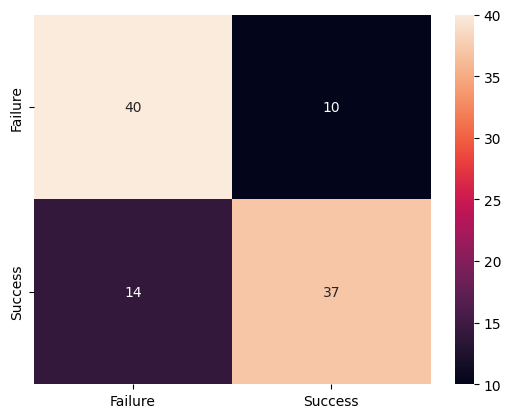

In [26]:
import seaborn as sns

#create a seaborn heatmap of the confusion matrix
class_labels = le.classes_
sns.heatmap(confusion_matrix(y_test, preds.round()), annot=True, xticklabels=class_labels, yticklabels=class_labels)
